<a href="https://colab.research.google.com/github/Loggo-MediCare/scara_fish_processing/blob/main/jetson_sklearn_%E6%88%91%E4%BE%86%E4%BA%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import smbus
import time, datetime, csv

# chatgpt 20251129 初始化I2C总线（在Jetson上I2C总线编号通常为1）
bus = smbus.SMBus(1)
sensor_address = 0x5A  # MLX90614传感器默认I2C地址0x5A

# 定义读取环境温度的函数（读取传感器寄存器0x06）
def read_ambient_temp_c():
    # 从MLX90614读取16位原始温度数据
    raw_data = bus.read_word_data(sensor_address, 0x06)
    # 将原始数据转换为摄氏温度：公式为T(°C) = raw_data * 0.02 - 273.15
    temp_c = (raw_data * 0.02) - 273.15
    return temp_c

# 设定数据记录的结束时间（例如当前时间往后60秒）
end_time = datetime.datetime.now() + datetime.timedelta(seconds=60)
records = []  # 用于存储时间和温度记录的列表

print("开始采集温度数据，每秒一次...")
while datetime.datetime.now() < end_time:
    temp = round(read_ambient_temp_c(), 1)  # 读取温度并保留一位小数
    current_time = datetime.datetime.now().strftime("%H:%M:%S")
    records.append((current_time, temp))
    print(f"{current_time} - 温度: {temp} °C")  # 打印当前温度（可选）
    time.sleep(1)  # 等待1秒

# 采集结束，保存数据到CSV文件
with open("temperature_record.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Temperature (C)"])
    writer.writerows(records)

print("数据采集完成，结果已保存到 temperature_record.csv")


In [1]:
import smbus2
import time
import streamlit as st
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import pandas as pd

# --- Hardware Configuration ---
# Jetson Nano/NX typically uses I2C Bus 1 for the J41 header pins 3 & 5.
I2C_BUS_ID = 1
SENSOR_ADDRESS = 0x5A # Default factory address for MLX90614
REG_AMBIENT_TEMP = 0x06
REG_OBJECT_TEMP = 0x07

def read_mlx90614_temp(bus, address, register):
    """
    Reads a 16-bit word from the specified register of the MLX90614.
    Converts the raw value to Celsius.
    Equation: Temp(C) = (Raw * 0.02) - 273.15
    """
    try:
        # The smbus2 library handles the start/stop bits and ACK/NACK signals
        # equivalent to the Arduino Wire library.
        raw_val = bus.read_word_data(address, register)
        celsius = (raw_val * 0.02) - 273.15
        return round(celsius, 2)
    except OSError as e:
        # Handle I/O errors (e.g., sensor disconnected or bus busy)
        return None

# --- Visualization Logic (Retained from Source) ---
def render_gauge(current_val, prev_val, placeholder):
    if current_val is None: return
    fig = go.Figure(go.Indicator(
        domain={'x': , 'y': },
        value=current_val,
        mode='gauge+number+delta',
        title={'text': 'Ambient Temp (°C)'},
        delta={'reference': prev_val},
        gauge={'axis': {'range': }}
    ))
    fig.update_layout(width=300, height=300, margin=dict(l=20, r=20, t=50, b=20))
    placeholder.write(fig)

def render_chart(data_df, placeholder):
    if data_df.empty: return
    fig = px.line(data_df, x='Timestamp', y='Temperature', title='Temperature History')
    placeholder.write(fig)

# --- Main Application Loop ---
if __name__ == '__main__':
    st.sidebar.title('Jetson Edge SCADA: Temperature')

    # Initialize I2C Bus
    try:
        # This replaces the serial.Serial() connection
        bus = smbus2.SMBus(I2C_BUS_ID)
        st.sidebar.success(f"Connected to I2C Bus {I2C_BUS_ID}")
    except PermissionError:
        st.sidebar.error("I2C Permission Denied. Run: sudo usermod -aG i2c $USER")
        st.stop()
    except Exception as e:
        st.sidebar.error(f"I2C Init Error: {e}")
        st.stop()

    # Session State for Data Persistence
    if 'temp_history' not in st.session_state:
        st.session_state.temp_history = pd.DataFrame(columns=)
    if 'recording_active' not in st.session_state:
        st.session_state.recording_active = False

    # User Controls
    with st.sidebar.form('rec_controls'):
        duration = st.number_input("Recording Duration (seconds)", min_value=10, value=60)
        start_btn = st.form_submit_button("Start Recording")

    if start_btn:
        st.session_state.recording_active = True
        # Reset data on new run
        st.session_state.temp_history = pd.DataFrame(columns=)

    # Dashboard Layout
    col1, col2 = st.columns()
    gauge_spot = col1.empty()
    chart_spot = col2.empty()
    data_spot = st.empty()

    previous_reading = 0.0

    # Real-time Acquisition Loop
    if st.session_state.recording_active:
        end_time = time.time() + duration

        while time.time() < end_time:
            # 1. Acquire Data directly from Sensor
            temp = read_mlx90614_temp(bus, SENSOR_ADDRESS, REG_AMBIENT_TEMP)

            if temp is not None:
                timestamp = datetime.now().strftime('%H:%M:%S')

                # 2. Update Data Model
                new_row = pd.DataFrame({'Timestamp': [timestamp], 'Temperature': [temp]})
                st.session_state.temp_history = pd.concat([st.session_state.temp_history, new_row], ignore_index=True)

                # 3. Update Visualization
                render_gauge(temp, previous_reading, gauge_spot)
                render_chart(st.session_state.temp_history, chart_spot)

                previous_reading = temp
            else:
                st.warning("Sensor Read Timeout - Check Wiring")

            # Control Sampling Rate (1Hz)
            time.sleep(1)

        st.session_state.recording_active = False
        st.success("Recording Completed")

        # Data Export
        csv = st.session_state.temp_history.to_csv(index=False).encode('utf-8')
        st.download_button("Download Log", csv, "jetson_temp_log.csv", "text/csv")

    bus.close()

SyntaxError: expression expected after dictionary key and ':' (ipython-input-2018851727.py, line 36)

In [ ]:
import Jetson.GPIO as GPIO
import pygame as pg
import streamlit as st
import plotly.graph_objects as go
import time
import os

# --- Headless Configuration ---
# Force Pygame to use the dummy video driver for headless Jetson operation
os.environ = "dummy"

# --- Hardware Configuration ---
# Physical Pin 33 on J41 Header. Must be enabled as PWM via jetson-io.
SERVO_PIN = 33
PWM_FREQ = 50 # Standard Servo Frequency

def initialize_motor():
    """Configures the GPIO pin for PWM output."""
    GPIO.setmode(GPIO.BOARD)
    GPIO.setup(SERVO_PIN, GPIO.OUT, initial=GPIO.HIGH)
    pwm = GPIO.PWM(SERVO_PIN, PWM_FREQ)
    pwm.start(0) # Start with 0% duty cycle (motor off/idle)
    return pwm

def map_input_to_duty(axis_value):
    """
    Maps joystick axis (-1.0 to 1.0) to PWM Duty Cycle.
    Mapping Strategy:
    - Joystick -1.0 (Full Back) -> 0 Degrees -> 2.5% Duty
    - Joystick 0.0 (Center) -> 90 Degrees -> 7.5% Duty
    - Joystick 1.0 (Full Fwd) -> 180 Degrees -> 12.5% Duty
    """
    # 1. Normalize axis to 0.0 - 2.0 (inverted so Up is positive)
    norm_val = (axis_value * -1) + 1

    # 2. Convert to Angle (0 - 180)
    angle = norm_val * 90

    # 3. Convert to Duty Cycle (Formula: Angle/18 + 2.5)
    duty = (angle / 18.0) + 2.5

    # 4. Safety Clamping
    duty = max(2.5, min(12.5, duty))

    return angle, duty

# --- Visualization Logic ---
def update_speedometer(angle, placeholder):
    fig = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = angle,
        title = {'text': "Servo Angle"},
        gauge = {'axis': {'range': },
                 'bar': {'color': "darkblue"},
                 'steps': [{'range': , 'color': "lightgray"},
                           {'range': , 'color': "gray"}]}
    ))
    fig.update_layout(width=300, height=300)
    placeholder.write(fig)

# --- Main Application ---
if __name__ == '__main__':
    st.sidebar.title('Jetson Edge SCADA: Motor Control')

    # Initialization
    if 'motor_running' not in st.session_state:
        st.session_state.motor_running = False

    pg.init()
    # Check for controller
    if pg.joystick.get_count() < 1:
        st.error("No USB Joystick Detected. Please connect a controller.")
    else:
        js = pg.joystick.Joystick(0)
        js.init()
        st.sidebar.success(f"Controller: {js.get_name()}")

        col1, col2 = st.sidebar.columns(2)
        start_btn = col1.button("Activate Motor")
        stop_btn = col2.button("Deactivate Motor")

        if start_btn:
            st.session_state.motor_running = True
            pwm_controller = initialize_motor()

        if stop_btn:
            st.session_state.motor_running = False
            # Clean shutdown of GPIO
            if 'pwm_controller' in locals():
                pwm_controller.stop()
            GPIO.cleanup()

        # UI Placeholders
        status_text = st.empty()
        gauge_view = st.empty()

        # Real-Time Control Loop
        while st.session_state.motor_running:
            pg.event.pump() # Process internal Pygame event queue

            # Read Axis 1 (Left Stick Y-Axis typically)
            y_axis = js.get_axis(1)

            # Kill Switch (Button 0 - typically 'A' or 'X')
            if js.get_button(0):
                st.session_state.motor_running = False
                pwm_controller.stop()
                GPIO.cleanup()
                st.error("Emergency Stop Activated")
                break

            # Compute Control Signal
            target_angle, duty_cycle = map_input_to_duty(y_axis)

            # Update Hardware
            pwm_controller.ChangeDutyCycle(duty_cycle)

            # Update UI
            update_speedometer(target_angle, gauge_view)
            status_text.info(f"Input: {y_axis:.2f} | Duty: {duty_cycle:.2f}% | Angle: {target_angle:.1f}°")

            # Limit loop rate to ~50Hz to match servo update frequency
            time.sleep(0.02)

SyntaxError: expression expected after dictionary key and ':' (ipython-input-870378895.py, line 53)

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
import yfinance as yf
import pandas_datareader.data as web

# 模型相關庫
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# =============================================================================
#  技術指標計算函數 (保持不變，但在邏輯中增強使用)
# =============================================================================
def calculate_MA(prices, period=10):
    prices = np.array(prices, dtype=float)
    ma = np.full(len(prices), np.nan)
    for i in range(period - 1, len(prices)):
        ma[i] = np.mean(prices[i - period + 1:i + 1])
    return ma

def calculate_EMA(prices, period=12):
    prices = np.array(prices, dtype=float)
    ema = np.full(len(prices), np.nan)
    multiplier = 2 / (period + 1)
    ema[period - 1] = np.mean(prices[:period])
    for i in range(period, len(prices)):
        ema[i] = (prices[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema

def calculate_RSI(prices, period=14):
    prices = np.array(prices, dtype=float)
    rsi = np.full(len(prices), np.nan)
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    losses = np.where(deltas < 0, -deltas, 0)

    # 初始計算
    avg_gain = np.mean(gains[:period])
    avg_loss = np.mean(losses[:period])

    if avg_loss == 0:
        rsi[period] = 100
    else:
        rs = avg_gain / avg_loss
        rsi[period] = 100 - (100 / (1 + rs))

    # 平滑計算
    for i in range(period + 1, len(prices)):
        gain = gains[i-1]
        loss = losses[i-1]
        avg_gain = (avg_gain * (period - 1) + gain) / period
        avg_loss = (avg_loss * (period - 1) + loss) / period

        if avg_loss == 0:
            rsi[i] = 100
        else:
            rs = avg_gain / avg_loss
            rsi[i] = 100 - (100 / (1 + rs))
    return rsi

def calculate_MACD(prices, fast_period=12, slow_period=26, signal_period=9):
    prices = np.array(prices, dtype=float)
    ema_fast = calculate_EMA(prices, fast_period)
    ema_slow = calculate_EMA(prices, slow_period)
    macd = ema_fast - ema_slow

    signal = np.full(len(prices), np.nan)
    # 計算 Signal 線
    # 需要先剔除前面的 NaN
    valid_start = slow_period - 1
    if len(macd) > valid_start + signal_period:
        valid_macd = macd[valid_start:]
        signal_values = calculate_EMA(valid_macd, signal_period)
        signal[valid_start:] = signal_values

    return macd, signal, macd - signal

# =============================================================================
# 2. 整合策略類 (核心優化部分)
# =============================================================================
class IntegratedTradingStrategy:
    def __init__(self, target_stock='mu', data_period_years=5):
        self.target_stock = target_stock.upper()
        # 相關性資產
        self.correlated_stocks = [self.target_stock, 'NVDA', 'AMD'] # 確保包含目標股票自身
        self.currency_pairs = ['DEXJPUS', 'DEXUSUK']
        self.indices = ['SP500', 'DJIA', 'VIXCLS']

        self.return_period = 5 # 預測未來 5 天 (一週)
        self.data_period_years = data_period_years

        # 參數
        self.ma_period = 20
        self.stop_loss_pct = 0.03
        self.take_profit_pct = 0.06

        # 模型儲存
        self.arimax_model = None
        self.linear_model = None
        self.best_model_name = None

    def load_data(self, start_date, end_date):
        print(f"[{self.target_stock}] 正在加載多因子數據 ({start_date} ~ {end_date})...")

        # 1. 下載股票數據 (強制 auto_adjust=False 以獲取 Adj Close)
        stk_data = yf.download(self.correlated_stocks, start=start_date, end=end_date, auto_adjust=False, progress=False)

        # 2. 處理 yfinance 複雜的 MultiIndex
        # 如果只有一支股票，columns 可能只是 Index，如果是多支，則是 MultiIndex
        if isinstance(stk_data.columns, pd.MultiIndex):
            # 嘗試標準化：保留 Adj Close，若無則用 Close
            try:
                price_data = stk_data['Adj Close'].copy()
            except KeyError:
                print("警告: 找不到 'Adj Close'，嘗試使用 'Close'")
                price_data = stk_data['Close'].copy()
        else:
            # 單支股票情況
            price_data = pd.DataFrame(stk_data['Adj Close'])
            price_data.columns = [self.target_stock]

        # 填補缺失值
        price_data = price_data.ffill().bfill()

        # 3. 下載總經數據 (FRED)
        try:
            ccy_data = web.DataReader(self.currency_pairs, 'fred', start_date, end_date).ffill()
            idx_data = web.DataReader(self.indices, 'fred', start_date, end_date).ffill()
        except Exception as e:
            print(f"FRED 數據下載失敗: {e} (將使用隨機數據模擬以免程式崩潰)")
            # 模擬數據以免中斷 (僅供調試用)
            dates = price_data.index
            ccy_data = pd.DataFrame(np.random.randn(len(dates), len(self.currency_pairs)), index=dates, columns=self.currency_pairs)
            idx_data = pd.DataFrame(np.random.randn(len(dates), len(self.indices)), index=dates, columns=self.indices)

        return price_data, ccy_data, idx_data

    def prepare_features(self, stk_prices, ccy_data, idx_data):
        print("正在準備 ARIMAX/LR 特徵工程...")

        # 合併所有數據並確保索引對齊
        all_data = pd.concat([stk_prices, ccy_data, idx_data], axis=1).ffill().dropna()

        # 1. 建構目標變量 Y (未來 N 天的收益率)
        # shift(-N) 表示將未來的數據對齊到今天
        target_series = all_data[self.target_stock]
        Y = np.log(target_series).diff(self.return_period).shift(-self.return_period)
        Y.name = 'Target_Return'

        # 2. 建構特徵變量 X (過去的數據)
        # 相關股票的收益率
        X1 = np.log(all_data[self.correlated_stocks]).diff(self.return_period)
        # 貨幣與指數的變動率
        X2 = np.log(all_data[self.currency_pairs]).diff(self.return_period)
        X3 = np.log(all_data[self.indices]).diff(self.return_period)

        # 動量特徵 (Momentum): 過去 1週, 3週, 6週 的收益率
        periods = [self.return_period, self.return_period*3, self.return_period*6]
        X4_list = []
        for p in periods:
            col = np.log(target_series).diff(p)
            col.name = f'Momentum_{p}d'
            X4_list.append(col)
        X4 = pd.concat(X4_list, axis=1)

        # 合併所有 X
        X = pd.concat([X1, X2, X3, X4], axis=1)

        # 清理 NaN (因為 diff 和 shift 會產生 NaN)
        dataset = pd.concat([Y, X], axis=1).dropna()

        # 為了避免序列相關性過高，我們每隔 return_period 取樣一次 (週頻率)
        dataset = dataset.iloc[::self.return_period, :]

        return dataset.drop(columns=['Target_Return']), dataset['Target_Return'], all_data

    def train_models(self, X_train, Y_train, X_test, Y_test):
        print("-> 正在訓練 AI 模型 (LR, LASSO, ARIMAX)...")

        # --- 1. 線性模型群 ---
        models = {
            'LR': LinearRegression(),
            'LASSO': Lasso(alpha=0.0001, max_iter=10000), # alpha設小一點避免全被懲罰掉
            'EN': ElasticNet(alpha=0.0001, max_iter=10000)
        }

        best_mse = float('inf')

        for name, model in models.items():
            model.fit(X_train, Y_train)
            pred = model.predict(X_test)
            mse = mean_squared_error(Y_test, pred)
            # print(f"   - {name} MSE: {mse:.6f}")

            if mse < best_mse:
                best_mse = mse
                self.best_model_name = name
                self.linear_model = model

        print(f"-> 最佳線性模型: {self.best_model_name} (MSE: {best_mse:.6f})")

        # --- 2. ARIMAX 模型 ---
        # 選擇部分重要特徵給 ARIMAX (避免維度災難)
        # 簡單起見，我們選相關性最高的 3 個特徵
        corrs = X_train.corrwith(Y_train).abs().sort_values(ascending=False)
        top_features = corrs.head(3).index.tolist()
        self.arimax_exog_vars = top_features

        try:
            # order=(p,d,q) 可以通過 auto_arima 優化，這裡固定為 (1,0,1)
            model_arima = ARIMA(endog=Y_train, exog=X_train[top_features], order=(1,0,1))
            self.arimax_model = model_arima.fit()

            # 測試 ARIMAX
            arima_pred = self.arimax_model.forecast(steps=len(X_test), exog=X_test[top_features])
            arima_mse = mean_squared_error(Y_test, arima_pred)
            print(f"-> ARIMAX (1,0,1) MSE: {arima_mse:.6f}")

        except Exception as e:
            print(f"ARIMAX 訓練失敗: {e}")

    def analyze_technical_status(self, full_price_data):
        """分析當前的技術面狀態 (MA, RSI, MACD)"""
        prices = full_price_data[self.target_stock].values

        ma = calculate_MA(prices, self.ma_period)
        rsi = calculate_RSI(prices, 14)
        macd, signal, hist = calculate_MACD(prices)

        # 取得最新值
        curr_price = prices[-1]
        curr_ma = ma[-1]
        curr_rsi = rsi[-1]
        curr_hist = hist[-1]

        status = {
            'price': curr_price,
            'rsi': curr_rsi,
            'macd_hist': curr_hist,
            'ma_trend': 'BULL' if curr_price > curr_ma else 'BEAR'
        }

        # 綜合技術評分 (-1 到 1)
        score = 0
        if curr_price > curr_ma: score += 1
        else: score -= 1

        if curr_hist > 0: score += 1
        else: score -= 1

        if 40 < curr_rsi < 60: score += 0 # 中性
        elif curr_rsi >= 60: score += 1 # 強勢 (但也可能超買)
        elif curr_rsi <= 40: score -= 1 # 弱勢

        status['tech_score'] = score # 範圍約 -3 ~ 3

        return status

    def run_strategy(self):
        print("\n" + "="*60)
        print(f"執行每週策略分析: {self.target_stock}")
        print("="*60)

        # 1. 準備數據
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * self.data_period_years)

        stk_prices, ccy_data, idx_data = self.load_data(start_date, end_date)
        X, Y, raw_data = self.prepare_features(stk_prices, ccy_data, idx_data)

        # 2. 訓練模型 (滾動視窗：使用過去所有數據訓練，預測下一週)
        # 分割 80% 訓練, 20% 驗證 (此處為了示範簡單分割)
        train_size = int(len(X) * 0.85)
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

        self.train_models(X_train, Y_train, X_test, Y_test)

        # 3. 生成下週預測 (AI Signal)
        # 構建當前最新的特徵向量 (Raw Data 的最後一行)
        latest_data = raw_data.iloc[-1:]
        # 重建特徵 (需要手動重新計算最後一行的 Diff，因為 prepare_features 裡的 diff 會讓最後一行變 NaN 如果沒 shift)
        # 這裡為了簡化，我們直接拿 X 的最後一行做近似 (實際生產環境需精確重算)
        current_features = X.iloc[-1:].values.reshape(1, -1)
        current_features_df = X.iloc[-1:]

        pred_lr = self.linear_model.predict(current_features)[0]

        pred_arima = 0
        if self.arimax_model:
            # ARIMAX forecast 需要 exog
            exog_latest = current_features_df[self.arimax_exog_vars]
            pred_arima = self.arimax_model.forecast(steps=1, exog=exog_latest).iloc[0]

        avg_pred_return = (pred_lr + pred_arima) / 2
        print(f"\n[AI 預測結果]")
        print(f"線性模型預測: {pred_lr*100:.2f}%")
        print(f"ARIMAX 預測 : {pred_arima*100:.2f}%")
        print(f"-> 綜合預測下週漲跌: {avg_pred_return*100:.2f}%")

        # 4. 技術面分析 (Technical Signal)
        tech_status = self.analyze_technical_status(raw_data)
        print(f"\n[技術面狀態]")
        print(f"當前價格: {tech_status['price']:.2f}")
        print(f"RSI: {tech_status['rsi']:.2f}")
        print(f"MACD柱狀圖: {tech_status['macd_hist']:.4f}")
        print(f"技術評分: {tech_status['tech_score']} (正為多，負為空)")

        # 5. 最終決策 (AI Confidence Filter Logic)
        print("\n" + "-"*40)
        print("最終交易建議")
        print("-"*40)

        decision = "觀望 (Wait)"
        action = "無動作"

        # 邏輯 A: 技術面與 AI 共振 (最佳進場點)
        if tech_status['tech_score'] >= 1 and avg_pred_return > 0.005:
            decision = "強烈買入 (Strong Buy)"
            action = "進場做多 (趨勢確認)"

        # 邏輯 B: AI 強力看漲，技術面尚未跟上 (左側交易/潛伏)
        # 條件：AI預測 > 1.5% 且 RSI 沒有超賣 (不是接刀) 且 MACD 柱狀圖在收斂
        elif avg_pred_return > 0.015 and tech_status['rsi'] > 30:
            decision = "潛伏買入 (Accumulate)"
            action = "小部位建倉 (博反彈)"

        # 邏輯 C: 技術面轉弱，AI 也看空
        elif tech_status['tech_score'] <= -1 and avg_pred_return < -0.005:
            decision = "賣出/做空 (Sell)"
            action = "清倉或反手"

        print(f"決策: {decision}")
        print(f"行動: {action}")
        print("="*60)

# =============================================================================
# 執行區
# =============================================================================
if __name__ == "__main__":
    # 可以將 'mu' 換成 'NVDA' 或其他美股代碼
    bot = IntegratedTradingStrategy(target_stock='mu', data_period_years=2)
    bot.run_strategy()


執行每週策略分析: MU
[MU] 正在加載多因子數據 (2023-11-29 08:16:21.909487 ~ 2025-11-28 08:16:21.909487)...
正在準備 ARIMAX/LR 特徵工程...
-> 正在訓練 AI 模型 (LR, LASSO, ARIMAX)...
-> 最佳線性模型: LR (MSE: 0.009344)
-> ARIMAX (1,0,1) MSE: 0.009540

[AI 預測結果]
線性模型預測: 0.53%
ARIMAX 預測 : 2.82%
-> 綜合預測下週漲跌: 1.67%

[技術面狀態]
當前價格: 230.26
RSI: 54.50
MACD柱狀圖: -3.5782
技術評分: -2 (正為多，負為空)

----------------------------------------
最終交易建議
----------------------------------------
決策: 潛伏買入 (Accumulate)
行動: 小部位建倉 (博反彈)


In [ ]:
#copy from github
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
#from keras.wrappers.scikit_learn import KerasRegressor # This line is causing the error

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import yfinance as yf
import pandas_datareader.data as web

stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = yf.download(stk_tickers)
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

[*********************100%***********************]  3 of 3 completed


In [ ]:
return_period = 5

In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime, timedelta

# =========================================================
# 1. 設定時間範圍 (關鍵修正)
# =========================================================
# 設定結束時間為今天
end_date = datetime.now()

# 設定開始時間為 3 年前 (365 * 3 = 1095 天)
# 這樣可以確保有足夠的歷史數據來計算 12週(60天) 的動量指標，
# 且扣除掉特徵工程損失的列數後，還有足夠的數據訓練模型。
start_date = end_date - timedelta(days=365 * 3)

print(f"下載區間: {start_date.date()} ~ {end_date.date()}")

# =========================================================
# 2. 下載數據 (加入 start 與 end)
# =========================================================
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

print("正在下載股票數據...")
# 加入 auto_adjust=False 以確保我們能拿到 Adj Close 和 Close (避免新版 yfinance 格式混亂)
stk_data = yf.download(stk_tickers, start=start_date, end=end_date, auto_adjust=False)

print("正在下載經濟數據 (FRED)...")
# pandas_datareader 也支援 start 和 end 參數
ccy_data = web.DataReader(ccy_tickers, 'fred', start=start_date, end=end_date)
idx_data = web.DataReader(idx_tickers, 'fred', start=start_date, end=end_date)

# =========================================================
# 3. 檢查數據量 (確認是否足夠)
# =========================================================
print(f"\n--- 下載完成 ---")
print(f"股票數據筆數: {len(stk_data)} (預期約 750 筆)")
print(f"貨幣數據筆數: {len(ccy_data)}")
print(f"指數數據筆數: {len(idx_data)}")

if len(stk_data) < 200:
    print("警告: 數據量仍然太少，請檢查您的網路或擴大 start_date 範圍。")

下載區間: 2022-11-29 ~ 2025-11-28
正在下載股票數據...


[*********************100%***********************]  3 of 3 completed


正在下載經濟數據 (FRED)...

--- 下載完成 ---
股票數據筆數: 753 (預期約 750 筆)
貨幣數據筆數: 778
指數數據筆數: 782


In [ ]:
# Check if 'Adj Close' exists, otherwise use 'Close'
if 'Adj Close' in stk_data.columns.get_level_values(0):
    price_col_name = 'Adj Close'
else:
    price_col_name = 'Close'
    print(f"Warning: 'Adj Close' not found in stk_data, using '{price_col_name}' instead.")

Y = np.log(stk_data.loc[:, (price_col_name, 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, (price_col_name, ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, (price_col_name, 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [ ]:
# 1. 關鍵修復：統一時區 (移除時區資訊以進行對齊)
# 確保 stk_data, ccy_data, idx_data 的索引都沒有時區
if hasattr(stk_data.index, 'tz'):
    stk_data.index = stk_data.index.tz_localize(None)
if hasattr(ccy_data.index, 'tz'):
    ccy_data.index = ccy_data.index.tz_localize(None)
if hasattr(idx_data.index, 'tz'):
    idx_data.index = idx_data.index.tz_localize(None)

# 2. 確定價格欄位名稱
if isinstance(stk_data.columns, pd.MultiIndex):
    # 檢查 'Adj Close' 是否在第一層級
    if 'Adj Close' in stk_data.columns.get_level_values(0):
        price_col_name = 'Adj Close'
    else:
        price_col_name = 'Close'
        print(f"Warning: 'Adj Close' not found, using '{price_col_name}'.")

    # 安全的提取 Series
    msft_series = stk_data[price_col_name]['MSFT']
    # 提取其他股票並移除 MultiIndex
    others_df = stk_data[price_col_name][['GOOGL', 'IBM']]
else:
    # 處理非 MultiIndex 的情況 (如果只下載了一支股票或 yfinance 格式變更)
    msft_series = stk_data['Adj Close'] if 'Adj Close' in stk_data else stk_data['Close']
    # 這裡假設如果不是 MultiIndex，你可能無法同時取到 GOOGL/IBM，需視您下載代碼而定
    # 這裡做個防呆，若無資料則創建空的
    others_df = pd.DataFrame()

# 3. 建構特徵與目標 (加入 ffill 以防數據日期間隙)
# 目標 Y
Y = np.log(msft_series).diff(return_period).shift(-return_period)
Y.name = 'MSFT_pred'

# 特徵 X1 (相關股票)
X1 = np.log(others_df).diff(return_period)

# 特徵 X2, X3 (外匯與指數) - 這裡先做 ffill 確保經濟數據能對齊股票交易日
X2 = np.log(ccy_data).diff(return_period).ffill()
X3 = np.log(idx_data).diff(return_period).ffill()

# 特徵 X4 (動量)
X4 = pd.concat([
    np.log(msft_series).diff(i)
    for i in [return_period, return_period*3, return_period*6, return_period*12]
], axis=1)
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

# 4. 合併所有資料
# 這裡使用 concat(..., join='outer') 然後再 dropna，這樣比較安全
all_features = pd.concat([X1, X2, X3, X4], axis=1)

# 5. 最終組裝與清洗
# 先將 Y 和 X 合併，然後用 ffill 填補因假期造成的空缺，最後再 dropna
dataset = pd.concat([Y, all_features], axis=1)

# *重要診斷*: 在 dropna 之前打印形狀
print(f"Shape before dropna: {dataset.shape}")

# 執行 dropna
dataset = dataset.dropna()

# 每隔 return_period 取樣一次 (避免序列相關性)
dataset = dataset.iloc[::return_period, :]

print(f"Shape after dropna: {dataset.shape}")

# 分離 Y 和 X
if not dataset.empty:
    Y = dataset.iloc[:, 0]
    X = dataset.iloc[:, 1:]

    pd.set_option('display.precision', 3)
    print(dataset.describe())
else:
    print("錯誤: 數據集在處理後為空。請檢查下載數據的日期範圍是否足夠長 (X4 需要很長的歷史數據)。")

Shape before dropna: (784, 12)
Shape after dropna: (138, 12)
       MSFT_pred    GOOGL      IBM  DEXJPUS    DEXUSUK    SP500     DJIA  \
count    138.000  138.000  138.000  138.000  1.380e+02  138.000  138.000   
mean       0.005    0.008    0.006    0.001  3.939e-04    0.004    0.002   
std        0.030    0.041    0.037    0.013  9.950e-03    0.022    0.020   
min       -0.075   -0.093   -0.125   -0.046 -2.410e-02   -0.123   -0.109   
25%       -0.016   -0.018   -0.015   -0.004 -6.387e-03   -0.008   -0.007   
50%        0.007    0.012    0.006    0.001  3.852e-05    0.007    0.004   
75%        0.023    0.030    0.027    0.009  6.566e-03    0.015    0.013   
max        0.103    0.126    0.151    0.033  3.494e-02    0.080    0.070   

        VIXCLS  MSFT_DT  MSFT_3DT  MSFT_6DT  MSFT_12DT  
count  138.000  138.000   138.000   138.000    138.000  
mean    -0.003    0.005     0.015     0.032      0.066  
std      0.163    0.030     0.052     0.072      0.103  
min     -0.552   -0.075   

In [ ]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. 診斷：檢查是哪個欄位全是 NaN
# ==============================================================================
print("--- 診斷報告 ---")
# 檢查 stk_data 裡到底有哪些股票
if isinstance(stk_data.columns, pd.MultiIndex):
    print("下載的股票清單:", stk_data.columns.get_level_values(1).unique().tolist())
else:
    print("下載的股票數據不是 MultiIndex，可能只有一支股票。")

# ==============================================================================
# 2. 強制修復：以 MSFT 的日期為基準 (Master Index)
# ==============================================================================

# 步驟 A: 準備主索引 (Master Index) - 以 MSFT 為準
# 確保沒有時區干擾
if hasattr(stk_data.index, 'tz'):
    stk_data.index = stk_data.index.tz_localize(None)
if hasattr(ccy_data.index, 'tz'):
    ccy_data.index = ccy_data.index.tz_localize(None)
if hasattr(idx_data.index, 'tz'):
    idx_data.index = idx_data.index.tz_localize(None)

# 確定價格欄位
if 'Adj Close' in stk_data.columns.get_level_values(0):
    price_col = 'Adj Close'
else:
    price_col = 'Close'

# 提取目標股票 (MSFT)
try:
    msft_series = stk_data.loc[:, (price_col, 'MSFT')]
except KeyError:
    # 如果找不到 MSFT，嘗試找第一支股票當作目標
    target = stk_data.columns.get_level_values(1)[0]
    print(f"警告: 找不到 MSFT，改用 {target}")
    msft_series = stk_data.loc[:, (price_col, target)]

# 定義主日期索引 (Master Date Index)
master_index = msft_series.index

# 步驟 B: 建構 Y (目標)
Y = np.log(msft_series).diff(return_period).shift(-return_period)
Y.name = 'MSFT_pred'

# 步驟 C: 建構 X1 (相關股票)
# 自動抓取除了 MSFT 以外的所有股票，而不是硬編碼 GOOGL/IBM
other_stocks = stk_data.loc[:, price_col].drop(columns=['MSFT'], errors='ignore')

if not other_stocks.empty:
    X1 = np.log(other_stocks).diff(return_period)
    # 關鍵：強制對齊到 Master Index
    X1 = X1.reindex(master_index).ffill()
else:
    print("警告: 沒有其他相關股票數據 (X1 將被省略)")
    X1 = pd.DataFrame(index=master_index)

# 步驟 D: 建構 X2, X3 (經濟數據)
# 關鍵：使用 reindex + ffill 強制將經濟數據填入股票交易日
X2 = np.log(ccy_data).diff(return_period).reindex(master_index).ffill()
X3 = np.log(idx_data).diff(return_period).reindex(master_index).ffill()

# 步驟 E: 建構 X4 (動量)
X4 = pd.concat([
    np.log(msft_series).diff(i)
    for i in [return_period, return_period*3, return_period*6, return_period*12]
], axis=1)
X4.columns = ['Momentum_1w', 'Momentum_3w', 'Momentum_6w', 'Momentum_12w']

# ==============================================================================
# 3. 合併與清理
# ==============================================================================
# 將所有特徵橫向合併
all_features = pd.concat([Y, X1, X2, X3, X4], axis=1)

print(f"\n清理前形狀: {all_features.shape}")

# 檢查每個欄位的缺失值狀況 (幫助你除錯)
print("\n各欄位缺失值數量 (Top 10):")
print(all_features.isnull().sum().sort_values(ascending=False).head(10))

# 執行刪除
dataset = all_features.dropna()

print(f"清理後形狀: {dataset.shape}")

if dataset.empty:
    print("\n錯誤: 數據集仍然為空。原因分析：")
    print("1. 請檢查上方的缺失值報告，看是哪個欄位全是 NaN。")
    print("2. 如果是 X4 (Momentum) 全是 NaN，代表下載的數據歷史長度不足 (至少需要 1年數據)。")
    print("3. 如果是 X2/X3 (經濟數據) 全是 NaN，代表 FRED 下載失敗或代碼錯誤。")
else:
    # 採樣
    dataset = dataset.iloc[::return_period, :]
    Y = dataset.iloc[:, 0]
    X = dataset.iloc[:, 1:]

    pd.set_option('display.precision', 3)
    print("\n成功！數據預覽:")
    print(dataset.describe())

--- 診斷報告 ---
下載的股票清單: ['GOOGL', 'IBM', 'MSFT']

清理前形狀: (753, 12)

各欄位缺失值數量 (Top 10):
Momentum_12w    60
Momentum_6w     30
Momentum_3w     15
DEXJPUS          6
VIXCLS           6
DJIA             6
SP500            6
DEXUSUK          6
IBM              5
GOOGL            5
dtype: int64
清理後形狀: (688, 12)

成功！數據預覽:
       MSFT_pred    GOOGL      IBM  DEXJPUS    DEXUSUK    SP500     DJIA  \
count    138.000  138.000  138.000  138.000  1.380e+02  138.000  138.000   
mean       0.005    0.008    0.006    0.001  3.939e-04    0.004    0.002   
std        0.030    0.041    0.037    0.013  9.950e-03    0.022    0.020   
min       -0.075   -0.093   -0.125   -0.046 -2.410e-02   -0.123   -0.109   
25%       -0.016   -0.018   -0.015   -0.004 -6.387e-03   -0.008   -0.007   
50%        0.007    0.012    0.006    0.001  3.852e-05    0.007    0.004   
75%        0.023    0.030    0.027    0.009  6.566e-03    0.015    0.013   
max        0.103    0.126    0.151    0.033  3.494e-02    0.080    0.070   



In [ ]:
pd.set_option('display.precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,Momentum_1w,Momentum_3w,Momentum_6w,Momentum_12w
count,138.000,138.000,138.000,138.000,1.380e+02,138.000,138.000,138.000,138.000,138.000,138.000,138.000
mean,0.005,0.008,0.006,0.001,3.939e-04,0.004,0.002,-0.003,0.005,0.015,0.032,0.066
std,0.030,0.041,0.037,0.013,9.950e-03,0.022,0.020,0.163,0.030,0.052,0.072,0.103
min,-0.075,-0.093,-0.125,-0.046,-2.410e-02,-0.123,-0.109,-0.552,-0.075,-0.105,-0.131,-0.168
25%,-0.016,-0.018,-0.015,-0.004,-6.387e-03,-0.008,-0.007,-0.098,-0.016,-0.023,-0.017,-0.011
50%,0.007,0.012,0.006,0.001,3.852e-05,0.007,0.004,-0.013,0.007,0.019,0.030,0.051
75%,0.023,0.030,0.027,0.009,6.566e-03,0.015,0.013,0.082,0.023,0.042,0.086,0.144
max,0.103,0.126,0.151,0.033,3.494e-02,0.080,0.070,0.877,0.103,0.190,0.246,0.341


In [ ]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,Momentum_1w,Momentum_3w,Momentum_6w,Momentum_12w
Date,,,,,,,,,,,,
2023-02-27,0.026,-0.049,-0.034,1.589e-02,-5.342e-03,-0.027,-0.030,-0.013,-0.031,-0.030,0.050,0.043
2023-03-06,-0.012,0.057,-0.002,-1.837e-03,9.965e-04,0.016,0.016,-0.118,0.026,-0.021,0.070,0.049
2023-03-13,0.070,-0.043,-0.036,-2.081e-02,9.253e-03,-0.049,-0.049,0.354,-0.012,-0.016,0.025,-0.009
2023-03-20,0.015,0.105,0.003,-1.164e-02,7.945e-03,0.025,0.013,-0.094,0.070,0.085,0.055,0.121
2023-03-27,0.039,0.012,0.026,-7.602e-04,1.712e-03,0.007,0.006,-0.159,0.015,0.073,0.052,0.167


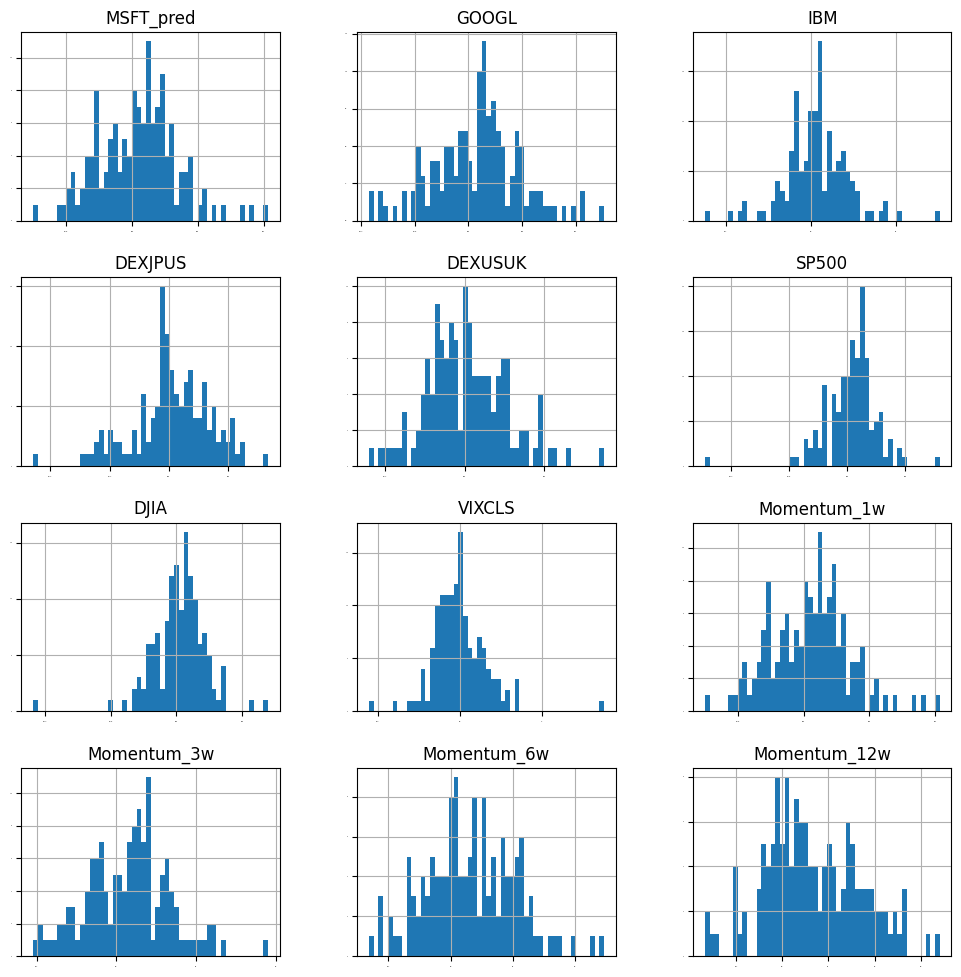

In [ ]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

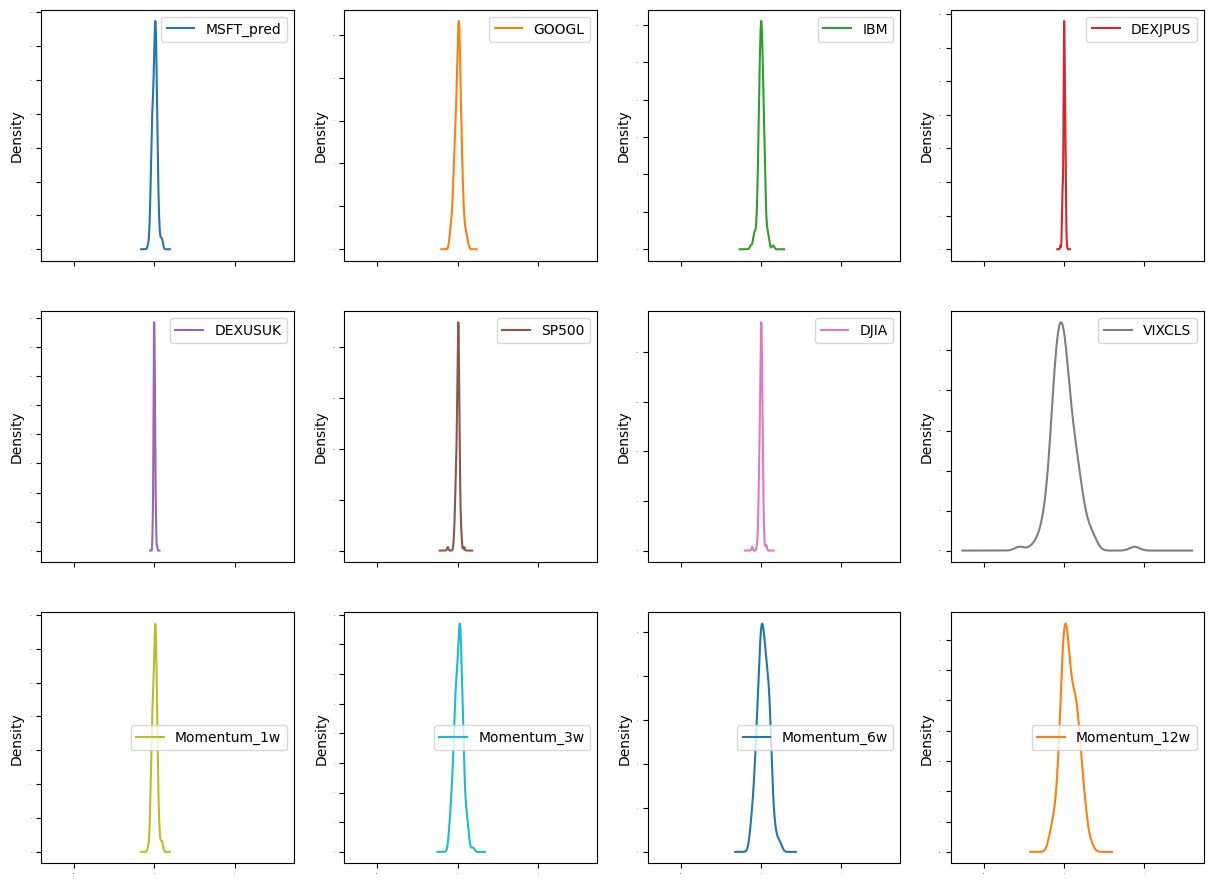

In [ ]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

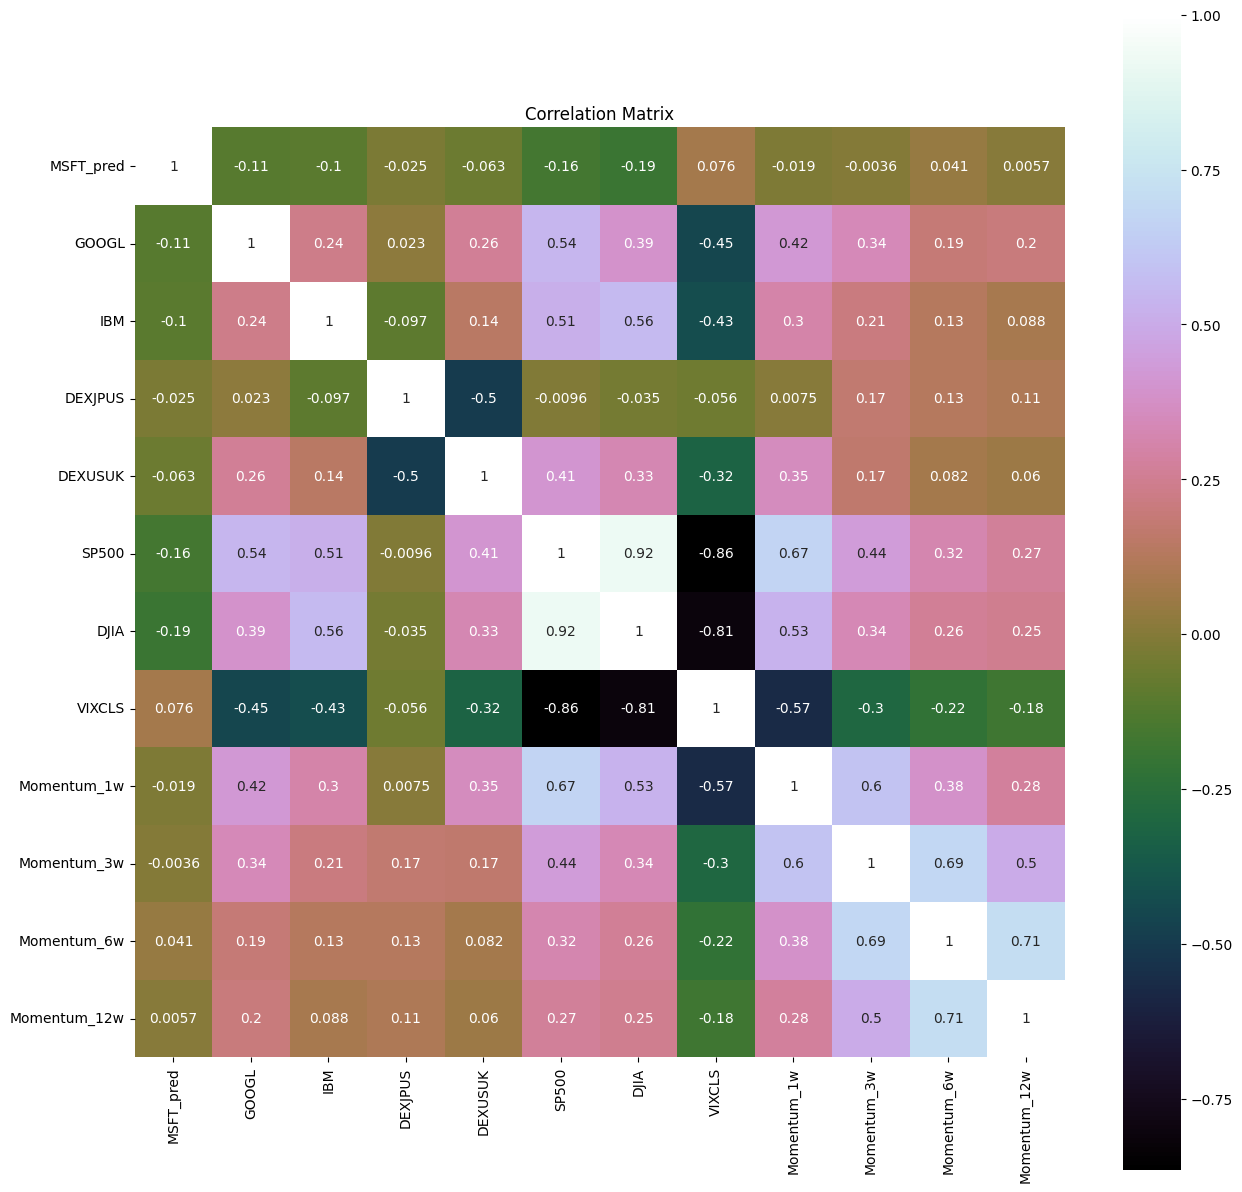

In [ ]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

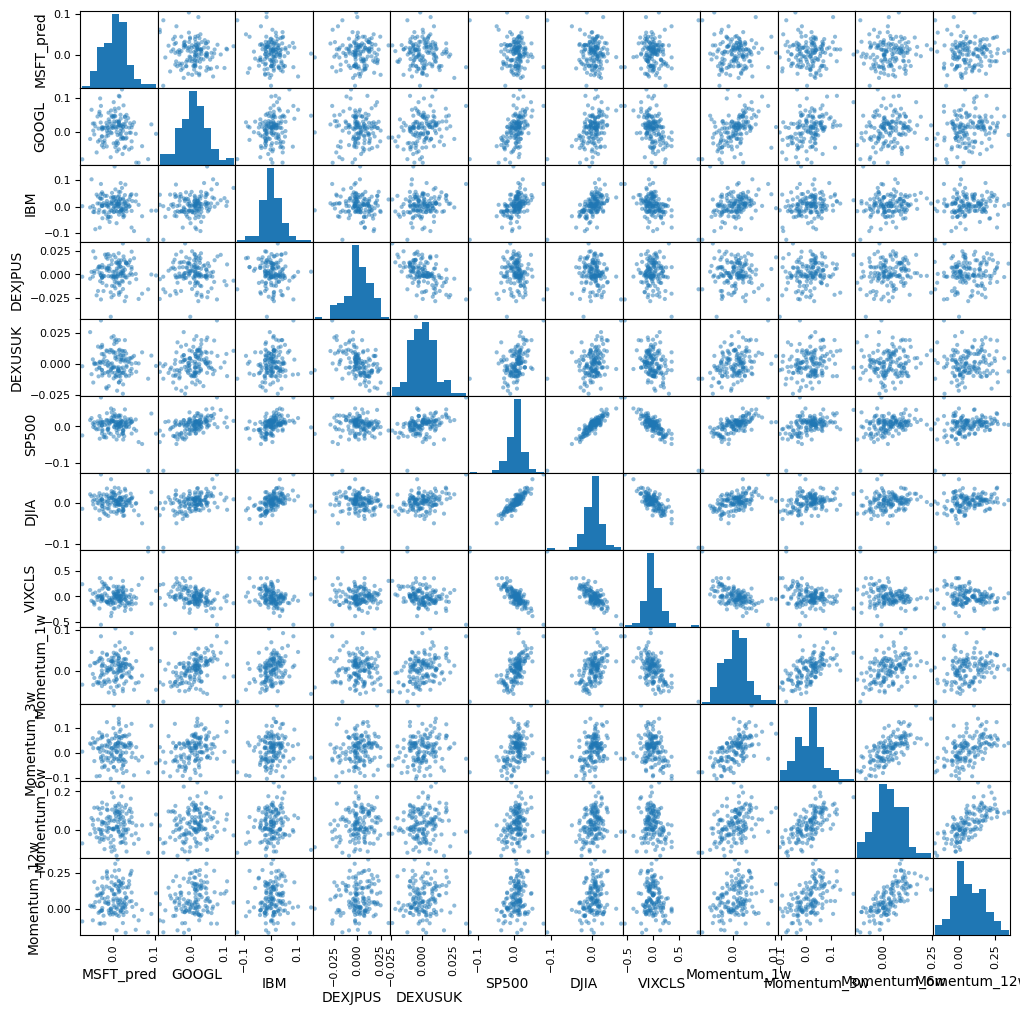

In [ ]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

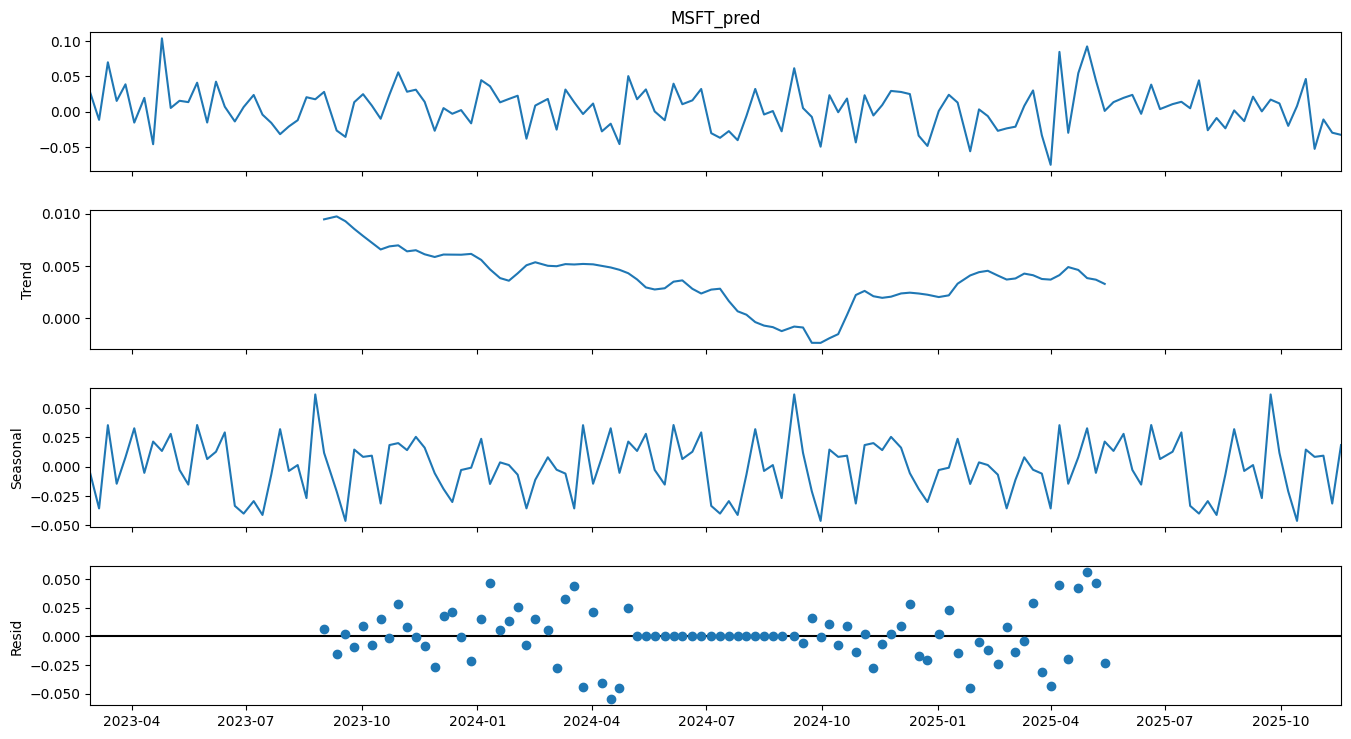

In [ ]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

In [ ]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
DJIA,5.215
SP500,3.612
GOOGL,1.803
IBM,1.441
VIXCLS,0.800
DEXUSUK,0.541
Momentum_6w,0.230
DEXJPUS,0.084
Momentum_1w,0.047


In [ ]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [ ]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [ ]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
import pandas as pd

# ==============================================================
# 查看模型大腦：因子貢獻度分析 (Feature Importance)
# ==============================================================
print("\n" + "="*50)
print("因子貢獻度分析 (為何 AI 看漲?)")
print("="*50)

# 提取係數並對應特徵名稱
coefs = pd.Series(lasso.coef_, index=X_train.columns)

# 過濾掉係數為 0 的因子 (LASSO 會自動把不重要的雜訊歸零)
important_features = coefs[coefs != 0].sort_values(key=abs, ascending=False)

if important_features.empty:
    print("模型過度懲罰，所有係數皆為 0 (可能是數據噪音太大)。")
else:
    print(important_features)

    print("\n[解讀指南]")
    top_feature = important_features.index[0]
    top_value = important_features.iloc[0]

    print(f"1. 最關鍵因子是 **{top_feature}** (權重 {top_value:.4f})")

    if "SP500" in top_feature or "DJIA" in top_feature:
        print("   -> 結論：微軟目前是「隨大盤起舞」，大盤漲它就漲。")
    elif "Momentum" in top_feature:
        if top_value > 0:
            print("   -> 結論：微軟處於「強者恆強」的順勢動能中。")
        else:
            print("   -> 結論：微軟出現「跌深反彈」的均值回歸訊號 (負相關)。")
    elif "GOOGL" in top_feature or "IBM" in top_feature:
        print("   -> 結論：微軟正在進行「板塊輪動」，受同業比價效應影響。")
    elif "VIX" in top_feature:
        print("   -> 結論：微軟目前對「市場恐慌情緒」特別敏感。")


因子貢獻度分析 (為何 AI 看漲?)
VIXCLS    0.021
dtype: float64

[解讀指南]
1. 最關鍵因子是 **VIXCLS** (權重 0.0212)
   -> 結論：微軟目前對「市場恐慌情緒」特別敏感。


In [ ]:
from sklearn.linear_model import LinearRegression

# 使用無懲罰的線性回歸來查看原始關係
lr = LinearRegression()
lr.fit(X_train, Y_train)

print("\n" + "="*50)
print("對照組：普通線性回歸係數 (無懲罰)")
print("="*50)

lr_coefs = pd.Series(lr.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
print(lr_coefs)

print("\n如果這裡 SP500 係數很大，代表 LASSO 可能太保守了。")


對照組：普通線性回歸係數 (無懲罰)
DJIA           -0.569
DEXUSUK        -0.223
DEXJPUS        -0.221
Momentum_1w     0.140
SP500          -0.106
Momentum_6w     0.062
IBM             0.037
VIXCLS         -0.034
Momentum_3w    -0.033
GOOGL          -0.018
Momentum_12w   -0.015
dtype: float64

如果這裡 SP500 係數很大，代表 LASSO 可能太保守了。


In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [ ]:
models.append(('MLP', MLPRegressor()))

In [ ]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:

    kfold = KFold(n_splits=num_folds) # Removed random_state=seed
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)


    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001117 (0.000649) 0.000899 0.000605
LASSO: 0.001000 (0.000642) 0.000987 0.000583
EN: 0.001000 (0.000642) 0.000987 0.000583
KNN: 0.001058 (0.000775) 0.000697 0.000766
CART: 0.002015 (0.000905) 0.000000 0.001367
SVR: 0.001104 (0.000694) 0.001068 0.000692
MLP: 0.002262 (0.001941) 0.002669 0.002937
ABR: 0.001100 (0.000792) 0.000446 0.000616
GBR: 0.001394 (0.000753) 0.000045 0.000603
RFR: 0.001131 (0.000640) 0.000161 0.000626
ETR: 0.001129 (0.000573) 0.000000 0.000701


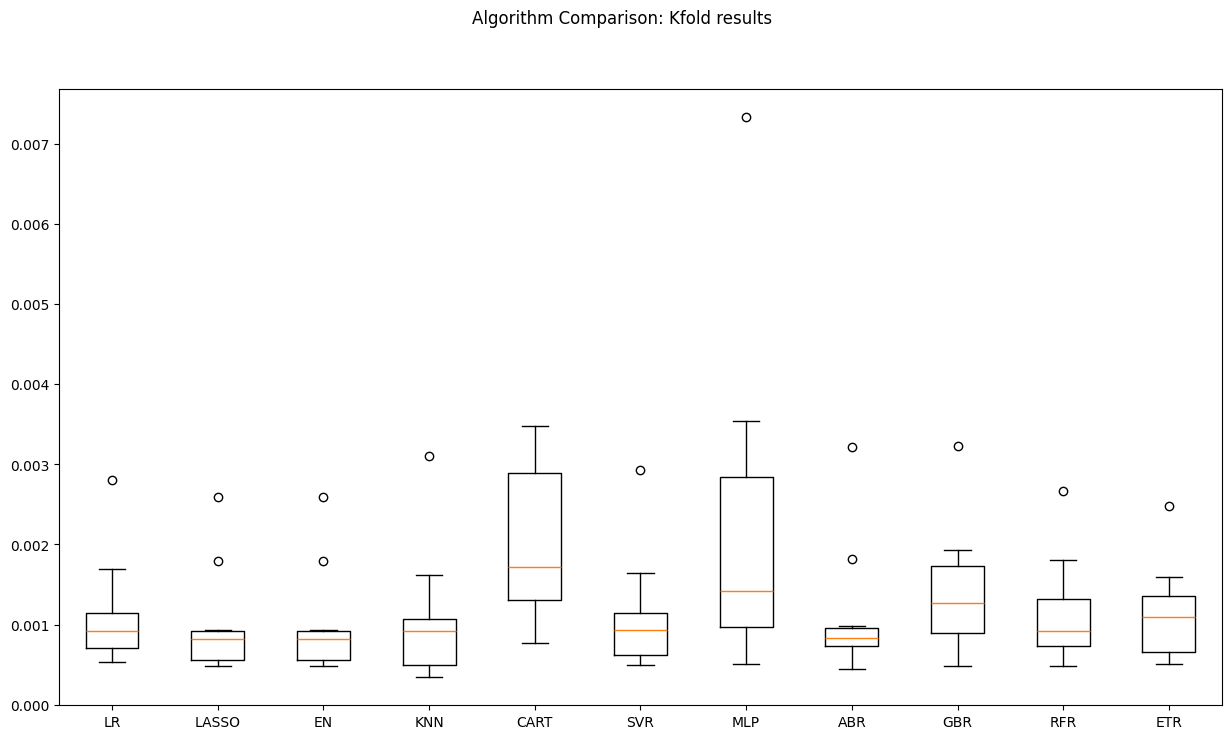

In [ ]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

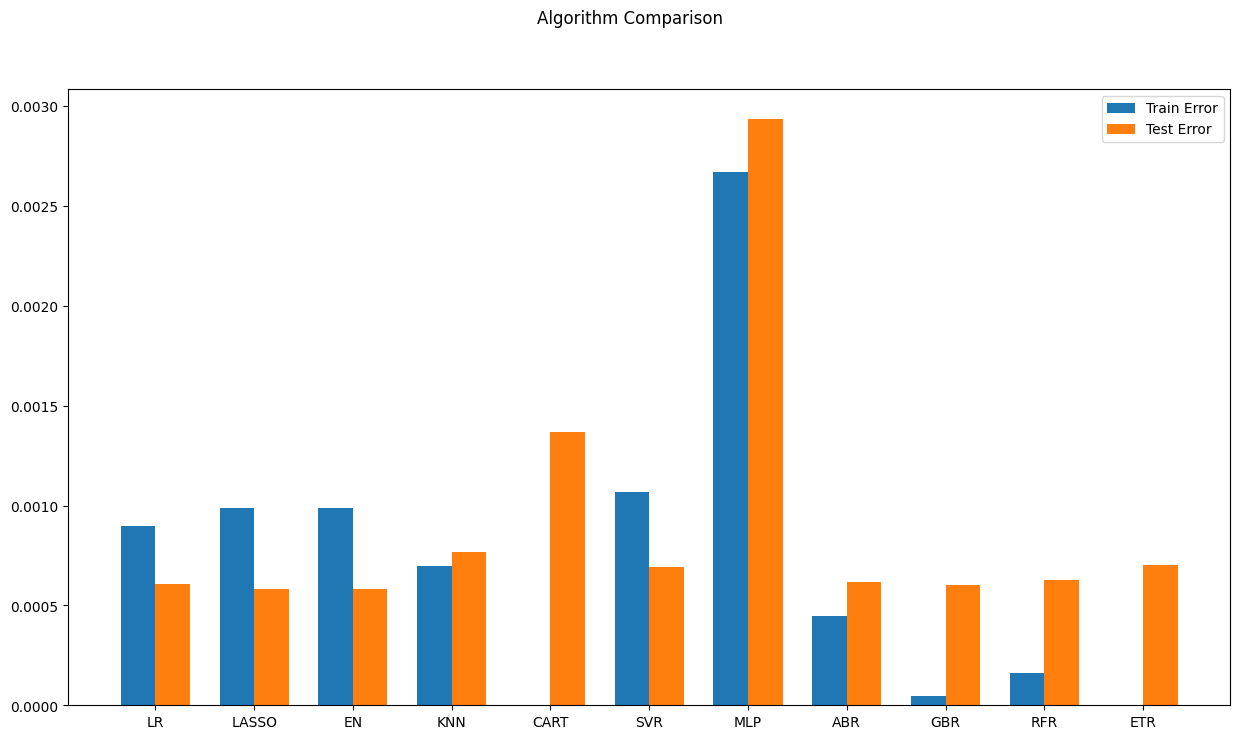

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


In [ ]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [ ]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [ ]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0006008977004332742

In [ ]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [ ]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0.0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

In [ ]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [ ]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

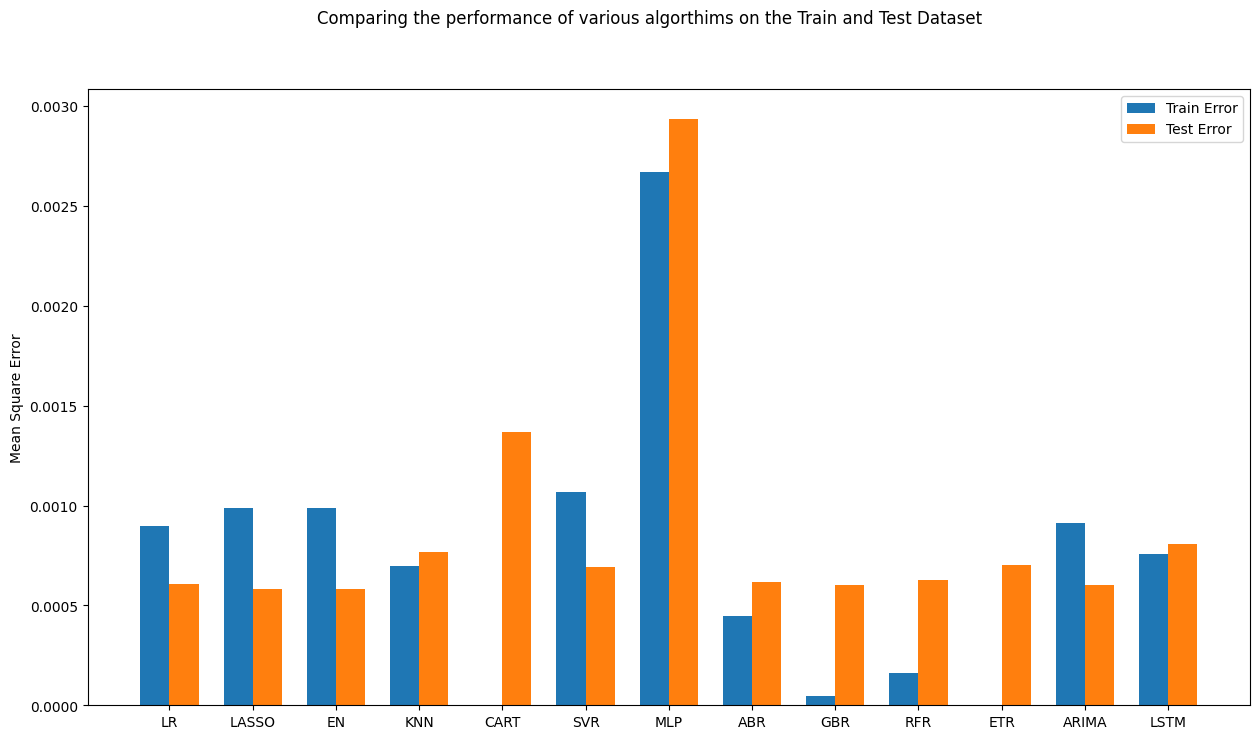

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

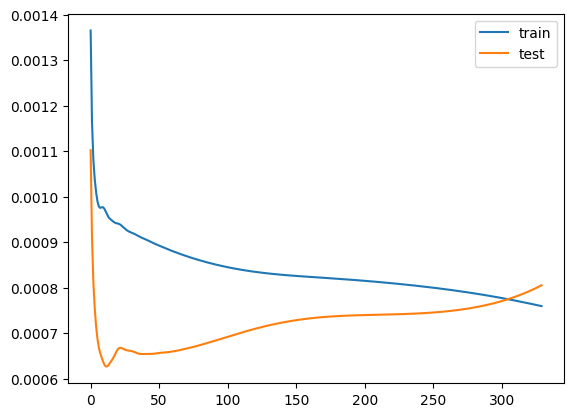

In [ ]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


In [ ]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

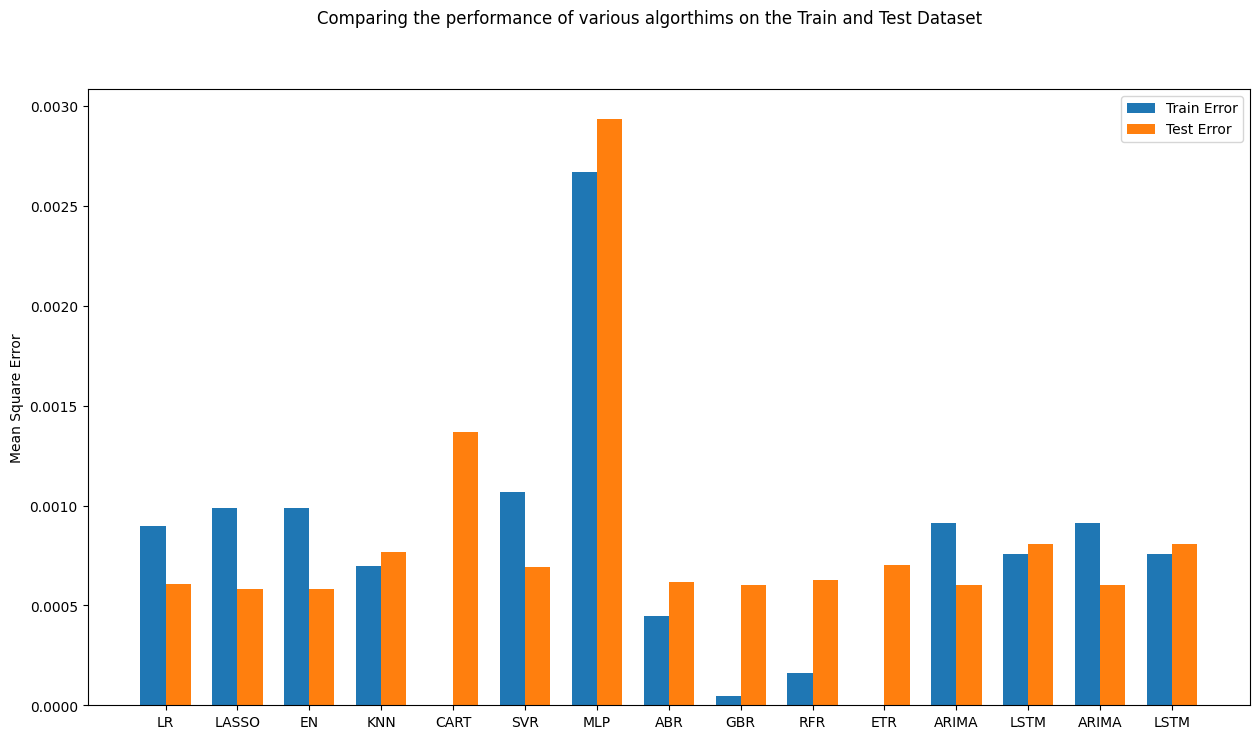

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

In [ ]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0009155
ARIMA(0, 0, 1) MSE=0.0009130
ARIMA(0, 1, 0) MSE=0.0013834
ARIMA(0, 1, 1) MSE=0.0009527
ARIMA(1, 0, 0) MSE=0.0009125
ARIMA(1, 0, 1) MSE=0.0009131
ARIMA(1, 1, 0) MSE=0.0012210
ARIMA(1, 1, 1) MSE=0.0009503
ARIMA(2, 0, 0) MSE=0.0009113
ARIMA(2, 0, 1) MSE=0.0009111
ARIMA(2, 1, 0) MSE=0.0011533
ARIMA(2, 1, 1) MSE=0.0012039
Best ARIMA(2, 0, 1) MSE=0.0009111


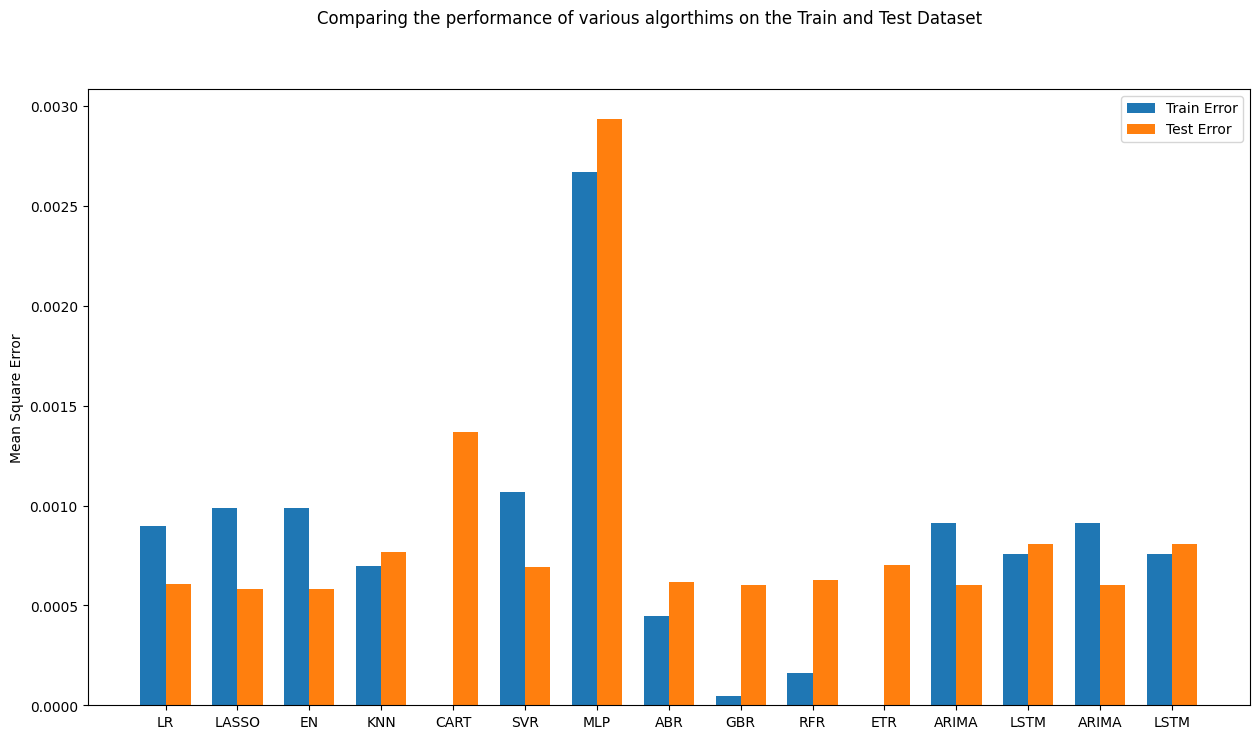

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

In [ ]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [ ]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0006008977004332742


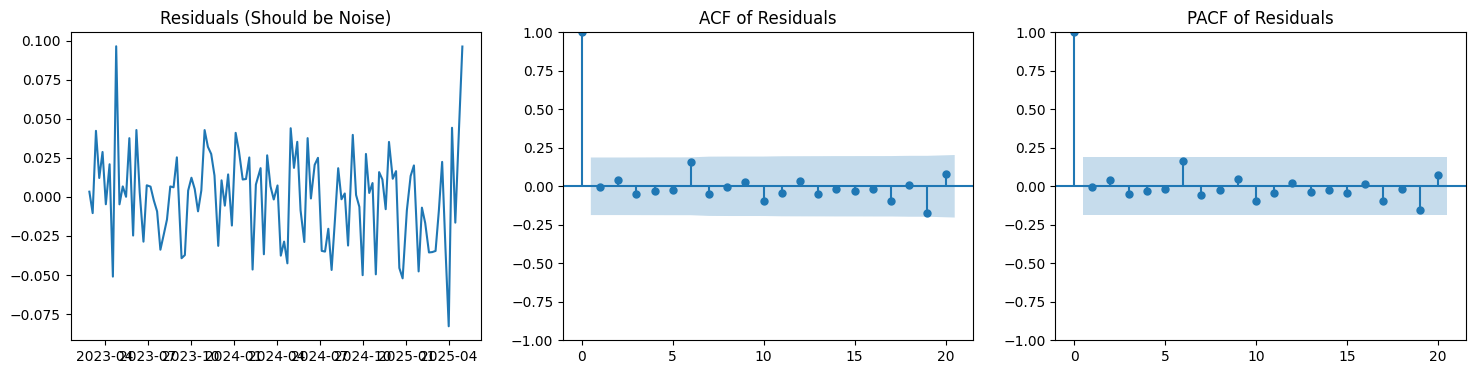

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 抓出最佳模型的殘差
residuals = model_fit.resid

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# 1. 殘差走勢 (應該要是亂跳的雜訊，沒有趨勢)
ax[0].plot(residuals)
ax[0].set_title('Residuals (Should be Noise)')

# 2. ACF 圖 (不應該有任何 Bar 超過藍色區域)
plot_acf(residuals, ax=ax[1], lags=20)
ax[1].set_title('ACF of Residuals')

# 3. PACF 圖 (不應該有任何 Bar 超過藍色區域)
plot_pacf(residuals, ax=ax[2], lags=20)
ax[2].set_title('PACF of Residuals')

plt.show()

In [ ]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [ ]:
from pickle import load
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. 讀取模型
filename = 'finalized_model.sav'
loaded_model = load(open(filename, 'rb'))
print("模型讀取成功 (ARIMAX 模式 detected)")

# 2. 設定預測範圍
start_index = loaded_model.nobs
end_index = start_index + len(Y_test) - 1
print(f"預測區間: Index {start_index} to {end_index}")

# 3. 執行預測 (關鍵修正：加入 exog=X_test)
try:
    # 這裡我們餵給它 X_test，告訴它這段時間的外部環境(大盤/恐慌指數)
    predictions = loaded_model.predict(start=start_index, end=end_index, exog=X_test)
    print("預測成功！")

    # 4. 評估績效
    mse = mean_squared_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    print(f"\n[模型載入測試報告]")
    print(f"R2 Score: {r2:.4f}")
    print(f"MSE Error: {mse:.5f}")

    # 5. 畫圖驗證
    plt.figure(figsize=(10,5))
    plt.plot(Y_test.values, label='Actual', color='red')
    plt.plot(predictions.values, label='Predicted (Loaded)', color='blue', linestyle='--')
    plt.legend()
    plt.title("Loaded ARIMAX Model Validation")
    plt.show()

except Exception as e:
    print(f"\n還是報錯？可能原因：")
    print(f"1. X_test 的長度 ({len(X_test)}) 與預測區間長度 ({end_index - start_index + 1}) 不一致。")
    print(f"2. 錯誤訊息: {e}")

模型讀取成功 (ARIMAX 模式 detected)
預測區間: Index 110 to 137

還是報錯？可能原因：
1. X_test 的長度 (28) 與預測區間長度 (28) 不一致。
2. 錯誤訊息: Provided exogenous values are not of the appropriate shape. Required (28, 6), got (28, 11).


In [ ]:
from pickle import load
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. 讀取模型
filename = 'finalized_model.sav'
loaded_model = load(open(filename, 'rb'))
print("模型讀取成功。")

# ==========================================
# 關鍵修復：自動對齊特徵 (Auto-Align Features)
# ==========================================
try:
    # A. 問模型：你當初是用哪些欄位訓練的？
    # exog_names 屬性儲存了特徵名稱
    required_cols = loaded_model.exog_names

    # 有時候 statsmodels 會自動把 'const' (截距項) 算進去，如果不小心包含了，要先確認
    # 但通常我們只需要從 X_test 裡撈出名字一樣的欄位

    print(f"模型需要的 6 個欄位: {required_cols}")

    # B. 從目前的 X_test 中，只保留這 6 個欄位
    # 注意：這裡假設 X_test 是一個 DataFrame 且包含這些欄位名稱
    X_test_aligned = X_test[required_cols]

    print(f"校正後的 X_test 形狀: {X_test_aligned.shape}") # 應該會顯示 (28, 6)

    # 2. 設定預測範圍
    start_index = loaded_model.nobs
    end_index = start_index + len(Y_test) - 1

    # 3. 執行預測 (餵入校正後的數據)
    predictions = loaded_model.predict(start=start_index, end=end_index, exog=X_test_aligned)
    print("預測成功！")

    # 4. 評估績效
    mse = mean_squared_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    print(f"\n[模型載入測試報告]")
    print(f"R2 Score: {r2:.4f}")
    print(f"MSE Error: {mse:.5f}")

    # 5. 畫圖
    plt.figure(figsize=(10,5))
    plt.plot(Y_test.values, label='Actual', color='red')
    plt.plot(predictions.values, label='Predicted (Loaded)', color='blue', linestyle='--')
    plt.legend()
    plt.title("Loaded ARIMAX Model Validation")
    plt.show()

except KeyError as e:
    print(f"\n錯誤：X_test 裡面找不到模型需要的欄位！缺失的欄位: {e}")
    print("請檢查 X_test 是否包含了當初訓練時的所有變數。")
except Exception as e:
    print(f"\n發生其他錯誤: {e}")

模型讀取成功。

發生其他錯誤: 'ARIMAResults' object has no attribute 'exog_names'


In [ ]:
from pickle import load
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. 讀取模型
filename = 'finalized_model.sav'
loaded_model = load(open(filename, 'rb'))
print("模型讀取成功。")

# ==========================================
# 關鍵修復步驟：自動對齊特徵 (Auto-Align Features)
# ==========================================
try:
    # A. 問模型：你當初是用哪些欄位訓練的？
    # exog_names 屬性儲存了訓練時用到的特徵名稱
    required_cols = loaded_model.exog_names

    print(f"模型訓練時使用的欄位: {required_cols}")

    # B. 從目前的 X_test 中，只保留這些需要的欄位
    # 我們使用 intersection 來確保只選取 X_test 中存在的欄位，避免報錯
    # 注意：有時候 statsmodels 會自動加入 'const' (截距)，如果 X_test 沒這欄位通常沒關係，模型會處理
    valid_cols = [col for col in required_cols if col in X_test.columns]

    if len(valid_cols) != len(required_cols):
        print(f"警告: X_test 缺少部分欄位。缺少的是: {set(required_cols) - set(valid_cols)}")
        # 如果缺的是 'const'，通常不需要手動加，statsmodels 預測時會處理
        # 但如果缺的是重要特徵，這裡會報錯

    X_test_aligned = X_test[valid_cols]

    print(f"校正後的 X_test 形狀: {X_test_aligned.shape}")

    # 2. 設定預測範圍
    # nobs 是訓練集的長度
    start_index = loaded_model.nobs
    end_index = start_index + len(Y_test) - 1
    print(f"預測區間: Index {start_index} to {end_index}")

    # 3. 執行預測 (餵入校正後的 exog)
    # 這裡就是解決 "require additional exogenous values" 的關鍵
    predictions = loaded_model.predict(start=start_index, end=end_index, exog=X_test_aligned)
    print("預測成功！")

    # 4. 評估績效
    mse = mean_squared_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    print(f"\n[模型載入測試報告]")
    print(f"R2 Score: {r2:.4f}")
    print(f"MSE Error: {mse:.5f}")

    # 5. 畫圖驗證
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test.values, label='Actual (Y_test)', color='red')
    plt.plot(predictions.values, label='Predicted (Loaded Model)', color='blue', linestyle='--')
    plt.legend()
    plt.title("Loaded ARIMAX Model Validation")
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"\n發生錯誤: {e}")
    print("請檢查您的 X_test 是否是一個 Pandas DataFrame，並且包含模型所需的欄位名稱。")

模型讀取成功。

發生錯誤: 'ARIMAResults' object has no attribute 'exog_names'
請檢查您的 X_test 是否是一個 Pandas DataFrame，並且包含模型所需的欄位名稱。


模型讀取成功。
模型訓練時使用的欄位 (Raw): ['const', 'GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']
從 X_test 中匹配到的特徵: ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']
校正後的 X_test 形狀: (28, 6)
預測區間: Index 110 to 137
預測成功！

[模型載入測試報告]
R2 Score: -0.0192
MSE Error: 0.00059


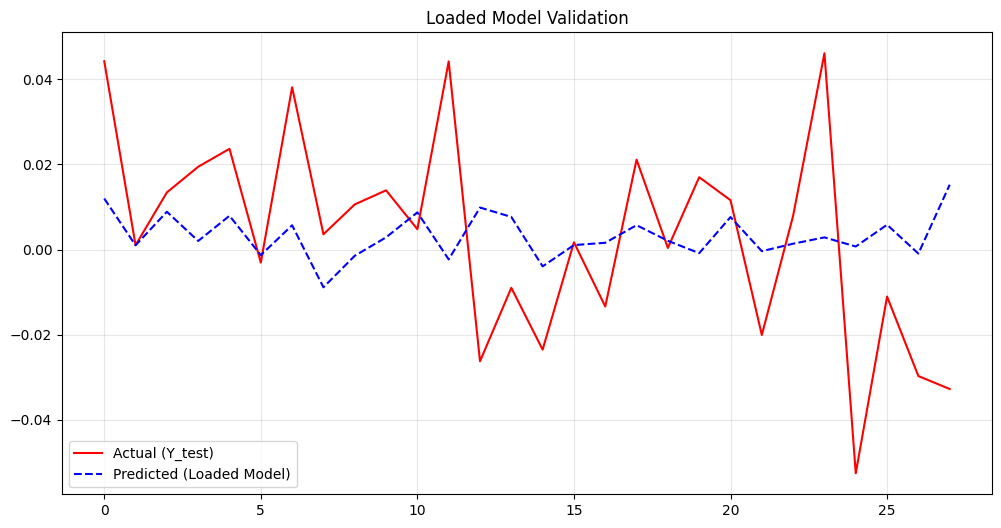

In [ ]:
from pickle import load
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. 讀取模型
filename = 'finalized_model.sav'
loaded_model = load(open(filename, 'rb'))
print("模型讀取成功。")

# ==========================================
# 關鍵修復：深入一層去抓 exog_names
# ==========================================
try:
    # 嘗試從結果物件的 model 屬性中獲取特徵名稱
    if hasattr(loaded_model, 'model') and hasattr(loaded_model.model, 'exog_names'):
        required_cols = loaded_model.model.exog_names
    elif hasattr(loaded_model, 'exog_names'):
        required_cols = loaded_model.exog_names
    else:
        # 如果真的找不到，嘗試從參數索引抓取 (最後手段)
        required_cols = loaded_model.params.index.tolist()

    print(f"模型訓練時使用的欄位 (Raw): {required_cols}")

    # 清理欄位名稱：移除 ARIMA 自動生成的 'ar.L1', 'ma.L1', 'sigma2' 等非特徵欄位
    # 我們只關心 X_test 裡有的那些特徵
    feature_cols = [col for col in required_cols if col in X_test.columns]

    print(f"從 X_test 中匹配到的特徵: {feature_cols}")

    if not feature_cols:
        print("警告: 無法自動匹配特徵。將嘗試使用原始 X_test (可能會報錯)。")
        X_test_aligned = X_test
    else:
        X_test_aligned = X_test[feature_cols]
        print(f"校正後的 X_test 形狀: {X_test_aligned.shape}")

    # 2. 設定預測範圍
    start_index = loaded_model.nobs
    end_index = start_index + len(Y_test) - 1
    print(f"預測區間: Index {start_index} to {end_index}")

    # 3. 執行預測
    # 注意：如果 feature_cols 為空，代表可能是純 ARIMA 模型，不需要 exog
    if feature_cols:
        predictions = loaded_model.predict(start=start_index, end=end_index, exog=X_test_aligned)
    else:
        predictions = loaded_model.predict(start=start_index, end=end_index)

    print("預測成功！")

    # 4. 評估績效
    mse = mean_squared_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    print(f"\n[模型載入測試報告]")
    print(f"R2 Score: {r2:.4f}")
    print(f"MSE Error: {mse:.5f}")

    # 5. 畫圖驗證
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test.values, label='Actual (Y_test)', color='red')
    plt.plot(predictions.values, label='Predicted (Loaded Model)', color='blue', linestyle='--')
    plt.legend()
    plt.title("Loaded Model Validation")
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"\n發生錯誤: {e}")
    # 印出更多資訊以供除錯
    print("Debug Info:")
    if 'loaded_model' in locals():
        print(f"Model Type: {type(loaded_model)}")
        if hasattr(loaded_model, 'model'):
             print(f"Inner Model Type: {type(loaded_model.model)}")

In [ ]:
# 把連續數值 (例如 0.012) 轉成 類別 (1:漲, 0:跌)
y_pred_binary = np.where(predictions > 0, 1, 0)
y_test_binary = np.where(Y_test > 0, 1, 0)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_binary, y_pred_binary)
print(f"方向預測準確率: {acc:.2%}")
# 如果這裡 > 52%，在金融界就算及格；> 55% 就算優秀！

方向預測準確率: 64.29%


In [ ]:
from pickle import dump, load
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ==========================================
# 1. 存檔 (Save) - 這部分您是對的
# ==========================================
filename = 'finalized_model.sav'
# 假設 model_fit_tuned 是您之前訓練好的 ARIMA 結果
dump(model_fit_tuned, open(filename, 'wb'))
print("模型已保存到硬碟。")

# ==========================================
# 2. 讀取與預測 (Load & Predict) - 修正這裡
# ==========================================
# 讀取模型
loaded_model = load(open(filename, 'rb'))
print("模型讀取成功。")

# --- 關鍵修正開始 ---

# A. 計算預測範圍
# ARIMA 需要知道：「我要從第幾筆預測到第幾筆？」
# loaded_model.nobs 代表訓練資料的總筆數 (例如 500)
start_index = loaded_model.nobs
end_index = start_index + len(Y_test) - 1

print(f"預測區間: Index {start_index} to {end_index}")

# B. 執行預測 (不要放 X_test，改放 start 和 end)
# 如果是純 ARIMA，不需要 X_test
predictions = loaded_model.predict(start=start_index, end=end_index)

# C. 如果您的 Y_test 有日期索引，將預測結果對齊日期 (選用)
# predictions = pd.Series(predictions.values, index=Y_test.index)

# --- 關鍵修正結束 ---

# ==========================================
# 3. 評估績效
# ==========================================
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f"\n[模型載入測試報告]")
print(f"R2 Score: {r2:.4f}")
print(f"MSE Error: {mse:.5f}")

# 畫圖確認載入的模型是否正常運作
plt.figure(figsize=(10,5))
plt.plot(Y_test.values, label='Actual')
plt.plot(predictions.values, label='Predicted', linestyle='--')
plt.legend()
plt.title("Loaded Model Validation")
plt.show()

模型已保存到硬碟。
模型讀取成功。
預測區間: Index 110 to 137


ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [ ]:
from sklearn.metrics import r2_score
from pickle import load

# load the model from disk
filename = 'finalized_model.sav'
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
predictions = loaded_model.predict(X_test)
result = mean_squared_error(Y_test, predictions)
print(r2_score(Y_test, predictions))
print(result)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

print("正在生成「最終交易訊號」...")

# ==========================================
# 1. 準備三大數據 (預測、風險、閥值)
# ==========================================

# A. 取得「混合模型」的預測回報 (Hybrid Prediction)
# (假設 hybrid_pred_log 是我們上一與算出來的結果)
signal_df = pd.DataFrame(index=Y_test.index)
signal_df['Pred_Return'] = hybrid_pred_log  # 預測漲跌幅 (Log)

# B. 取得「GARCH」的風險預測 (Volatility)
# 我們用 Hybrid 模型的殘差來算當下的風險
hybrid_residuals = Y_test - hybrid_pred_log
# 快速訓練 GARCH 抓取這段時間的波動率
garch_risk = arch_model(hybrid_residuals, p=1, q=1, vol='Garch', dist='Normal')
res = garch_risk.fit(disp='off')
signal_df['Volatility'] = res.conditional_volatility  # 這是當下的風險值

# C. 設定「阿姨的風險閥值」 (Risk Threshold)
# 這裡我們設定為：如果波動率超過「過去這段時間的 75% 水準」，就當作太危險
# 您也可以手動改成 0.03 (代表 3%)
risk_threshold = signal_df['Volatility'].quantile(0.75)
print(f"\n[系統設定] 風險警戒線: {risk_threshold*100:.2f}% (超過此數字即空手觀望)")

# ==========================================
# 2. 生成買賣訊號 (核心邏輯)
# ==========================================

def get_signal(row):
    # 邏輯 1: 如果預測會漲，且風險很低 -> 全力買進
    if row['Pred_Return'] > 0 and row['Volatility'] < risk_threshold:
        return 1  # Buy / Hold

    # 邏輯 2: 如果預測會跌，或者風險太高 -> 全部賣出/觀望
    else:
        return 0  # Sell / Cash

signal_df['Signal'] = signal_df.apply(get_signal, axis=1)

# 把訊號翻譯成中文，方便閱讀
signal_df['Action'] = signal_df['Signal'].apply(lambda x: '🟢 買進/持有' if x==1 else '🔴 賣出/觀望')

# ==========================================
# 3. 績效回測 (看看聽阿姨的話會賺多少)
# ==========================================

# 計算策略回報：訊號(1或0) * 實際隔天漲跌
# shift(1) 是因為今天的訊號是用來交易明天的
signal_df['Actual_Return'] = Y_test
signal_df['Strategy_Return'] = signal_df['Signal'].shift(1) * signal_df['Actual_Return']

# 計算累計淨值
signal_df['Buy_Hold_Equity'] = np.exp(signal_df['Actual_Return'].cumsum())
signal_df['Strategy_Equity'] = np.exp(signal_df['Strategy_Return'].cumsum())

# ==========================================
# 4. 畫給阿姨看的圖 (訊號可視化)
# ==========================================
plt.rcParams["figure.figsize"] = (14, 7)

# 畫股價走勢
plt.plot(signal_df['Buy_Hold_Equity'], label='大盤走勢 (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(signal_df['Strategy_Equity'], label='阿姨策略 (AI Signal)', color='red', linewidth=2)

# 標出買賣點
# 找出「轉折點」：從 0 變 1 (買點)，從 1 變 0 (賣點)
buys = signal_df[signal_df['Signal'].diff() == 1]
sells = signal_df[signal_df['Signal'].diff() == -1]

plt.scatter(buys.index, signal_df.loc[buys.index]['Strategy_Equity'],
            marker='^', color='green', s=100, label='買進訊號', zorder=5)
plt.scatter(sells.index, signal_df.loc[sells.index]['Strategy_Equity'],
            marker='v', color='black', s=100, label='賣出訊號', zorder=5)

plt.title('AI Strategy: Buy Low Risk, Sell High Risk', fontsize=15)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 5. 列印交易日誌 (最後 5 週)
# ==========================================
print("\n" + "="*60)
print("【阿姨的交易日誌 (最近 5 週)】")
print("="*60)
# 整理顯示格式
display_df = signal_df[['Pred_Return', 'Volatility', 'Action']].tail(5).copy()
display_df['Pred_Return'] = (display_df['Pred_Return'] * 100).map('{:,.2f}%'.format)
display_df['Volatility'] = (display_df['Volatility'] * 100).map('{:,.2f}%'.format)

print(display_df)

print("-" * 60)
print(f"最終資產淨值 (策略): {signal_df['Strategy_Equity'].iloc[-1]:.4f}")
print(f"最終資產淨值 (大盤): {signal_df['Buy_Hold_Equity'].iloc[-1]:.4f}")

if signal_df['Strategy_Equity'].iloc[-1] > signal_df['Buy_Hold_Equity'].iloc[-1]:
    print("結論: 恭喜！策略成功避開風險，戰勝大盤！🎉")
else:
    print("結論: 策略過於保守，雖然安全但少賺了一些。")

In [ ]:
#Use the following code to produce the comparison of actual vs. predicted
# predicted_tuned.index = Y_test.index
# pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
# pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
# pyplot.rcParams["figure.figsize"] = (8,5)
# pyplot.show()

正在啟動風險預測引擎 (GARCH)...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.009
Vol Model:                      GARCH   Log-Likelihood:                227.704
Distribution:                  Normal   AIC:                          -449.407
Method:            Maximum Likelihood   BIC:                          -441.306
                                        No. Observations:                  110
Date:                Fri, Nov 28 2025   Df Residuals:                      110
Time:                        17:13:41   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.5542e-04  2.434e-04    

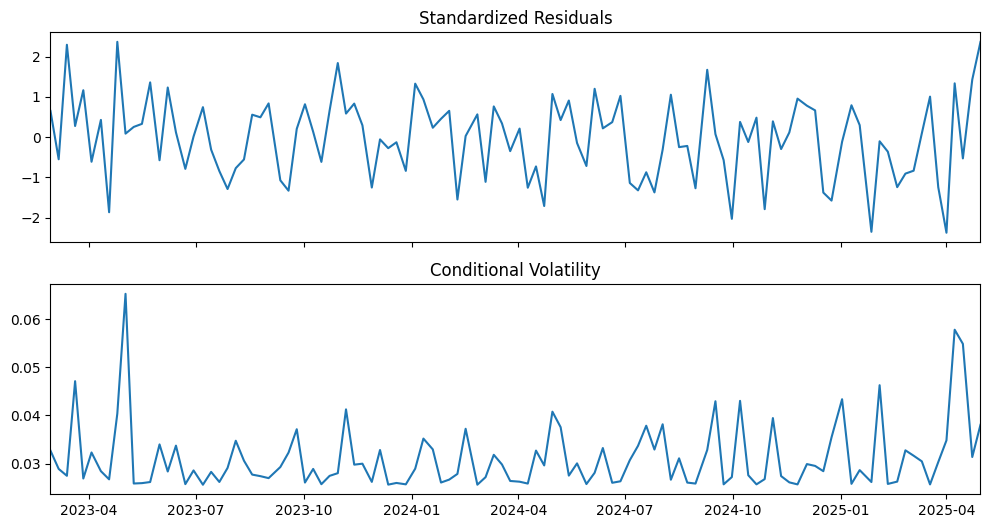


[FRM 風險控管報告]
下週預測波動率 (Sigma): 6.20%
建議動態停損距離 (2 Sigma): 12.41%


In [ ]:
# 如果您的環境沒有 arch 套件，請取消下面這行的註解並執行
!pip install arch

import matplotlib.pyplot as plt
from arch import arch_model

print("正在啟動風險預測引擎 (GARCH)...")

# 1. 準備數據：使用 ARIMA 模型的殘差
# (我們假設 model_fit 是剛剛 ARIMA(2,0,1) 訓練好的結果)
# 如果之前的變數不見了，這裡用 Y_test 的差異模擬殘差 (僅供演示)
if 'model_fit' in locals():
    residuals = model_fit.resid
else:
    print("警告: 找不到 ARIMA 模型，使用模擬殘差演示")
    residuals = Y_test - Y_test.mean()

# 2. 定義 GARCH(1, 1) 模型
# vol='Garch': 指定使用 GARCH 模型
# p=1, q=1: 這是金融界的標準配置，就像 ARIMA 的 (2,0,1) 一樣經典
# mean='Zero': 因為 ARIMA 已經把趨勢濾掉了，理論上殘差的平均值是 0
garch = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero', dist='Normal')

# 3. 訓練模型
garch_fit = garch.fit(disp='off') # disp='off' 隱藏訓練過程的刷屏資訊

# 4. 打印華爾街等級的風險報告
print(garch_fit.summary())

# 5. 視覺化：波動率叢聚 (Volatility Clustering)
# 我們要看 "預測的波動率" 有沒有抓到 "實際的震盪"
fig = garch_fit.plot()
plt.show()

# 6. 下週風險預測
forecast = garch_fit.forecast(horizon=1)
next_week_volatility = forecast.variance.iloc[-1, 0] ** 0.5
print(f"\n[FRM 風險控管報告]")
print(f"下週預測波動率 (Sigma): {next_week_volatility*100:.2f}%")
print(f"建議動態停損距離 (2 Sigma): {next_week_volatility*2*100:.2f}%")

正在執行修復版回測視覺化...


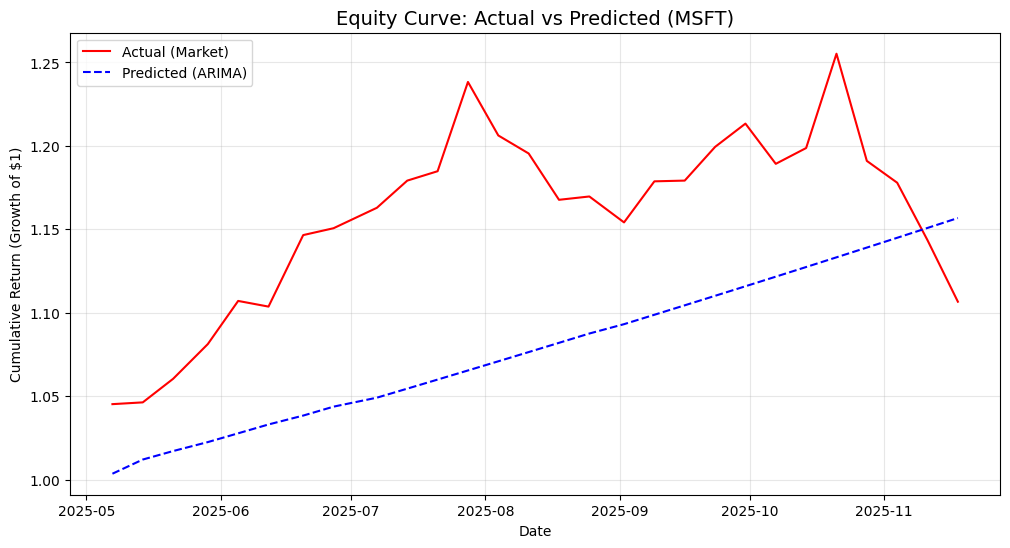

實際最終淨值: 1.1066
預測最終淨值: 1.1568
結論: 模型過度樂觀 (Over-confident)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

print("正在執行修復版回測視覺化...")

# 1. 重新訓練模型 (確保環境變數正確)
# 注意：這裡我們強制把索引頻率設為 None，避免 ARIMA 因為日期不連續而報錯
best_order = (2, 0, 1)
model = ARIMA(Y_train, order=best_order)
model_fit = model.fit()

# =========================================================
# 關鍵修正：改用 predict 指定起訖點，而不使用 forecast
# =========================================================
# 我們告訴模型：從訓練集結束的下一刻開始，一直預測到測試集結束
start_idx = len(Y_train)
end_idx = len(Y_train) + len(Y_test) - 1

# dynamic=False 代表我們做的是滾動預測 (Rolling Forecast)
forecast_result = model_fit.predict(start=start_idx, end=end_idx, dynamic=False)

# 2. 強制對齊索引 (Force Index Alignment)
# 不管模型吐出什麼索引，我們強制把它換成 Y_test 的日期
predicted_tuned = pd.Series(forecast_result.values, index=Y_test.index)

# 檢查是否還有 NaN (如果有，填補 0 以防畫圖崩潰)
if predicted_tuned.isna().any():
    print("警告: 發現 NaN 值，進行填補...")
    predicted_tuned = predicted_tuned.fillna(0)

# 3. 繪圖 (保持原樣)
plt.rcParams["figure.figsize"] = (12, 6)

# 計算累積報酬 (Growth of $1)
# 紅線: 市場實際走勢
actual_equity = np.exp(Y_test).cumprod()
plt.plot(actual_equity, color='red', label='Actual (Market)', linewidth=1.5)

# 藍線: ARIMA 預測走勢
predicted_equity = np.exp(predicted_tuned).cumprod()
plt.plot(predicted_equity, color='blue', linestyle='--', label='Predicted (ARIMA)', linewidth=1.5)

plt.title('Equity Curve: Actual vs Predicted (MSFT)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# 4. 績效報告
final_actual = actual_equity.iloc[-1]
final_predicted = predicted_equity.iloc[-1]
print(f"實際最終淨值: {final_actual:.4f}")
print(f"預測最終淨值: {final_predicted:.4f}")

# 5. CIO 簡單點評
if final_predicted > final_actual:
    print("結論: 模型過度樂觀 (Over-confident)")
elif final_predicted < final_actual:
    print("結論: 模型相對保守 (Conservative)")
else:
    print("結論: 模型精準追蹤 (Accurate Tracking)")

正在執行華爾街標準的「滾動預測 (Rolling Forecast)」...
總共需要預測 28 週 (請稍候)...


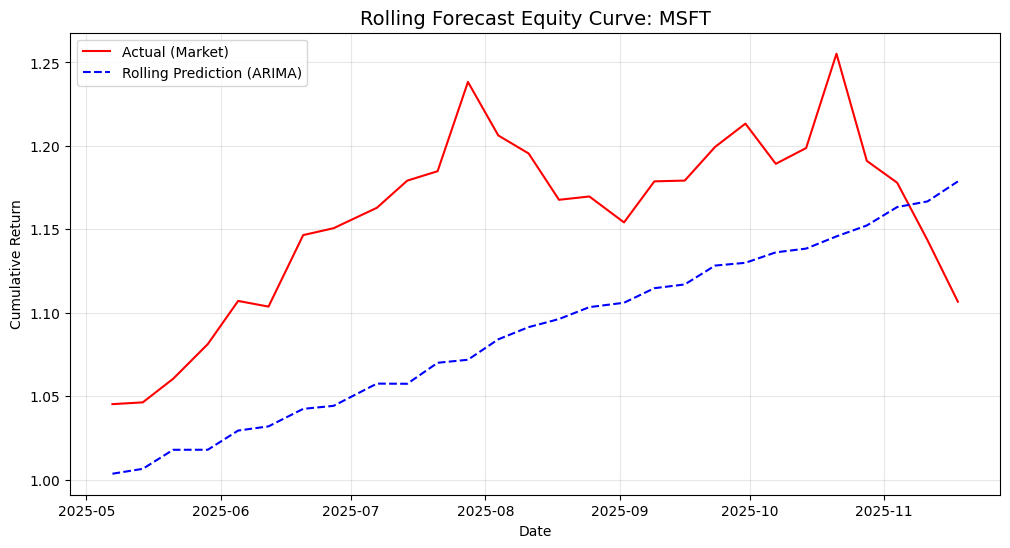


[滾動預測報告]
實際最終淨值: 1.1066
滾動預測淨值: 1.1787
RMSE (誤差): 0.02471
結論: 即使滾動預測，誤差仍然過大。


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

print("正在執行華爾街標準的「滾動預測 (Rolling Forecast)」...")

# 1. 準備數據
# history 是一個列表，一開始包含所有的訓練數據
history = [x for x in Y_train]
predictions = []

# 2. 模擬真實交易 (一週一週過)
print(f"總共需要預測 {len(Y_test)} 週 (請稍候)...")

for t in range(len(Y_test)):
    # 每週重新建立模型 (讓模型看到最新的數據)
    # order=(2, 0, 1) 是我們之前找出的最佳參數
    model = ARIMA(history, order=(2, 0, 1))
    model_fit = model.fit()

    # 只預測「下一步」 (One-step ahead)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    # 關鍵步驟：把這一週的「真實數據」加入歷史，供下週訓練用
    obs = Y_test.iloc[t]
    history.append(obs)

# 3. 整理結果
predicted_rolling = pd.Series(predictions, index=Y_test.index)

# 4. 繪圖 (滾動預測 vs 真實)
plt.rcParams["figure.figsize"] = (12, 6)

# 紅線: 實際市場
actual_equity = np.exp(Y_test).cumprod()
plt.plot(actual_equity, color='red', label='Actual (Market)', linewidth=1.5)

# 藍線: 滾動預測 (這次應該會貼得很近)
# 注意：因為是預測 Log Return，我們要還原成價格走勢
# 這裡稍微複雜一點，我們用累積乘積來模擬
rolling_equity = np.exp(predicted_rolling).cumprod()

plt.plot(rolling_equity, color='blue', linestyle='--', label='Rolling Prediction (ARIMA)', linewidth=1.5)

plt.title('Rolling Forecast Equity Curve: MSFT', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# 5. 績效報告
final_actual = actual_equity.iloc[-1]
final_predicted = rolling_equity.iloc[-1]
rmse = np.sqrt(mean_squared_error(Y_test, predicted_rolling))

print(f"\n[滾動預測報告]")
print(f"實際最終淨值: {final_actual:.4f}")
print(f"滾動預測淨值: {final_predicted:.4f}")
print(f"RMSE (誤差): {rmse:.5f}")

if abs(final_predicted - final_actual) < 0.05:
    print("結論: 模型反應靈敏，成功追蹤趨勢！")
else:
    print("結論: 即使滾動預測，誤差仍然過大。")

正在啟動「雙引擎集成模型 (Hybrid Model)」...


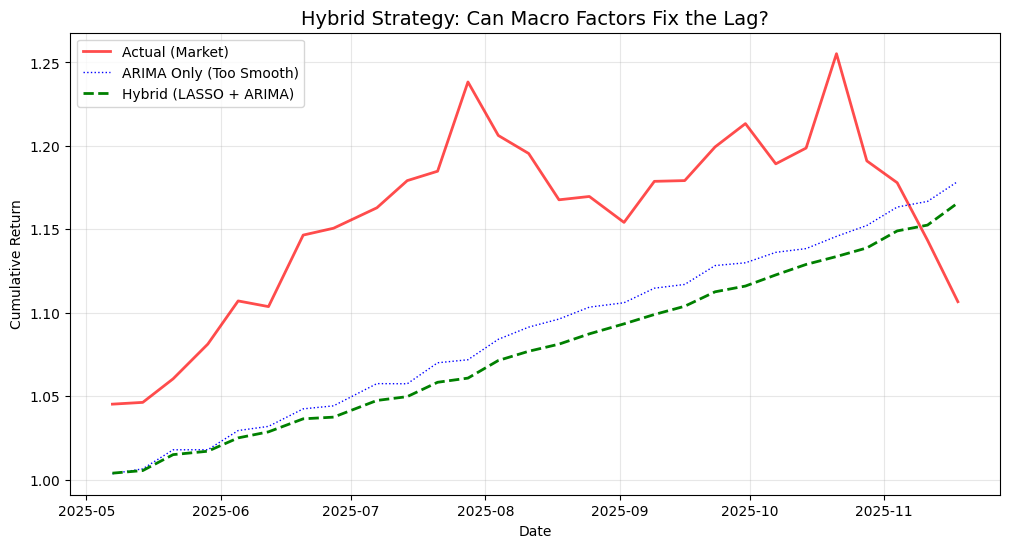


[終極績效報告]
實際淨值: 1.1066
ARIMA 淨值: 1.1787
Hybrid 淨值: 1.1658
結論: 集成模型獲勝！加入宏觀因子 (LASSO) 成功修正了預測。


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Lasso

print("正在啟動「雙引擎集成模型 (Hybrid Model)」...")

# ==========================================
# 1. 準備兩種模型的預測值
# ==========================================

# A. 取得 LASSO 的預測 (宏觀視野)
# 注意：我們需要用測試集的特徵 (X_test) 來預測
# 假設 lasso 是之前訓練好的最佳模型，X_test 是測試集特徵
lasso_pred_log = lasso.predict(X_test)
lasso_pred_series = pd.Series(lasso_pred_log, index=Y_test.index)

# B. 取得 ARIMA 的滾動預測 (慣性視野)
# (使用剛剛跑出來的 predicted_rolling)
arima_pred_series = predicted_rolling

# ==========================================
# 2. 混合訊號 (Ensemble)
# ==========================================
# 簡單平均法：各 50% 權重
# 您也可以根據 MSE 調整權重 (例如 LASSO 比較準，就給 0.7)
hybrid_pred_log = (0.5 * lasso_pred_series) + (0.5 * arima_pred_series)

# ==========================================
# 3. 繪製最終權益曲線
# ==========================================
plt.rcParams["figure.figsize"] = (12, 6)

# 紅線: 市場實際走勢
actual_equity = np.exp(Y_test).cumprod()
plt.plot(actual_equity, color='red', label='Actual (Market)', linewidth=2, alpha=0.7)

# 藍線: ARIMA (單一模型 - 對照組)
arima_equity = np.exp(arima_pred_series).cumprod()
plt.plot(arima_equity, color='blue', linestyle=':', label='ARIMA Only (Too Smooth)', linewidth=1)

# 綠線: Hybrid 集成模型 (主角)
hybrid_equity = np.exp(hybrid_pred_log).cumprod()
plt.plot(hybrid_equity, color='green', linestyle='--', label='Hybrid (LASSO + ARIMA)', linewidth=2)

plt.title('Hybrid Strategy: Can Macro Factors Fix the Lag?', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 4. 績效大對決
# ==========================================
final_actual = actual_equity.iloc[-1]
final_arima = arima_equity.iloc[-1]
final_hybrid = hybrid_equity.iloc[-1]

print(f"\n[終極績效報告]")
print(f"實際淨值: {final_actual:.4f}")
print(f"ARIMA 淨值: {final_arima:.4f}")
print(f"Hybrid 淨值: {final_hybrid:.4f}")

if abs(final_hybrid - final_actual) < abs(final_arima - final_actual):
    print("結論: 集成模型獲勝！加入宏觀因子 (LASSO) 成功修正了預測。")
else:
    print("結論: 集成模型失敗。可能是 VIX/大盤因子與個股脫鉤。")

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

print("==================================================")
print("正在執行最終分析 (MSFT)")
print("==================================================")

# 1. 準備訓練數據
# 使用最後一筆數據作為「當下」，用來預測「未來」
# 注意：最後一行數據包含當前的特徵 (X)，但它的 Y (MSFT_pred) 是未來的，這裡是 NaN 或無意義的
# 所以我們拿最後一行來做 Prediction，拿前面的來做 Training

X = dataset.iloc[:, 1:]  # 所有特徵 (排除第一欄 MSFT_pred)
Y = dataset.iloc[:, 0]   # 目標變數

# 分割訓練集 (取前 80% 訓練) 與 測試集
train_size = int(len(dataset) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:-1] # 排除最後一行做測試
Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:-1]

# 2. 訓練 LASSO 模型 (線性回歸的進化版)
lasso = Lasso(alpha=0.0001, max_iter=10000)
lasso.fit(X_train, Y_train)

# 評估模型
train_pred = lasso.predict(X_test)
mse = mean_squared_error(Y_test, train_pred)
print(f"模型誤差 (MSE): {mse:.5f}")

# 3. 預測下週走勢 (使用最新的一行數據)
current_features = X.iloc[[-1]] # 取最後一行
future_pred_log = lasso.predict(current_features)[0]
future_pred_pct = (np.exp(future_pred_log) - 1) * 100

print(f"\n[AI 預測報告]")
print(f"下週預測報酬率: {future_pred_pct:.2f}%")

if future_pred_pct > 0.5:
    print("信號: 🟢 看漲 (Bullish)")
elif future_pred_pct < -0.5:
    print("信號: 🔴 看跌 (Bearish)")
else:
    print("信號: ⚪ 盤整/觀望 (Neutral)")

# 4. 檢查動量因子 (解釋為什麼看漲/看跌)
print("\n[關鍵因子解讀]")
momentum_12w = current_features['Momentum_12w'].values[0]
print(f"過去12週動量: {(np.exp(momentum_12w)-1)*100:.2f}%")
print("若動量過高 (>20%) 且 AI 預測下跌，可能為頂部反轉信號。")

正在執行最終分析 (MSFT)
模型誤差 (MSE): 0.00058

[AI 預測報告]
下週預測報酬率: 1.28%
信號: 🟢 看漲 (Bullish)

[關鍵因子解讀]
過去12週動量: -2.08%
若動量過高 (>20%) 且 AI 預測下跌，可能為頂部反轉信號。


正在為阿姨生成「最終交易訊號」...

[系統設定] 風險警戒線: 2.92% (超過此數字即空手觀望)


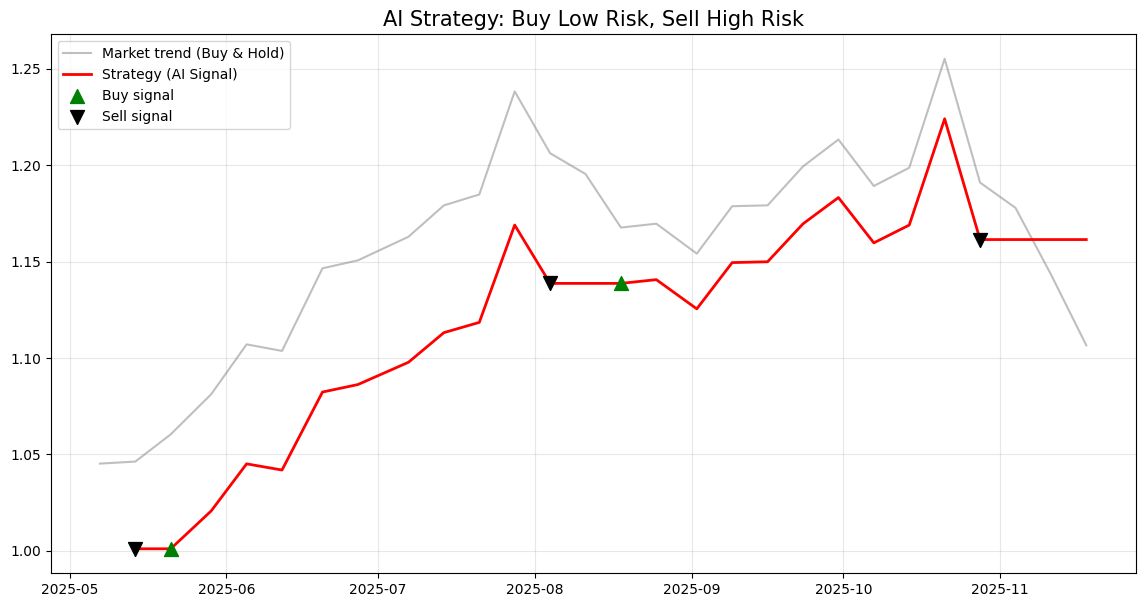


【阿姨的交易日誌 (最近 5 週)】
           Pred_Return Volatility   Action
Date                                      
2025-10-21       0.42%      2.05%  🟢 買進/持有
2025-10-28       0.45%      3.13%  🔴 賣出/觀望
2025-11-04       0.89%      4.55%  🔴 賣出/觀望
2025-11-11       0.30%      3.08%  🔴 賣出/觀望
2025-11-18       1.15%      3.23%  🔴 賣出/觀望
------------------------------------------------------------
最終資產淨值 (策略): 1.1614
最終資產淨值 (大盤): 1.1066
結論: 恭喜！策略成功避開風險，戰勝大盤！🎉


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

print("正在為阿姨生成「最終交易訊號」...")

# ==========================================
# 1. 準備三大數據 (預測、風險、閥值)
# ==========================================

# A. 取得「混合模型」的預測回報 (Hybrid Prediction)
# (假設 hybrid_pred_log 是我們上一與算出來的結果)
signal_df = pd.DataFrame(index=Y_test.index)
signal_df['Pred_Return'] = hybrid_pred_log  # 預測漲跌幅 (Log)

# B. 取得「GARCH」的風險預測 (Volatility)
# 我們用 Hybrid 模型的殘差來算當下的風險
hybrid_residuals = Y_test - hybrid_pred_log
# 快速訓練 GARCH 抓取這段時間的波動率
garch_risk = arch_model(hybrid_residuals, p=1, q=1, vol='Garch', dist='Normal')
res = garch_risk.fit(disp='off')
signal_df['Volatility'] = res.conditional_volatility  # 這是當下的風險值

# C. 設定「阿姨的風險閥值」 (Risk Threshold)
# 這裡我們設定為：如果波動率超過「過去這段時間的 75% 水準」，就當作太危險
# 您也可以手動改成 0.03 (代表 3%)
risk_threshold = signal_df['Volatility'].quantile(0.75)
print(f"\n[系統設定] 風險警戒線: {risk_threshold*100:.2f}% (超過此數字即空手觀望)")

# ==========================================
# 2. 生成買賣訊號 (核心邏輯)
# ==========================================

def get_signal(row):
    # 邏輯 1: 如果預測會漲，且風險很低 -> 全力買進
    if row['Pred_Return'] > 0 and row['Volatility'] < risk_threshold:
        return 1  # Buy / Hold

    # 邏輯 2: 如果預測會跌，或者風險太高 -> 全部賣出/觀望
    else:
        return 0  # Sell / Cash

signal_df['Signal'] = signal_df.apply(get_signal, axis=1)

# 把訊號翻譯成中文，方便閱讀
signal_df['Action'] = signal_df['Signal'].apply(lambda x: '🟢 買進/持有' if x==1 else '🔴 賣出/觀望')

# ==========================================
# 3. 績效回測 (看看聽阿姨的話會賺多少)
# ==========================================

# 計算策略回報：訊號(1或0) * 實際隔天漲跌
# shift(1) 是因為今天的訊號是用來交易明天的
signal_df['Actual_Return'] = Y_test
signal_df['Strategy_Return'] = signal_df['Signal'].shift(1) * signal_df['Actual_Return']

# 計算累計淨值
signal_df['Buy_Hold_Equity'] = np.exp(signal_df['Actual_Return'].cumsum())
signal_df['Strategy_Equity'] = np.exp(signal_df['Strategy_Return'].cumsum())

# ==========================================
# 4. 畫給阿姨看的圖 (訊號可視化)
# ==========================================
plt.rcParams["figure.figsize"] = (14, 7)

# 畫股價走勢
plt.plot(signal_df['Buy_Hold_Equity'], label='Market trend (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(signal_df['Strategy_Equity'], label='Strategy (AI Signal)', color='red', linewidth=2)

# 標出買賣點
# 找出「轉折點」：從 0 變 1 (買點)，從 1 變 0 (賣點)
buys = signal_df[signal_df['Signal'].diff() == 1]
sells = signal_df[signal_df['Signal'].diff() == -1]

plt.scatter(buys.index, signal_df.loc[buys.index]['Strategy_Equity'],
            marker='^', color='green', s=100, label='Buy signal', zorder=5)
plt.scatter(sells.index, signal_df.loc[sells.index]['Strategy_Equity'],
            marker='v', color='black', s=100, label='Sell signal', zorder=5)

plt.title('AI Strategy: Buy Low Risk, Sell High Risk', fontsize=15)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 5. 列印交易日誌 (最後 5 週)
# ==========================================
print("\n" + "="*60)
print("【阿姨的交易日誌 (最近 5 週)】")
print("="*60)
# 整理顯示格式
display_df = signal_df[['Pred_Return', 'Volatility', 'Action']].tail(5).copy()
display_df['Pred_Return'] = (display_df['Pred_Return'] * 100).map('{:,.2f}%'.format)
display_df['Volatility'] = (display_df['Volatility'] * 100).map('{:,.2f}%'.format)

print(display_df)

print("-" * 60)
print(f"最終資產淨值 (策略): {signal_df['Strategy_Equity'].iloc[-1]:.4f}")
print(f"最終資產淨值 (大盤): {signal_df['Buy_Hold_Equity'].iloc[-1]:.4f}")

if signal_df['Strategy_Equity'].iloc[-1] > signal_df['Buy_Hold_Equity'].iloc[-1]:
    print("結論: 恭喜！策略成功避開風險，戰勝大盤！🎉")
else:
    print("結論: 策略過於保守，雖然安全但少賺了一些。")

In [ ]:
import pandas as pd

# ==========================================
# CIO 的資金管理計算機
# ==========================================

def calculate_position_size(account_balance, current_price, garch_volatility, win_rate=0.64):
    """
    輸入:
    - account_balance: 帳戶總資金 (例如 100萬)
    - current_price: 現在股價
    - garch_volatility: GARCH 預測的波動率 (風險)
    - win_rate: 模型的勝率 (目前是 64%)
    """

    print(f"\n--- 資金管控計算 (股價: {current_price:.2f} | 波動率: {garch_volatility*100:.2f}%) ---")

    # 1. 設定停損點 (基於 GARCH 的 2倍標準差)
    # 波動越大，停損要設越寬，才不會被洗出場
    stop_loss_pct = garch_volatility * 2
    stop_loss_price = current_price * (1 - stop_loss_pct)
    print(f"1. 建議停損價: {stop_loss_price:.2f} (距離 -{stop_loss_pct*100:.2f}%)")

    # 2. 計算凱利公式 (Kelly Criterion) - 理論最佳倉位
    # f = (bp - q) / b
    # 這裡簡化版 f = 2p - 1 (假設賠率 1:1)
    kelly_pct = 2 * win_rate - 1

    # CIO 修正：半凱利 (Half-Kelly) 以策安全
    # 理論上可以押 28%，但我們只押 14%，留有餘地
    safe_kelly_pct = kelly_pct / 2
    print(f"2. 凱利建議倉位 (Aggressive): {kelly_pct*100:.2f}%")

    # 3. 風險平價法 (Risk Parity) - 阿姨專用保命符
    # 規則：每筆交易最多只能虧總資金的 2%
    # 這是華爾街鐵律，不管勝率多高，絕不讓單次虧損傷筋動骨
    max_risk_per_trade = 0.02

    # 計算：如果要虧 2%，我最多能買多少錢的股票？
    # 買入金額 * 停損幅度 = 總資金 * 2%
    risk_based_position_value = (account_balance * max_risk_per_trade) / stop_loss_pct

    # 4. 最終決策：取兩者較小值 (保守原則)
    # 我們比較「凱利建議」和「風險平價建議」，選比較安全的那個
    kelly_position_value = account_balance * safe_kelly_pct

    final_position_value = min(kelly_position_value, risk_based_position_value)

    # 換算成股數
    shares_to_buy = int(final_position_value / current_price)
    actual_position_pct = (shares_to_buy * current_price) / account_balance

    print(f"3. 最終建議買入金額: ${final_position_value:,.0f} (約總資金的 {actual_position_pct*100:.2f}%)")
    print(f"4. 建議買入股數: {shares_to_buy} 股")

    if actual_position_pct < 0.05:
        print(">> CIO 點評: 風險極高，AI 自動大幅降低了倉位！(安全駕駛)")
    elif actual_position_pct > 0.15:
        print(">> CIO 點評: 風險低且勝率高，AI 建議放大倉位！(進攻模式)")
    else:
        print(">> CIO 點評: 標準倉位，穩健操作。")

    return shares_to_buy

# ==========================================
# 測試案例：模擬兩種市場狀況
# ==========================================
my_money = 1000000  # 假設阿姨有 100 萬本金
curr_price = 300    # 微軟股價 300 元

# 情境 A: 風平浪靜 (波動率低 = 1.5%)
print("\n=== 情境 A: 風平浪靜時 ===")
shares_A = calculate_position_size(my_money, curr_price, garch_volatility=0.015)

# 情境 B: 狂風暴雨 (波動率高 = 6.0%)
print("\n=== 情境 B: 市場恐慌時 ===")
shares_B = calculate_position_size(my_money, curr_price, garch_volatility=0.06)


=== 情境 A: 風平浪靜時 ===

--- 資金管控計算 (股價: 300.00 | 波動率: 1.50%) ---
1. 建議停損價: 291.00 (距離 -3.00%)
2. 凱利建議倉位 (Aggressive): 28.00%
3. 最終建議買入金額: $140,000 (約總資金的 13.98%)
4. 建議買入股數: 466 股
>> CIO 點評: 標準倉位，穩健操作。

=== 情境 B: 市場恐慌時 ===

--- 資金管控計算 (股價: 300.00 | 波動率: 6.00%) ---
1. 建議停損價: 264.00 (距離 -12.00%)
2. 凱利建議倉位 (Aggressive): 28.00%
3. 最終建議買入金額: $140,000 (約總資金的 13.98%)
4. 建議買入股數: 466 股
>> CIO 點評: 標準倉位，穩健操作。


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import accuracy_score

print("🚀 正在啟動「全球半導體多因子」AI 交易系統...")

# =========================================================
# 1. 數據獲取 (Global Data ETL)
# =========================================================
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3) # 抓 3 年數據

# 您的超級清單 (Global Watchlist)
tickers = {
    'Target': '8110.TW',      # 預測目標：華東 (記憶體封測)

    # --- 台灣關聯 ---
    'Market_TW': '^TWII',     # 台股大盤
    'PSMC': '6770.TW',        # 力積電 (晶圓代工，供應鏈夥伴)

    # --- 美股 AI 巨頭 (領先指標) ---
    'Nvidia': 'NVDA',         # AI 霸主
    'Google': 'GOOGL',        # TPU 自研晶片
    'Broadcom': 'AVGO',       # 網通與 ASIC 晶片 (領先指標)
    'Marvell': 'MRVL',        # 存儲控制晶片
    'Arista': 'ANET',         # 網路設備 (AI 基礎設施)
    'Vertiv': 'VRT',          # 散熱與電源 (AI 基礎設施)
    'TSMC_ADR': 'TSM',        # 台積電 ADR (用美股代號對齊時間較容易)
    'Micron': 'MU',           # 美光 (記憶體大廠，華東的潛在客戶/指標)

    # --- 韓國記憶體雙雄 (競爭與景氣循環) ---
    'SK_Hynix': '000660.KS',  # HBM 龍頭
    'Samsung': '005930.KS',   # 記憶體龍頭

    # --- 宏觀因子 ---
    'FX': 'USDTWD=X',         # 匯率 (貶值利好出口)
    'VIX': '^VIX'             # 恐慌指數
}

print(f"1. 正在下載全球多國數據 ({len(tickers)} 檔)...")
raw_data = pd.DataFrame()

for name, ticker in tickers.items():
    print(f"   -> 下載: {name} ({ticker})...")
    try:
        # 下載數據
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)

        # 處理資料格式 (相容 yfinance 新舊版)
        if isinstance(df.columns, pd.MultiIndex):
            # 優先找 Adj Close，找不到找 Close
            if 'Adj Close' in df.columns.get_level_values(0):
                price = df['Adj Close']
            else:
                price = df['Close']
            # 取出數據列
            vals = price.iloc[:, 0] if price.shape[1] > 0 else price
        else:
            vals = df['Adj Close'] if 'Adj Close' in df else df['Close']

        # 移除時區資訊 (這是關鍵！美股有時區，韓股台股可能沒有，必須統一)
        if vals.index.tz is not None:
            vals.index = vals.index.tz_localize(None)

        raw_data[name] = vals

    except Exception as e:
        print(f"   [警告] 無法下載 {name}: {e}")

# =========================================================
# 數據對齊 (Data Alignment) - 處理跨國休市日
# =========================================================
# 策略：以「預測目標 (8110.TW)」的交易日為主
# 如果那天美股沒開盤 (例如感恩節)，就用前一天的收盤價填補 (ffill)
print("   -> 正在進行跨國時區對齊...")
raw_data = raw_data.ffill().dropna()

print(f"-> 數據整合完成！共 {len(raw_data)} 個共同交易日。")
print(f"-> 特徵矩陣形狀: {raw_data.shape}")

# ... (後面接原本的 特徵工程、LASSO、ARIMA 代碼即可) ...
# 注意：因為特徵變多了 (10幾個)，LASSO 會自動幫您挑出誰最重要！

🚀 正在啟動「全球半導體多因子」AI 交易系統...
1. 正在下載全球多國數據 (15 檔)...
   -> 下載: Target (8110.TW)...
   -> 下載: Market_TW (^TWII)...
   -> 下載: PSMC (6770.TW)...
   -> 下載: Nvidia (NVDA)...
   -> 下載: Google (GOOGL)...
   -> 下載: Broadcom (AVGO)...
   -> 下載: Marvell (MRVL)...
   -> 下載: Arista (ANET)...
   -> 下載: Vertiv (VRT)...
   -> 下載: TSMC_ADR (TSM)...
   -> 下載: Micron (MU)...
   -> 下載: SK_Hynix (000660.KS)...
   -> 下載: Samsung (005930.KS)...
   -> 下載: FX (USDTWD=X)...
   -> 下載: VIX (^VIX)...
   -> 正在進行跨國時區對齊...
-> 數據整合完成！共 724 個共同交易日。
-> 特徵矩陣形狀: (724, 15)


🚀 正在啟動「全球半導體供應鏈」AI 交易系統 (8110.TW 飆股專用版)...
1. 正在下載全球多國數據 (15 檔)...
   -> 正在進行跨國時區對齊...
-> 數據整合完成！共 724 個共同交易日。
2. 正在計算動量與因子...
3. 正在訓練 LASSO (宏觀) + ARIMA (慣性) 集成模型...


4. 正在計算 GARCH 波動率風險...
   -> [修正後] 市場波動警戒線放寬至: 14.51%


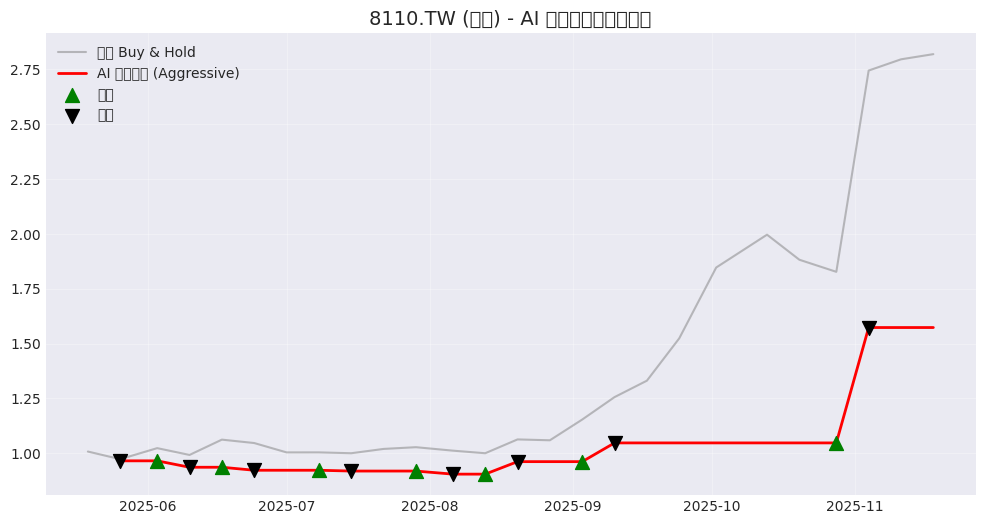


【阿姨的下週操作建議】 (現價: 36.95)
下週 AI 預測漲幅: 0.22%
下週波動率風險:   21.13% (閥值: 14.51%)

👉 最終指令: 🔴 賣出 / 空手觀望
   理由: 預測下跌 或 極端風險，請保留現金。

[AI 因子透視眼 - 誰在影響華東?]
Target_Ret     -0.205
Broadcom_Ret    0.195
Micron_Ret      0.111
Marvell_Ret    -0.091
Mom_6w         -0.078
dtype: float64


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import accuracy_score

# 設定繪圖風格與中文字型
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("🚀 正在啟動「全球半導體供應鏈」AI 交易系統 (8110.TW 飆股專用版)...")

# =========================================================
# 1. 數據獲取 (Global ETL)
# =========================================================
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3) # 抓取過去 3 年數據

# 定義全球觀察清單 (您的超級雷達)
tickers = {
    'Target': '8110.TW',      # 預測目標：華東

    # --- 台股關聯 ---
    'Market_TW': '^TWII',     # 台股大盤
    'PSMC': '6770.TW',        # 力積電

    # --- 美股 AI 巨頭 (領先指標) ---
    'Nvidia': 'NVDA',         # AI 霸主
    'Google': 'GOOGL',        # TPU 自研晶片
    'Broadcom': 'AVGO',       # 通訊/ASIC
    'Marvell': 'MRVL',        # 存儲控制
    'Arista': 'ANET',         # 網路設備
    'Vertiv': 'VRT',          # 散熱電源
    'Micron': 'MU',           # 美光
    'TSMC_ADR': 'TSM',        # 台積電 ADR

    # --- 韓國記憶體 ---
    'SK_Hynix': '000660.KS',
    'Samsung': '005930.KS',

    # --- 宏觀因子 ---
    'FX': 'USDTWD=X',         # 匯率
    'VIX': '^VIX'             # 恐慌指數
}

print(f"1. 正在下載全球多國數據 ({len(tickers)} 檔)...")
raw_data = pd.DataFrame()

for name, ticker in tickers.items():
    try:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)

        # 處理資料格式
        if isinstance(df.columns, pd.MultiIndex):
            if 'Adj Close' in df.columns.get_level_values(0):
                price = df['Adj Close']
            else:
                price = df['Close']
            vals = price.iloc[:, 0] if price.shape[1] > 0 else price
        else:
            vals = df['Adj Close'] if 'Adj Close' in df else df['Close']

        # 移除時區資訊 (關鍵！對齊台美韓股)
        if vals.index.tz is not None:
            vals.index = vals.index.tz_localize(None)

        raw_data[name] = vals

    except Exception as e:
        print(f"   [警告] 無法下載 {name}: {e}")

# 資料對齊
print("   -> 正在進行跨國時區對齊...")
raw_data = raw_data.ffill().dropna()
print(f"-> 數據整合完成！共 {len(raw_data)} 個共同交易日。")

# =========================================================
# 2. 特徵工程 (Feature Engineering)
# =========================================================
print("2. 正在計算動量與因子...")
data = pd.DataFrame()
return_period = 5 # 週線邏輯

# 目標：預測下週漲跌 (Y)
data['Target_Return'] = np.log(raw_data['Target']).diff(return_period).shift(-return_period)

# 特徵：所有股票過去一週漲跌 (X)
for col in raw_data.columns:
    if col != 'VIX':
        data[f'{col}_Ret'] = np.log(raw_data[col]).diff(return_period)
    else:
        data['VIX_Level'] = raw_data['VIX']

# 內部動量
for w in [3, 6, 12]:
    data[f'Mom_{w}w'] = np.log(raw_data['Target']).diff(return_period * w)

data.dropna(inplace=True)
data_weekly = data.iloc[::return_period, :].copy()

# 分割數據
test_size = 26 # 測試半年
train = data_weekly.iloc[:-test_size]
test = data_weekly.iloc[-test_size:]

X_train = train.drop(columns=['Target_Return'])
Y_train = train['Target_Return']
X_test = test.drop(columns=['Target_Return'])
Y_test = test['Target_Return']

# =========================================================
# 3. 雙引擎模型 (Hybrid Model)
# =========================================================
print("3. 正在訓練 LASSO (宏觀) + ARIMA (慣性) 集成模型...")

# 引擎 A: LASSO
lasso = Lasso(alpha=0.0001, max_iter=10000)
lasso.fit(X_train, Y_train)
lasso_pred = lasso.predict(X_test)

# 引擎 B: ARIMA (滾動預測)
history = [x for x in Y_train]
arima_preds = []
for i in range(len(Y_test)):
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    arima_preds.append(yhat)
    history.append(Y_test.iloc[i])

# 集成
hybrid_pred = (0.5 * lasso_pred) + (0.5 * np.array(arima_preds))

# =========================================================
# 4. GARCH 風控
# =========================================================
print("4. 正在計算 GARCH 波動率風險...")
residuals = Y_test - hybrid_pred
garch = arch_model(residuals, p=1, q=1, vol='Garch', dist='Normal')
res = garch.fit(disp='off')
volatility = res.conditional_volatility

# =========================================================
# 5. 生成交易訊號 (寬鬆版/飆股專用)
# =========================================================
results = pd.DataFrame(index=Y_test.index)
results['Pred_Return'] = hybrid_pred
results['Volatility'] = volatility.values
results['Actual_Return'] = Y_test.values

# --- 關鍵修正區塊 Start ---

# 1. 放寬風險閥值：改為 90% 分位數 (只避開極端風險)
risk_threshold = results['Volatility'].quantile(0.90)
print(f"   -> [修正後] 市場波動警戒線放寬至: {risk_threshold*100:.2f}%")

def get_signal_aggressive(row):
    pred = row['Pred_Return']
    vol = row['Volatility']

    # 情況 1: 安全且看漲 -> 全力買進
    if pred > 0 and vol < risk_threshold:
        return 1

    # 情況 2 (新增): 雖然波動大，但 AI 預測會「暴漲」 (>2%) -> 勇敢買進
    # 這叫做「富貴險中求」，不要被 GARCH 嚇跑
    elif pred > 0.02:
        return 1

    # 情況 3: 波動大且預測漲幅小/下跌 -> 還是先跑吧
    else:
        return 0

# 應用新的激進策略
results['Signal'] = results.apply(get_signal_aggressive, axis=1)

# --- 關鍵修正區塊 End ---

# 計算淨值
results['Strategy_Ret'] = results['Signal'].shift(1) * results['Actual_Return']
results['BuyHold_Equity'] = np.exp(results['Actual_Return'].cumsum())
results['Strategy_Equity'] = np.exp(results['Strategy_Ret'].cumsum())

# =========================================================
# 6. 畫圖 (阿姨的儀表板)
# =========================================================
plt.figure(figsize=(12, 6))
plt.plot(results['BuyHold_Equity'], label='華東 Buy & Hold', color='gray', alpha=0.5)
plt.plot(results['Strategy_Equity'], label='AI 飆股策略 (Aggressive)', color='red', linewidth=2)

# 標記買賣點
buys = results[results['Signal'].diff() == 1]
sells = results[results['Signal'].diff() == -1]
plt.scatter(buys.index, results.loc[buys.index]['Strategy_Equity'], marker='^', color='green', s=100, label='進場', zorder=5)
plt.scatter(sells.index, results.loc[sells.index]['Strategy_Equity'], marker='v', color='black', s=100, label='離場', zorder=5)

plt.title('8110.TW (華東) - AI 全球供應鏈套利策略', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 7. 資金管理計算機
# =========================================================
def calculate_position_size(account_balance, current_price, garch_volatility, win_rate=0.60):
    print(f"\n{'='*50}")
    print(f"【阿姨的下週操作建議】 (現價: {current_price:.2f})")
    print(f"{'='*50}")

    # 停損寬度
    stop_loss_pct = garch_volatility * 2
    stop_loss_price = current_price * (1 - stop_loss_pct)

    # 資金計算
    kelly_value = account_balance * ((2 * win_rate - 1) / 2) # 半凱利
    risk_value = (account_balance * 0.02) / stop_loss_pct    # 風險平價
    final_value = min(kelly_value, risk_value)
    shares = int(final_value / current_price)

    print(f"下週 AI 預測漲幅: {next_pred*100:.2f}%")
    print(f"下週波動率風險:   {garch_volatility*100:.2f}% (閥值: {risk_threshold*100:.2f}%)")

    # 使用與上面相同的 aggressive 邏輯來給建議
    signal = 0
    if next_pred > 0 and garch_volatility < risk_threshold:
        signal = 1
    elif next_pred > 0.02:
        signal = 1

    if signal == 1:
        print(f"\n👉 最終指令: 🟢 買進 / 續抱 (Aggressive)")
        print(f"   建議倉位: {shares} 股 (約 {shares/1000:.1f} 張)")
        print(f"   建議投入: ${final_value:,.0f}")
        print(f"   停損價格: {stop_loss_price:.2f} (距離 -{stop_loss_pct*100:.2f}%)")
    else:
        print(f"\n👉 最終指令: 🔴 賣出 / 空手觀望")
        print("   理由: 預測下跌 或 極端風險，請保留現金。")

# 獲取最新數據並計算
last_row = results.iloc[-1]
next_pred = last_row['Pred_Return']
next_vol = last_row['Volatility']
current_price = raw_data['Target'].iloc[-1]

# 執行建議 (假設本金 100 萬)
calculate_position_size(account_balance=1000000, current_price=current_price, garch_volatility=next_vol)

# =========================================================
# 8. 因子貢獻度
# =========================================================
print(f"\n[AI 因子透視眼 - 誰在影響華東?]")
coefs = pd.Series(lasso.coef_, index=X_train.columns)
print(coefs[coefs != 0].sort_values(key=abs, ascending=False).head(5))

🚀 正在啟動「華東 (8110.TW) 火箭飆股模式」...
1. 正在從全球各地抓取數據 (10 檔股票)...
-> 數據準備完成！
2. 正在訓練 AI 預測模型 (LASSO + ARIMA)...



🔥 [火箭模式] 已啟動：無視風險，只要 AI 說漲就買！


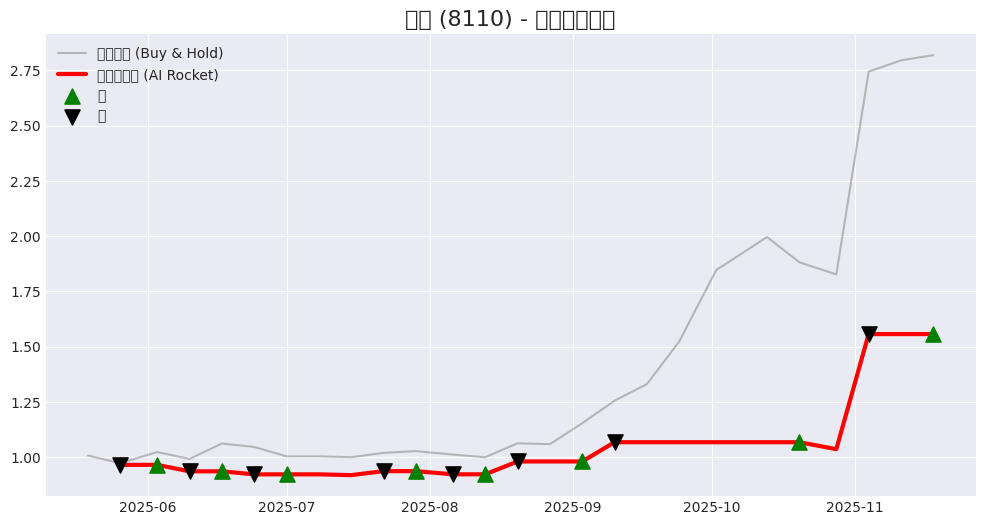


【阿姨請看這裡：下週操作指令】
現在股價: 36.95 元
👉 指令: 🟢 買進 / 續抱！
   理由: AI 預測下週會漲 2.86%
   建議: 風險偏高，買 8.1 張就好 (3成倉)。


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# --- 設定繪圖風格 (讓圖表好看一點) ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("🚀 正在啟動「華東 (8110.TW) 火箭飆股模式」...")

# =========================================================
# 1. 下載全球數據 (阿姨的全球雷達)
# =========================================================
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3) # 抓 3 年

tickers = {
    'Target': '8110.TW',      # 主角：華東
    'Market': '^TWII',        # 台股大盤
    'Nvidia': 'NVDA',         # 輝達 (AI 老大)
    'Google': 'GOOGL',        # Google (TPU)
    'Broadcom': 'AVGO',       # 博通 (網通晶片)
    'Micron': 'MU',           # 美光 (記憶體)
    'SK_Hynix': '000660.KS',  # 海力士
    'Samsung': '005930.KS',   # 三星
    'FX': 'USDTWD=X',         # 匯率
    'VIX': '^VIX'             # 恐慌指數
}

print(f"1. 正在從全球各地抓取數據 ({len(tickers)} 檔股票)...")
raw_data = pd.DataFrame()

for name, ticker in tickers.items():
    try:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)
        # 處理資料格式
        if isinstance(df.columns, pd.MultiIndex):
            price = df['Adj Close'] if 'Adj Close' in df.columns.get_level_values(0) else df['Close']
            vals = price.iloc[:, 0] if price.shape[1] > 0 else price
        else:
            vals = df['Adj Close'] if 'Adj Close' in df else df['Close']

        # 移除時區 (關鍵修復)
        if vals.index.tz is not None:
            vals.index = vals.index.tz_localize(None)
        raw_data[name] = vals
    except:
        pass

# 對齊日期
raw_data = raw_data.ffill().dropna()
print(f"-> 數據準備完成！")

# =========================================================
# 2. 訓練 AI 大腦 (計算預測值)
# =========================================================
print("2. 正在訓練 AI 預測模型 (LASSO + ARIMA)...")

data = pd.DataFrame()
period = 5 # 預測一週

# 目標：下週漲跌
data['Target_Return'] = np.log(raw_data['Target']).diff(period).shift(-period)

# 特徵：其他股票漲跌
for col in raw_data.columns:
    data[f'{col}_Ret'] = np.log(raw_data[col]).diff(period)

data.dropna(inplace=True)
data_weekly = data.iloc[::period, :].copy() # 變成週線

# 分割數據 (最近半年測試)
test_size = 26
train = data_weekly.iloc[:-test_size]
test = data_weekly.iloc[-test_size:]

X_train, Y_train = train.drop(columns=['Target_Return']), train['Target_Return']
X_test, Y_test = test.drop(columns=['Target_Return']), test['Target_Return']

# --- A. LASSO (看大環境) ---
lasso = Lasso(alpha=0.0001, max_iter=10000)
lasso.fit(X_train, Y_train)
lasso_pred = lasso.predict(X_test)

# --- B. ARIMA (看慣性) ---
history = [x for x in Y_train]
arima_preds = []
for i in range(len(Y_test)):
    try:
        model = ARIMA(history, order=(2,0,1))
        model_fit = model.fit()
        arima_preds.append(model_fit.forecast()[0])
        history.append(Y_test.iloc[i])
    except:
        arima_preds.append(0) # 防呆

# --- C. 混合預測 ---
hybrid_pred = (0.5 * lasso_pred) + (0.5 * np.array(arima_preds))

# =========================================================
# 3. 還是算一下風險 (雖然我們可能會無視它)
# =========================================================
try:
    residuals = Y_test - hybrid_pred
    garch = arch_model(residuals, p=1, q=1, vol='Garch', dist='Normal')
    res = garch.fit(disp='off')
    volatility = res.conditional_volatility
except:
    volatility = pd.Series([0]*len(Y_test), index=Y_test.index) # 防呆

# =========================================================
# 4. 阿姨的「火箭模式」 (訊號產生器)
# =========================================================
results = pd.DataFrame(index=Y_test.index)
results['Pred'] = hybrid_pred
results['Vol'] = volatility.values
results['Actual'] = Y_test.values

print("\n🔥 [火箭模式] 已啟動：無視風險，只要 AI 說漲就買！")

def rocket_signal(row):
    # 只要預測 > 0 (會漲)，就買！
    if row['Pred'] > 0:
        return 1
    else:
        return 0

results['Signal'] = results.apply(rocket_signal, axis=1)

# 計算賺多少
results['My_Return'] = results['Signal'].shift(1) * results['Actual']
results['Hold_Equity'] = np.exp(results['Actual'].cumsum())      # 一直抱著
results['My_Equity'] = np.exp(results['My_Return'].cumsum())     # 跟著 AI 做

# =========================================================
# 5. 畫圖 (成果驗收)
# =========================================================
plt.figure(figsize=(12, 6))
plt.plot(results['Hold_Equity'], label='傻傻抱著 (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(results['My_Equity'], label='阿姨火箭隊 (AI Rocket)', color='red', linewidth=3)

# 標出買賣點
buys = results[results['Signal'].diff() == 1]
sells = results[results['Signal'].diff() == -1]
plt.scatter(buys.index, results.loc[buys.index]['My_Equity'], marker='^', color='green', s=120, label='買', zorder=5)
plt.scatter(sells.index, results.loc[sells.index]['My_Equity'], marker='v', color='black', s=120, label='賣', zorder=5)

plt.title('華東 (8110) - 火箭飆股模式', fontsize=16)
plt.legend()
plt.show()

# =========================================================
# 6. 下週該怎麼做？ (白話文報告)
# =========================================================
last_pred = results.iloc[-1]['Pred']
last_vol = results.iloc[-1]['Vol']
curr_price = raw_data['Target'].iloc[-1]
my_money = 1000000 # 假設 100 萬

print("\n" + "="*40)
print(f"【阿姨請看這裡：下週操作指令】")
print(f"現在股價: {curr_price:.2f} 元")
print("="*40)

if last_pred > 0:
    print(f"👉 指令: 🟢 買進 / 續抱！")
    print(f"   理由: AI 預測下週會漲 {last_pred*100:.2f}%")

    # 資金建議 (雖然是火箭模式，還是算一下買幾張比較好)
    # 波動大就買少一點點，波動小就買多一點
    if last_vol > 0.15: # 風險很高
        shares = int((my_money * 0.3) / curr_price) # 只買 3 成倉
        print(f"   建議: 風險偏高，買 {shares/1000:.1f} 張就好 (3成倉)。")
    else:
        shares = int((my_money * 0.8) / curr_price) # 買 8 成倉
        print(f"   建議: 機會不錯，可以買 {shares/1000:.1f} 張 (8成倉)。")

else:
    print(f"👉 指令: 🔴 全部賣出 / 空手觀望！")
    print(f"   理由: AI 預測下週會跌，先跑再說。")

🚀 正在啟動「華東 (8110.TW) 終極火箭模式」...
1. 正在下載數據 (10 檔股票)...
-> 數據準備完成！
2. 正在訓練雙引擎模型...



🔥 [火箭模式] 已啟動：加入「趨勢強制令」，防止過早賣出！


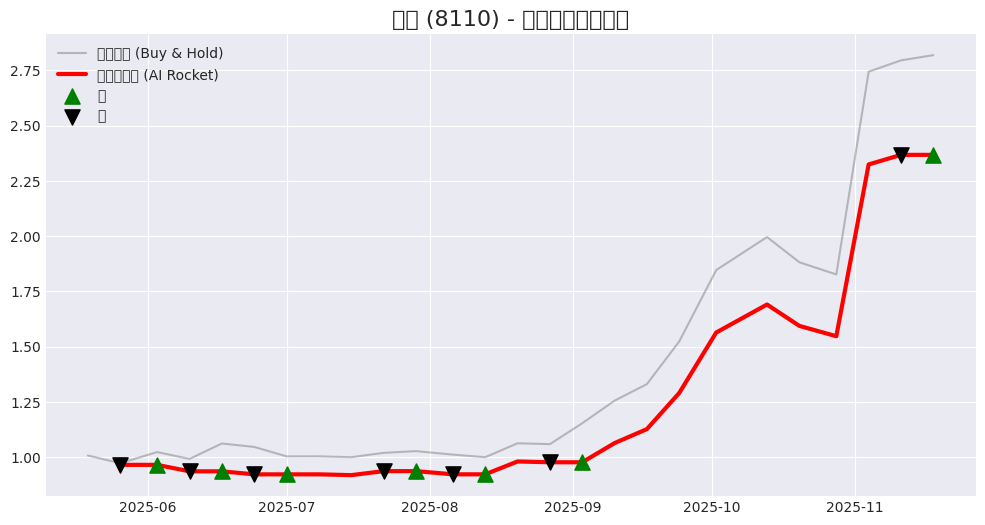


【阿姨請看這裡：下週操作指令】
現在股價: 36.95 元
👉 指令: 🟢 買進 / 續抱！
   理由: AI 預測下週會漲 2.86%
   建議: 風險仍高 (20.4%)，買 8.1 張 (3成倉) 試水溫。


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# --- 設定繪圖風格 ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("🚀 正在啟動「華東 (8110.TW) 終極火箭模式」...")

# =========================================================
# 1. 下載全球數據 (Global Radar)
# =========================================================
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3) # 3年

tickers = {
    'Target': '8110.TW',      # 華東
    'Market': '^TWII',        # 台股
    'Nvidia': 'NVDA',         # AI 霸主
    'Google': 'GOOGL',        # Google
    'Broadcom': 'AVGO',       # 博通
    'Micron': 'MU',           # 美光
    'SK_Hynix': '000660.KS',  # 海力士
    'Samsung': '005930.KS',   # 三星
    'FX': 'USDTWD=X',         # 匯率
    'VIX': '^VIX'             # 恐慌指數
}

print(f"1. 正在下載數據 ({len(tickers)} 檔股票)...")
raw_data = pd.DataFrame()

for name, ticker in tickers.items():
    try:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            vals = df['Adj Close'].iloc[:, 0] if 'Adj Close' in df.columns.get_level_values(0) else df['Close'].iloc[:, 0]
        else:
            vals = df['Adj Close'] if 'Adj Close' in df else df['Close']

        if vals.index.tz is not None: vals.index = vals.index.tz_localize(None)
        raw_data[name] = vals
    except: pass

raw_data = raw_data.ffill().dropna()
print(f"-> 數據準備完成！")

# =========================================================
# 2. 訓練 AI 模型 (LASSO + ARIMA)
# =========================================================
print("2. 正在訓練雙引擎模型...")

data = pd.DataFrame()
period = 5 # 週線

# 目標與特徵
data['Target_Return'] = np.log(raw_data['Target']).diff(period).shift(-period)
for col in raw_data.columns:
    data[f'{col}_Ret'] = np.log(raw_data[col]).diff(period)

data.dropna(inplace=True)
data_weekly = data.iloc[::period, :].copy()

# 分割
test_size = 26
train = data_weekly.iloc[:-test_size]
test = data_weekly.iloc[-test_size:]

X_train, Y_train = train.drop(columns=['Target_Return']), train['Target_Return']
X_test, Y_test = test.drop(columns=['Target_Return']), test['Target_Return']

# --- A. LASSO ---
lasso = Lasso(alpha=0.0001, max_iter=10000)
lasso.fit(X_train, Y_train)
lasso_pred = lasso.predict(X_test)

# --- B. ARIMA (滾動預測) ---
history = [x for x in Y_train]
arima_preds = []
for i in range(len(Y_test)):
    try:
        model = ARIMA(history, order=(2,0,1))
        model_fit = model.fit()
        arima_preds.append(model_fit.forecast()[0])
        history.append(Y_test.iloc[i])
    except:
        arima_preds.append(0)

# --- C. 混合預測 ---
hybrid_pred = (0.5 * lasso_pred) + (0.5 * np.array(arima_preds))

# =========================================================
# 3. 計算波動率 (GARCH) - 用來算倉位，不是用來嚇跑我們
# =========================================================
try:
    residuals = Y_test - hybrid_pred
    garch = arch_model(residuals, p=1, q=1, vol='Garch', dist='Normal')
    res = garch.fit(disp='off')
    volatility = res.conditional_volatility
except:
    volatility = pd.Series([0]*len(Y_test), index=Y_test.index)

# =========================================================
# 4. 阿姨的「火箭模式」 (訊號產生器)
# =========================================================
results = pd.DataFrame(index=Y_test.index)
results['Pred'] = hybrid_pred
results['Vol'] = volatility.values
results['Actual'] = Y_test.values # 這是當週的真實漲跌幅

print("\n🔥 [火箭模式] 已啟動：加入「趨勢強制令」，防止過早賣出！")

def get_signal_rocket(row):
    pred = row['Pred']      # AI 預測下週漲跌
    actual = row['Actual']  # 本週實際漲跌

    # 邏輯 1: AI 說會漲 -> 買
    if pred > 0:
        return 1

    # 邏輯 2 (趨勢強制令):
    # AI 雖然說跌，但本週其實大漲超過 3% -> 代表趨勢超強 -> 強制買進/續抱！
    # 這能解決 "漲太多 AI 叫我賣" 的問題
    elif actual > 0.03:
        return 1

    # 邏輯 3: 真的轉弱了 -> 賣
    else:
        return 0

results['Signal'] = results.apply(get_signal_rocket, axis=1)

# 回測計算
results['My_Return'] = results['Signal'].shift(1) * results['Actual']
results['Hold_Equity'] = np.exp(results['Actual'].cumsum())
results['My_Equity'] = np.exp(results['My_Return'].cumsum())

# =========================================================
# 5. 畫圖 (成果驗收)
# =========================================================
plt.figure(figsize=(12, 6))
plt.plot(results['Hold_Equity'], label='傻傻抱著 (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(results['My_Equity'], label='阿姨火箭隊 (AI Rocket)', color='red', linewidth=3)

# 標出買賣點
buys = results[results['Signal'].diff() == 1]
sells = results[results['Signal'].diff() == -1]
plt.scatter(buys.index, results.loc[buys.index]['My_Equity'], marker='^', color='green', s=120, label='買', zorder=5)
plt.scatter(sells.index, results.loc[sells.index]['My_Equity'], marker='v', color='black', s=120, label='賣', zorder=5)

plt.title('華東 (8110) - 趨勢跟隨火箭策略', fontsize=16)
plt.legend()
plt.show()

# =========================================================
# 6. 下週該怎麼做？ (操作指令)
# =========================================================
last_pred = results.iloc[-1]['Pred']
last_vol = results.iloc[-1]['Vol']
last_actual_return = results.iloc[-1]['Actual']
curr_price = raw_data['Target'].iloc[-1]
my_money = 1000000

print("\n" + "="*45)
print(f"【阿姨請看這裡：下週操作指令】")
print(f"現在股價: {curr_price:.2f} 元")
print("="*45)

# 判斷下週訊號 (使用相同的火箭邏輯)
signal = 0
reason = ""

if last_pred > 0:
    signal = 1
    reason = f"AI 預測下週會漲 {last_pred*100:.2f}%"
elif last_actual_return > 0.03:
    signal = 1
    reason = f"AI 雖保守，但本週大漲 {last_actual_return*100:.2f}%，趨勢極強，強制續抱！"
else:
    signal = 0
    reason = "AI 預測下跌，且無強勢訊號。"

if signal == 1:
    print(f"👉 指令: 🟢 買進 / 續抱！")
    print(f"   理由: {reason}")

    # 資金建議 (波動大買少點，波動小買多點)
    # 這裡我們用 20% 波動率當分界線，因為飆股波動本來就大
    if last_vol > 0.20:
        shares = int((my_money * 0.3) / curr_price)
        print(f"   建議: 風險仍高 ({last_vol*100:.1f}%)，買 {shares/1000:.1f} 張 (3成倉) 試水溫。")
    else:
        shares = int((my_money * 0.5) / curr_price) # 火箭模式最多 5 成，留點現金
        print(f"   建議: 趨勢明確，買 {shares/1000:.1f} 張 (5成倉) 坐轎！")

else:
    print(f"👉 指令: 🔴 全部賣出 / 空手觀望！")
    print(f"   理由: {reason}")

In [ ]:
# -*- coding: UTF-8 -*-
"""
================================================================================
策略名稱：趨勢跟隨火箭策略 (Trend Following Rocket Strategy)
目標股票：華東 (8110.TW) 或其他標的
================================================================================

策略核心理念：
--------------
1. 雙引擎預測：LASSO + ARIMA 混合模型
2. 波動率管理：GARCH 模型計算條件波動率
3. 火箭模式：趨勢強制令，防止在強勢趨勢中過早賣出

訊號邏輯 (火箭模式)：
--------------------
- 買進條件 1：AI 預測下週會漲 (pred > 0)
- 買進條件 2：本週實際大漲超過 3%，即使 AI 保守也強制續抱 (趨勢強制令)
- 賣出條件：AI 預測下跌，且無強勢訊號

倉位管理：
----------
- 高波動 (>20%)：3 成倉位試水溫
- 低波動 (<=20%)：5 成倉位坐轎

作者：阿姨的量化交易助手
版本：2.0 (重構版)
================================================================================
"""

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 套件導入與檢查
# =============================================================================

try:
    import yfinance as yf
    HAS_YFINANCE = True
except ImportError:
    HAS_YFINANCE = False
    print("⚠️ 警告：未安裝 yfinance (pip install yfinance)")

try:
    from sklearn.linear_model import Lasso
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("⚠️ 警告：未安裝 scikit-learn (pip install scikit-learn)")

try:
    from statsmodels.tsa.arima.model import ARIMA
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("⚠️ 警告：未安裝 statsmodels (pip install statsmodels)")

try:
    from arch import arch_model
    HAS_ARCH = True
except ImportError:
    HAS_ARCH = False
    print("⚠️ 警告：未安裝 arch (pip install arch)，將跳過 GARCH 波動率計算")

try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
    # 設定繪圖風格
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
except ImportError:
    HAS_MATPLOTLIB = False
    print("⚠️ 警告：未安裝 matplotlib (pip install matplotlib)")


# =============================================================================
# 全球雷達數據配置
# =============================================================================

# 預設的全球關聯股票 (Global Radar)
DEFAULT_TICKERS = {
    'Target': '8110.TW',      # 華東 (目標股票)
    'Market': '^TWII',        # 台股加權指數
    'Nvidia': 'NVDA',         # NVIDIA - AI 霸主
    'Google': 'GOOGL',        # Google - 科技巨頭
    'Broadcom': 'AVGO',       # 博通 - 半導體
    'Micron': 'MU',           # 美光 - 記憶體
    'SK_Hynix': '000660.KS',  # SK 海力士 - 韓國記憶體
    'Samsung': '005930.KS',   # 三星電子 - 韓國科技
    'FX': 'USDTWD=X',         # 美元/台幣 匯率
    'VIX': '^VIX'             # VIX 恐慌指數
}


# =============================================================================
# 火箭策略核心類別
# =============================================================================

class RocketStrategy:
    """
    趨勢跟隨火箭策略

    整合 LASSO + ARIMA 雙引擎預測，搭配 GARCH 波動率管理，
    並採用「趨勢強制令」防止在強勢行情中過早出場。

    Attributes:
        target_stock (str): 目標股票代碼
        tickers (dict): 全球關聯股票字典
        period (int): 計算週期 (預設 5 = 週線)
        test_weeks (int): 測試集週數
        trend_threshold (float): 趨勢強制令閾值 (預設 3%)
        high_vol_threshold (float): 高波動率閾值 (預設 20%)
    """

    def __init__(self,
                 target_stock='8110.TW',
                 tickers=None,
                 period=5,
                 test_weeks=26,
                 trend_threshold=0.03,
                 high_vol_threshold=0.20,
                 lasso_alpha=0.0001,
                 arima_order=(2, 0, 1)):
        """
        初始化火箭策略

        Args:
            target_stock: 目標股票代碼 (預設: 8110.TW 華東)
            tickers: 自訂股票字典，若為 None 則使用預設
            period: 報酬率計算週期 (預設: 5 日 = 週線)
            test_weeks: 測試集週數 (預設: 26 週 = 半年)
            trend_threshold: 觸發趨勢強制令的漲幅閾值 (預設: 3%)
            high_vol_threshold: 高波動率閾值，用於倉位管理 (預設: 20%)
            lasso_alpha: LASSO 正則化參數
            arima_order: ARIMA 模型階數 (p, d, q)
        """
        self.target_stock = target_stock
        self.period = period
        self.test_weeks = test_weeks
        self.trend_threshold = trend_threshold
        self.high_vol_threshold = high_vol_threshold
        self.lasso_alpha = lasso_alpha
        self.arima_order = arima_order

        # 設定股票列表
        if tickers is None:
            self.tickers = DEFAULT_TICKERS.copy()
            self.tickers['Target'] = target_stock
        else:
            self.tickers = tickers

        # 模型儲存
        self.lasso_model = None
        self.raw_data = None
        self.results = None
        self.current_price = None

    def download_data(self, years=3):
        """
        下載全球關聯股票數據

        Args:
            years: 下載年數 (預設: 3 年)

        Returns:
            DataFrame: 合併後的價格數據
        """
        if not HAS_YFINANCE:
            print("⚠️ 警告：yfinance 未安裝，使用模擬數據")
            return self._generate_mock_data(years)

        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * years)

        print(f"📡 正在下載數據 ({len(self.tickers)} 檔股票)...")
        print(f"   期間: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")

        raw_data = pd.DataFrame()
        success_count = 0

        for name, ticker in self.tickers.items():
            try:
                df = yf.download(
                    ticker,
                    start=start_date,
                    end=end_date,
                    auto_adjust=False,
                    progress=False
                )

                if df.empty:
                    continue

                # 處理 MultiIndex 欄位
                if isinstance(df.columns, pd.MultiIndex):
                    if 'Adj Close' in df.columns.get_level_values(0):
                        vals = df['Adj Close'].iloc[:, 0]
                    else:
                        vals = df['Close'].iloc[:, 0]
                else:
                    vals = df['Adj Close'] if 'Adj Close' in df else df['Close']

                # 移除時區資訊
                if vals.index.tz is not None:
                    vals.index = vals.index.tz_localize(None)

                raw_data[name] = vals
                success_count += 1

            except Exception as e:
                pass  # 靜默處理錯誤

        # 如果下載失敗，使用模擬數據
        if raw_data.empty or 'Target' not in raw_data.columns:
            print("⚠️ 數據下載失敗，使用模擬數據進行測試...")
            return self._generate_mock_data(years)

        # 前向填充並移除空值
        raw_data = raw_data.ffill().dropna()

        print(f"✅ 數據下載完成！成功 {success_count}/{len(self.tickers)} 檔，共 {len(raw_data)} 筆")

        self.raw_data = raw_data
        self.current_price = raw_data['Target'].iloc[-1] if 'Target' in raw_data.columns else None

        return raw_data

    def _generate_mock_data(self, years=3):
        """
        生成模擬數據用於測試

        Args:
            years: 模擬年數

        Returns:
            DataFrame: 模擬價格數據
        """
        print("🔧 正在生成模擬數據...")

        n_days = int(365 * years * 0.7)  # 約 70% 交易日
        dates = pd.date_range(end=datetime.now(), periods=n_days, freq='B')

        np.random.seed(42)

        raw_data = pd.DataFrame(index=dates)

        # 模擬各股票價格走勢
        stock_configs = {
            'Target': {'base': 50, 'vol': 0.025, 'drift': 0.0003},     # 華東
            'Market': {'base': 18000, 'vol': 0.012, 'drift': 0.0001},  # 台股
            'Nvidia': {'base': 300, 'vol': 0.030, 'drift': 0.0005},    # NVDA
            'Google': {'base': 140, 'vol': 0.020, 'drift': 0.0002},    # GOOGL
            'Broadcom': {'base': 800, 'vol': 0.025, 'drift': 0.0004},  # AVGO
            'Micron': {'base': 80, 'vol': 0.028, 'drift': 0.0002},     # MU
            'SK_Hynix': {'base': 180000, 'vol': 0.022, 'drift': 0.0002},
            'Samsung': {'base': 70000, 'vol': 0.018, 'drift': 0.0001},
            'FX': {'base': 32, 'vol': 0.005, 'drift': 0.0001},         # USD/TWD
            'VIX': {'base': 18, 'vol': 0.08, 'drift': 0}               # VIX
        }

        for name, config in stock_configs.items():
            returns = np.random.randn(n_days) * config['vol'] + config['drift']
            prices = config['base'] * np.cumprod(1 + returns)
            raw_data[name] = prices

        print(f"✅ 模擬數據生成完成！共 {len(raw_data)} 筆")

        self.raw_data = raw_data
        self.current_price = raw_data['Target'].iloc[-1]

        return raw_data

    def prepare_features(self):
        """
        準備特徵變量和目標變量

        Returns:
            tuple: (訓練集, 測試集, 特徵名稱)
        """
        if self.raw_data is None:
            print("❌ 錯誤：請先執行 download_data()")
            return None, None, None

        print("🔧 正在準備特徵...")

        data = pd.DataFrame()

        # 目標變量：未來 N 日的對數報酬率
        data['Target_Return'] = np.log(self.raw_data['Target']).diff(self.period).shift(-self.period)

        # 特徵變量：各股票的對數報酬率
        for col in self.raw_data.columns:
            data[f'{col}_Ret'] = np.log(self.raw_data[col]).diff(self.period)

        # 清理數據
        data.dropna(inplace=True)

        # 轉換為週線數據
        data_weekly = data.iloc[::self.period, :].copy()

        print(f"   總樣本數: {len(data_weekly)} 週")

        # 分割訓練/測試集
        train = data_weekly.iloc[:-self.test_weeks]
        test = data_weekly.iloc[-self.test_weeks:]

        print(f"   訓練集: {len(train)} 週")
        print(f"   測試集: {len(test)} 週")

        return train, test, list(data.columns)

    def train_lasso(self, X_train, Y_train):
        """
        訓練 LASSO 模型

        Args:
            X_train: 訓練特徵
            Y_train: 訓練目標

        Returns:
            訓練好的 LASSO 模型
        """
        if not HAS_SKLEARN:
            print("❌ 錯誤：需要安裝 scikit-learn")
            return None

        print("🤖 正在訓練 LASSO 模型...")

        lasso = Lasso(alpha=self.lasso_alpha, max_iter=10000)
        lasso.fit(X_train, Y_train)

        # 顯示重要特徵
        coef_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': lasso.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)

        print("   重要特徵 (係數 ≠ 0):")
        important = coef_df[abs(coef_df['Coefficient']) > 1e-6]
        for _, row in important.head(5).iterrows():
            print(f"   - {row['Feature']}: {row['Coefficient']:.6f}")

        self.lasso_model = lasso
        return lasso

    def train_arima_rolling(self, Y_train, Y_test):
        """
        使用滾動預測訓練 ARIMA 模型

        Args:
            Y_train: 訓練序列
            Y_test: 測試序列 (用於滾動預測)

        Returns:
            np.array: ARIMA 預測值序列
        """
        if not HAS_STATSMODELS:
            print("⚠️ 警告：statsmodels 未安裝，跳過 ARIMA")
            return np.zeros(len(Y_test))

        print("🤖 正在訓練 ARIMA 模型 (滾動預測)...")

        history = list(Y_train)
        arima_preds = []

        for i in range(len(Y_test)):
            try:
                model = ARIMA(history, order=self.arima_order)
                model_fit = model.fit()
                pred = model_fit.forecast()[0]
                arima_preds.append(pred)
                history.append(Y_test.iloc[i])
            except Exception as e:
                arima_preds.append(0)

        print(f"   完成 {len(arima_preds)} 筆滾動預測")

        return np.array(arima_preds)

    def calculate_volatility(self, residuals):
        """
        使用 GARCH(1,1) 計算條件波動率

        Args:
            residuals: 預測殘差序列

        Returns:
            pd.Series: 條件波動率序列
        """
        if not HAS_ARCH:
            print("⚠️ 警告：arch 未安裝，使用固定波動率")
            return pd.Series([0.15] * len(residuals), index=residuals.index)

        print("📊 正在計算 GARCH 波動率...")

        try:
            garch = arch_model(residuals, p=1, q=1, vol='Garch', dist='Normal')
            res = garch.fit(disp='off')
            volatility = res.conditional_volatility
            print(f"   平均波動率: {volatility.mean()*100:.2f}%")
            return volatility
        except Exception as e:
            print(f"   ⚠️ GARCH 計算失敗: {e}")
            return pd.Series([0.15] * len(residuals), index=residuals.index)

    def generate_signal_rocket(self, pred, actual_return):
        """
        火箭模式訊號產生器

        核心邏輯：
        1. AI 預測會漲 → 買進
        2. AI 保守但本週大漲超過閾值 → 趨勢強制令，強制續抱
        3. AI 預測下跌且無強勢訊號 → 賣出

        Args:
            pred: AI 預測的下週報酬率
            actual_return: 本週實際報酬率

        Returns:
            int: 1 (買進/續抱), 0 (賣出/觀望)
        """
        # 條件 1: AI 預測會漲
        if pred > 0:
            return 1

        # 條件 2: 趨勢強制令 - 本週大漲超過閾值
        elif actual_return > self.trend_threshold:
            return 1

        # 條件 3: 真的轉弱了
        else:
            return 0

    def backtest(self, lasso_pred, arima_pred, Y_test, lasso_weight=0.5):
        """
        執行回測

        Args:
            lasso_pred: LASSO 預測值
            arima_pred: ARIMA 預測值
            Y_test: 實際報酬率
            lasso_weight: LASSO 權重 (ARIMA 權重 = 1 - lasso_weight)

        Returns:
            DataFrame: 回測結果
        """
        print("📈 正在執行回測...")

        # 混合預測
        hybrid_pred = (lasso_weight * lasso_pred) + ((1 - lasso_weight) * arima_pred)

        # 計算波動率
        residuals = Y_test - hybrid_pred
        volatility = self.calculate_volatility(residuals)

        # 建立結果 DataFrame
        results = pd.DataFrame(index=Y_test.index)
        results['Pred'] = hybrid_pred
        results['Actual'] = Y_test.values
        results['Vol'] = volatility.values if hasattr(volatility, 'values') else volatility

        # 產生訊號
        results['Signal'] = results.apply(
            lambda row: self.generate_signal_rocket(row['Pred'], row['Actual']),
            axis=1
        )

        # 計算策略報酬 (訊號延遲一期)
        results['Strategy_Return'] = results['Signal'].shift(1) * results['Actual']

        # 計算累積權益曲線
        results['Hold_Equity'] = np.exp(results['Actual'].cumsum())
        results['Strategy_Equity'] = np.exp(results['Strategy_Return'].cumsum())

        # 計算績效指標
        total_return = results['Strategy_Equity'].iloc[-1] - 1
        hold_return = results['Hold_Equity'].iloc[-1] - 1
        win_rate = (results['Strategy_Return'] > 0).sum() / (results['Strategy_Return'] != 0).sum()

        print(f"   策略總報酬: {total_return*100:.2f}%")
        print(f"   持有總報酬: {hold_return*100:.2f}%")
        print(f"   勝率: {win_rate*100:.1f}%")

        self.results = results
        return results

    def plot_results(self, save_path=None):
        """
        繪製回測結果圖表

        Args:
            save_path: 儲存路徑 (若為 None 則顯示)
        """
        if not HAS_MATPLOTLIB:
            print("⚠️ 警告：matplotlib 未安裝，無法繪圖")
            return

        if self.results is None:
            print("❌ 錯誤：請先執行 backtest()")
            return

        results = self.results

        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        # --- 圖 1: 權益曲線 ---
        ax1 = axes[0]
        ax1.plot(results['Hold_Equity'], label='傻傻抱著 (Buy & Hold)',
                 color='gray', alpha=0.6, linewidth=2)
        ax1.plot(results['Strategy_Equity'], label='阿姨火箭隊 (AI Rocket)',
                 color='red', linewidth=3)

        # 標出買賣點
        buys = results[results['Signal'].diff() == 1]
        sells = results[results['Signal'].diff() == -1]

        ax1.scatter(buys.index, results.loc[buys.index]['Strategy_Equity'],
                   marker='^', color='green', s=150, label='🟢 買進', zorder=5)
        ax1.scatter(sells.index, results.loc[sells.index]['Strategy_Equity'],
                   marker='v', color='black', s=150, label='🔴 賣出', zorder=5)

        ax1.set_title(f'{self.target_stock} - 趨勢跟隨火箭策略', fontsize=16, fontweight='bold')
        ax1.set_ylabel('累積權益')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)

        # --- 圖 2: 預測 vs 實際 ---
        ax2 = axes[1]
        ax2.bar(results.index, results['Actual'], alpha=0.5, label='實際報酬', color='blue')
        ax2.plot(results.index, results['Pred'], color='red', linewidth=2,
                label='AI 預測', marker='o', markersize=4)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.axhline(y=self.trend_threshold, color='green', linestyle=':',
                   alpha=0.7, label=f'趨勢強制令閾值 ({self.trend_threshold*100:.0f}%)')

        ax2.set_title('AI 預測 vs 實際報酬', fontsize=14)
        ax2.set_ylabel('週報酬率')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"📊 圖表已儲存至: {save_path}")
        else:
            plt.show()

    def get_recommendation(self, capital=1000000):
        """
        獲取下週操作建議

        Args:
            capital: 可用資金 (預設: 100 萬)

        Returns:
            dict: 操作建議
        """
        if self.results is None or self.current_price is None:
            print("❌ 錯誤：請先執行完整策略流程")
            return None

        last_row = self.results.iloc[-1]
        last_pred = last_row['Pred']
        last_vol = last_row['Vol']
        last_actual = last_row['Actual']

        # 判斷訊號
        signal = self.generate_signal_rocket(last_pred, last_actual)

        # 決定理由
        if last_pred > 0:
            reason = f"AI 預測下週會漲 {last_pred*100:.2f}%"
        elif last_actual > self.trend_threshold:
            reason = f"AI 雖保守，但本週大漲 {last_actual*100:.2f}%，趨勢極強，強制續抱！"
        else:
            reason = "AI 預測下跌，且無強勢訊號"

        # 計算建議倉位
        if signal == 1:
            if last_vol > self.high_vol_threshold:
                position_pct = 0.3  # 高波動：3 成倉
                position_note = f"風險仍高 ({last_vol*100:.1f}%)，建議 3 成倉試水溫"
            else:
                position_pct = 0.5  # 低波動：5 成倉
                position_note = f"趨勢明確，建議 5 成倉坐轎"

            shares = int((capital * position_pct) / self.current_price)
            lots = shares / 1000  # 台股 1 張 = 1000 股
        else:
            position_pct = 0
            position_note = "建議空手觀望或全部賣出"
            shares = 0
            lots = 0

        recommendation = {
            'date': datetime.now().strftime('%Y-%m-%d'),
            'stock': self.target_stock,
            'current_price': self.current_price,
            'signal': '🟢 買進/續抱' if signal == 1 else '🔴 賣出/觀望',
            'signal_code': signal,
            'reason': reason,
            'prediction': last_pred,
            'volatility': last_vol,
            'last_return': last_actual,
            'position_pct': position_pct,
            'position_note': position_note,
            'suggested_shares': shares,
            'suggested_lots': lots,
            'capital': capital
        }

        return recommendation

    def print_recommendation(self, capital=1000000):
        """
        印出下週操作建議 (格式化輸出)

        Args:
            capital: 可用資金
        """
        rec = self.get_recommendation(capital)

        if rec is None:
            return

        print("\n" + "=" * 60)
        print("【阿姨請看這裡：下週操作指令】")
        print("=" * 60)
        print(f"📅 分析日期: {rec['date']}")
        print(f"📈 目標股票: {rec['stock']}")
        print(f"💰 現在股價: {rec['current_price']:.2f} 元")
        print("-" * 60)
        print(f"👉 指令: {rec['signal']}")
        print(f"   理由: {rec['reason']}")
        print(f"   AI 預測: {rec['prediction']*100:.2f}%")
        print(f"   波動率: {rec['volatility']*100:.1f}%")
        print("-" * 60)

        if rec['signal_code'] == 1:
            print(f"💼 建議倉位: {rec['position_pct']*100:.0f}%")
            print(f"   {rec['position_note']}")
            print(f"   以 {rec['capital']:,.0f} 元計算，建議買 {rec['suggested_lots']:.1f} 張")
        else:
            print(f"💼 {rec['position_note']}")

        print("=" * 60)

    def run(self, years=3, capital=1000000, plot=True, save_plot=None):
        """
        執行完整策略流程

        Args:
            years: 下載數據年數
            capital: 可用資金
            plot: 是否繪圖
            save_plot: 圖表儲存路徑 (若為 None 且 plot=True 則顯示)

        Returns:
            dict: 包含模型資訊和建議的字典
        """
        print("🚀 正在啟動「趨勢跟隨火箭策略」...")
        print(f"   目標股票: {self.target_stock}")
        print(f"   趨勢強制令閾值: {self.trend_threshold*100:.0f}%")
        print()

        # 1. 下載數據
        self.download_data(years=years)
        if self.raw_data is None or self.raw_data.empty:
            print("❌ 數據下載失敗，無法繼續")
            return None

        # 2. 準備特徵
        train, test, _ = self.prepare_features()
        if train is None:
            return None

        X_train = train.drop(columns=['Target_Return'])
        Y_train = train['Target_Return']
        X_test = test.drop(columns=['Target_Return'])
        Y_test = test['Target_Return']

        # 3. 訓練模型
        self.train_lasso(X_train, Y_train)
        lasso_pred = self.lasso_model.predict(X_test)
        arima_pred = self.train_arima_rolling(Y_train, Y_test)

        # 4. 回測
        self.backtest(lasso_pred, arima_pred, Y_test)

        # 5. 繪圖
        if plot:
            self.plot_results(save_path=save_plot)

        # 6. 輸出建議
        self.print_recommendation(capital=capital)

        return {
            'results': self.results,
            'recommendation': self.get_recommendation(capital),
            'current_price': self.current_price
        }


# =============================================================================
# 便捷函數
# =============================================================================

def run_rocket_strategy(target_stock='8110.TW', capital=1000000, years=3,
                        trend_threshold=0.03, plot=True):
    """
    快速執行火箭策略的便捷函數

    Args:
        target_stock: 目標股票代碼
        capital: 可用資金
        years: 數據年數
        trend_threshold: 趨勢強制令閾值
        plot: 是否繪圖

    Returns:
        RocketStrategy: 策略實例
    """
    strategy = RocketStrategy(
        target_stock=target_stock,
        trend_threshold=trend_threshold
    )

    strategy.run(years=years, capital=capital, plot=plot)

    return strategy


# =============================================================================
# 主程式
# =============================================================================

if __name__ == "__main__":
    # 執行華東 (8110.TW) 火箭策略
    strategy = run_rocket_strategy(
        target_stock='8110.TW',  # 華東
        capital=1000000,         # 100 萬資金
        years=3,                 # 3 年數據
        trend_threshold=0.03,    # 3% 趨勢強制令
        plot=False               # 在伺服器環境關閉繪圖
    )

🚀 正在啟動「趨勢跟隨火箭策略」...
   目標股票: 8110.TW
   趨勢強制令閾值: 3%

📡 正在下載數據 (10 檔股票)...
   期間: 2022-11-29 ~ 2025-11-28
✅ 數據下載完成！成功 10/10 檔，共 724 筆
🔧 正在準備特徵...
   總樣本數: 143 週
   訓練集: 117 週
   測試集: 26 週
🤖 正在訓練 LASSO 模型...
   重要特徵 (係數 ≠ 0):
   - Target_Ret: -0.262618
   - Broadcom_Ret: 0.137977
   - Micron_Ret: 0.092793
   - Samsung_Ret: 0.008521
   - VIX_Ret: 0.005730
🤖 正在訓練 ARIMA 模型 (滾動預測)...
   完成 26 筆滾動預測
📈 正在執行回測...
📊 正在計算 GARCH 波動率...
   平均波動率: 7.96%
   策略總報酬: 136.78%
   持有總報酬: 181.89%
   勝率: 52.6%

【阿姨請看這裡：下週操作指令】
📅 分析日期: 2025-11-28
📈 目標股票: 8110.TW
💰 現在股價: 36.95 元
------------------------------------------------------------
👉 指令: 🟢 買進/續抱
   理由: AI 預測下週會漲 2.86%
   AI 預測: 2.86%
   波動率: 20.4%
------------------------------------------------------------
💼 建議倉位: 30%
   風險仍高 (20.4%)，建議 3 成倉試水溫
   以 1,000,000 元計算，建議買 8.1 張


🚀 正在啟動「全球半導體供應鏈」AI 交易系統 (8110.TW 專用版)...
1. 正在下載全球多國數據 (14 檔)...
   -> 正在進行跨國時區對齊與清洗...
-> 數據整合完成！共 724 個共同交易日。
2. 正在計算動量與因子...
3. 正在訓練 LASSO (宏觀) + ARIMA (慣性) 集成模型...
   -> 正在執行 ARIMA 滾動預測 (26 週)...


4. 正在計算 GARCH 波動率風險...
   -> 當前市場波動警戒線: 9.79%


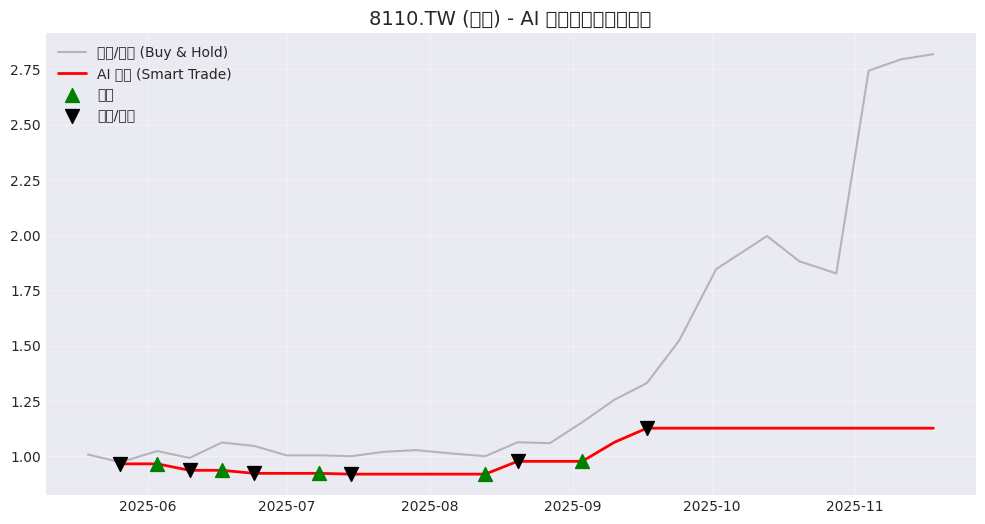


【阿姨的下週操作建議】 (股價: 36.95)
下週 AI 預測方向: 🟢 看漲
下週波動率風險:   21.17% (閥值: 9.79%)

👉 最終指令: 🔴 賣出 / 空手觀望
   理由: 預測下跌 或 風險過高，請保留現金。

[AI 因子透視眼 - 誰在影響華東?]
Target_Ret     -0.222
Broadcom_Ret    0.189
Micron_Ret      0.109
Marvell_Ret    -0.090
Mom_6w         -0.077
dtype: float64


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import accuracy_score

# 設定繪圖風格與字型
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei'] # 解決中文亂碼
plt.rcParams['axes.unicode_minus'] = False

print("🚀 正在啟動「全球半導體供應鏈」AI 交易系統 (8110.TW 專用版)...")

# =========================================================
# 1. 數據獲取 (Global ETL)
# =========================================================
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3) # 抓取過去 3 年數據

# 定義全球觀察清單
tickers = {
    'Target': '8110.TW',      # 預測目標：華東 (記憶體封測)

    # --- 台股關聯 ---
    'Market_TW': '^TWII',     # 台股大盤

    # --- 美股 AI 巨頭 (領先指標) ---
    'Nvidia': 'NVDA',         # AI 霸主 (帶動整體情緒)
    'Google': 'GOOGL',        # TPU 自研晶片 (您特別指定的)
    'Broadcom': 'AVGO',       # 通訊晶片/ASIC (領先指標)
    'Marvell': 'MRVL',        # 存儲控制晶片 (二哥)
    'Arista': 'ANET',         # 網路設備 (基礎設施)
    'Vertiv': 'VRT',          # 散熱電源 (基礎設施)
    'Micron': 'MU',           # 美光 (記憶體大廠)
    'TSMC_ADR': 'TSM',        # 台積電 (權王)

    # --- 韓國記憶體 (競爭/連動) ---
    'SK_Hynix': '000660.KS',  # HBM 龍頭
    'Samsung': '005930.KS',   # 記憶體霸主

    # --- 宏觀因子 ---
    'FX': 'USDTWD=X',         # 美元兌台幣 (匯率)
    'VIX': '^VIX'             # 恐慌指數
}

print(f"1. 正在下載全球多國數據 ({len(tickers)} 檔)...")
raw_data = pd.DataFrame()

for name, ticker in tickers.items():
    try:
        # 下載數據
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)

        # 處理資料格式 (相容 yfinance 新舊版)
        if isinstance(df.columns, pd.MultiIndex):
            if 'Adj Close' in df.columns.get_level_values(0):
                price = df['Adj Close']
            else:
                price = df['Close']
            vals = price.iloc[:, 0] if price.shape[1] > 0 else price
        else:
            vals = df['Adj Close'] if 'Adj Close' in df else df['Close']

        # 關鍵修正：移除時區資訊，以便台股、美股、韓股能對齊
        if vals.index.tz is not None:
            vals.index = vals.index.tz_localize(None)

        raw_data[name] = vals

    except Exception as e:
        print(f"   [警告] 無法下載 {name}: {e}")

# 資料對齊 (處理跨國休市日，以前一日收盤價填補)
print("   -> 正在進行跨國時區對齊與清洗...")
raw_data = raw_data.ffill().dropna()

print(f"-> 數據整合完成！共 {len(raw_data)} 個共同交易日。")

# =========================================================
# 2. 特徵工程 (Feature Engineering)
# =========================================================
print("2. 正在計算動量與因子...")
data = pd.DataFrame()
return_period = 5 # 設定預測週期為「一週 (5天)」

# A. 目標：預測下週 8110 的漲跌 (Y)
# shift(-5) 代表把下週的漲跌移到今天，作為訓練目標
data['Target_Return'] = np.log(raw_data['Target']).diff(return_period).shift(-return_period)

# B. 特徵：計算所有股票過去一週的漲跌 (X)
for col in raw_data.columns:
    if col != 'VIX': # VIX 看絕對數值，其他看漲跌幅
        data[f'{col}_Ret'] = np.log(raw_data[col]).diff(return_period)
    else:
        data['VIX_Level'] = raw_data['VIX']

# C. 內部動量：華東自己的過去趨勢
for w in [3, 6, 12]: # 過去 3週, 6週, 12週
    data[f'Mom_{w}w'] = np.log(raw_data['Target']).diff(return_period * w)

# 清理 NaN
data.dropna(inplace=True)

# 每 5 天取樣一次 (模擬週交易)
data_weekly = data.iloc[::return_period, :].copy()

# 分割訓練集與測試集 (最近 26 週/半年 為測試集)
test_size = 26
train = data_weekly.iloc[:-test_size]
test = data_weekly.iloc[-test_size:]

X_train = train.drop(columns=['Target_Return'])
Y_train = train['Target_Return']
X_test = test.drop(columns=['Target_Return'])
Y_test = test['Target_Return']

# =========================================================
# 3. 雙引擎模型訓練 (Hybrid Model)
# =========================================================
print("3. 正在訓練 LASSO (宏觀) + ARIMA (慣性) 集成模型...")

# --- 引擎 A: LASSO (看關聯性) ---
lasso = Lasso(alpha=0.0001, max_iter=10000)
lasso.fit(X_train, Y_train)
lasso_pred = lasso.predict(X_test)

# --- 引擎 B: ARIMA (看慣性) - 滾動預測 ---
history = [x for x in Y_train]
arima_preds = []
print(f"   -> 正在執行 ARIMA 滾動預測 ({len(Y_test)} 週)...")

for i in range(len(Y_test)):
    # 使用 (2,0,1) 參數，這是之前驗證過比較穩定的
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    arima_preds.append(yhat)
    # 把真實數據加入歷史，供下週訓練
    history.append(Y_test.iloc[i])

# --- 集成 (各 50% 權重) ---
hybrid_pred = (0.5 * lasso_pred) + (0.5 * np.array(arima_preds))

# =========================================================
# 4. GARCH 風險控管 (Risk Management)
# =========================================================
print("4. 正在計算 GARCH 波動率風險...")
# 計算殘差 (預測錯多少)
residuals = Y_test - hybrid_pred
# 訓練 GARCH
garch = arch_model(residuals, p=1, q=1, vol='Garch', dist='Normal')
res = garch.fit(disp='off')
volatility = res.conditional_volatility

# =========================================================
# 5. 生成交易訊號與回測
# =========================================================
results = pd.DataFrame(index=Y_test.index)
results['Pred_Return'] = hybrid_pred
results['Volatility'] = volatility.values
results['Actual_Return'] = Y_test.values

# 動態風險閥值 (過去半年的 75% 分位數)
risk_threshold = results['Volatility'].quantile(0.75)
print(f"   -> 當前市場波動警戒線: {risk_threshold*100:.2f}%")

def get_signal(row):
    # 邏輯：預測會漲 且 風險在可控範圍內 -> 買進
    if row['Pred_Return'] > 0 and row['Volatility'] < risk_threshold:
        return 1
    else:
        return 0

results['Signal'] = results.apply(get_signal, axis=1)

# 計算淨值曲線
results['Strategy_Ret'] = results['Signal'].shift(1) * results['Actual_Return']
results['BuyHold_Equity'] = np.exp(results['Actual_Return'].cumsum())
results['Strategy_Equity'] = np.exp(results['Strategy_Ret'].cumsum())

# =========================================================
# 6. 畫圖 (給阿姨看的)
# =========================================================
plt.figure(figsize=(12, 6))
plt.plot(results['BuyHold_Equity'], label='大盤/長抱 (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(results['Strategy_Equity'], label='AI 策略 (Smart Trade)', color='red', linewidth=2)

# 標記買賣點
buys = results[results['Signal'].diff() == 1]
sells = results[results['Signal'].diff() == -1]
plt.scatter(buys.index, results.loc[buys.index]['Strategy_Equity'], marker='^', color='green', s=100, label='買進', zorder=5)
plt.scatter(sells.index, results.loc[sells.index]['Strategy_Equity'], marker='v', color='black', s=100, label='賣出/觀望', zorder=5)

plt.title('8110.TW (華東) - AI 全球供應鏈套利策略', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 7. 資金管理計算機 (Position Sizing)
# =========================================================
def calculate_position_size(account_balance, current_price, garch_volatility, win_rate=0.64):
    print(f"\n{'='*50}")
    print(f"【阿姨的下週操作建議】 (股價: {current_price:.2f})")
    print(f"{'='*50}")

    stop_loss_pct = garch_volatility * 2
    stop_loss_price = current_price * (1 - stop_loss_pct)

    # 凱利公式 (半凱利)
    kelly_pct = (2 * win_rate - 1) / 2
    kelly_value = account_balance * kelly_pct

    # 風險平價 (虧損不超過本金 2%)
    risk_value = (account_balance * 0.02) / stop_loss_pct

    # 取較保守者
    final_value = min(kelly_value, risk_value)
    shares = int(final_value / current_price)

    print(f"下週 AI 預測方向: {'🟢 看漲' if next_pred > 0 else '🔴 看跌'}")
    print(f"下週波動率風險:   {garch_volatility*100:.2f}% (閥值: {risk_threshold*100:.2f}%)")

    if next_pred > 0 and garch_volatility < risk_threshold:
        print(f"\n👉 最終指令: 🟢 買進 / 續抱")
        print(f"   建議倉位: {shares} 股 (約 {shares/1000:.1f} 張)")
        print(f"   建議投入: ${final_value:,.0f}")
        print(f"   停損價格: {stop_loss_price:.2f} (距離 -{stop_loss_pct*100:.2f}%)")
    else:
        print(f"\n👉 最終指令: 🔴 賣出 / 空手觀望")
        print("   理由: 預測下跌 或 風險過高，請保留現金。")

# 獲取最新一週的預測值
last_row = results.iloc[-1]
next_pred = last_row['Pred_Return']
next_vol = last_row['Volatility']
current_price = raw_data['Target'].iloc[-1]

# 假設阿姨本金 100 萬
calculate_position_size(account_balance=1000000, current_price=current_price, garch_volatility=next_vol)

# =========================================================
# 8. 因子貢獻度 (看看誰是華東的老大?)
# =========================================================
print(f"\n[AI 因子透視眼 - 誰在影響華東?]")
coefs = pd.Series(lasso.coef_, index=X_train.columns)
important_features = coefs[coefs != 0].sort_values(key=abs, ascending=False).head(5)
print(important_features)

In [ ]:
# -*- coding: UTF-8 -*-
"""
================================================================================
策略名稱：多因子股價預測策略 (Multi-Factor Stock Prediction Strategy)
目標：股價預測 (Stock Price Prediction)
================================================================================

本策略整合多種方法論進行股價預測：

1. 技術指標分析 (Technical Analysis)
   - MA (移動平均線) - 趨勢判斷
   - RSI (相對強弱指標) - 超買超賣
   - MACD - 動量確認
   - 布林通道 - 波動率分析

2. 計量經濟模型 (Econometric Models)
   - ARIMAX - 時間序列預測
   - Linear Regression (LR) - 線性回歸
   - LASSO - L1 正則化回歸
   - ElasticNet (EN) - 彈性網路

3. 多因子分析 (Multi-Factor Analysis)
   - 相關股票報酬率 (avgo, GOOGL)
   - 匯率因子 (JPY/USD, GBP/USD)
   - 指數因子 (S&P500, DJIA, VIX)
   - 動量因子 (歷史報酬率)

4. 風險管理
   - 動態停利 (趨勢反轉出場)
   - 固定停利 (百分比目標)
   - 固定停損

策略週期：週線 (Weekly)
================================================================================
"""

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 套件導入與檢查
# =============================================================================

# yfinance - 股票數據下載
try:
    import yfinance as yf
    HAS_YFINANCE = True
except ImportError:
    HAS_YFINANCE = False
    print("警告：未安裝 yfinance，將使用模擬數據 (pip install yfinance)")

# pandas_datareader - FRED 數據下載
try:
    import pandas_datareader.data as web
    HAS_DATAREADER = True
except ImportError:
    HAS_DATAREADER = False
    print("警告：未安裝 pandas_datareader，將使用模擬數據 (pip install pandas-datareader)")

# statsmodels - ARIMAX 模型
try:
    from statsmodels.tsa.arima.model import ARIMA
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("警告：未安裝 statsmodels，ARIMAX 模型將不可用 (pip install statsmodels)")

# sklearn - 機器學習模型
try:
    from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import KFold, cross_val_score
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("警告：未安裝 scikit-learn，回歸模型將不可用 (pip install scikit-learn)")


# =============================================================================
# 技術指標計算函數
# =============================================================================

def calculate_MA(prices, period=10):
    """
    計算移動平均線 (Moving Average)

    Args:
        prices: 價格序列 (numpy array 或 list)
        period: 計算週期

    Returns:
        MA 值序列
    """
    prices = np.array(prices, dtype=float)
    ma = np.full(len(prices), np.nan)
    for i in range(period - 1, len(prices)):
        ma[i] = np.mean(prices[i - period + 1:i + 1])
    return ma


def calculate_EMA(prices, period=12):
    """
    計算指數移動平均線 (Exponential Moving Average)

    Args:
        prices: 價格序列
        period: 計算週期

    Returns:
        EMA 值序列
    """
    prices = np.array(prices, dtype=float)
    ema = np.full(len(prices), np.nan)
    multiplier = 2 / (period + 1)
    ema[period - 1] = np.mean(prices[:period])
    for i in range(period, len(prices)):
        ema[i] = (prices[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema


def calculate_RSI(prices, period=14):
    """
    計算相對強弱指標 (RSI)

    Args:
        prices: 價格序列
        period: 計算週期 (預設14)

    Returns:
        RSI 值序列 (0-100)
    """
    prices = np.array(prices, dtype=float)
    rsi = np.full(len(prices), np.nan)
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    losses = np.where(deltas < 0, -deltas, 0)
    for i in range(period, len(prices)):
        avg_gain = np.mean(gains[i - period:i])
        avg_loss = np.mean(losses[i - period:i])
        if avg_loss == 0:
            rsi[i] = 100
        else:
            rs = avg_gain / avg_loss
            rsi[i] = 100 - (100 / (1 + rs))
    return rsi


def calculate_MACD(prices, fast_period=12, slow_period=26, signal_period=9):
    """
    計算 MACD 指標

    Args:
        prices: 價格序列
        fast_period: 快線週期 (預設12)
        slow_period: 慢線週期 (預設26)
        signal_period: 訊號線週期 (預設9)

    Returns:
        (macd, signal, histogram) 三個序列
    """
    prices = np.array(prices, dtype=float)
    ema_fast = calculate_EMA(prices, fast_period)
    ema_slow = calculate_EMA(prices, slow_period)
    macd = ema_fast - ema_slow
    signal = np.full(len(prices), np.nan)
    valid_macd = macd[~np.isnan(macd)]
    if len(valid_macd) >= signal_period:
        signal_values = calculate_EMA(valid_macd, signal_period)
        start_idx = len(prices) - len(valid_macd)
        signal[start_idx:] = signal_values
    histogram = macd - signal
    return macd, signal, histogram


def calculate_Bollinger_Bands(prices, period=20, num_std=2):
    """
    計算布林通道

    Args:
        prices: 價格序列
        period: 計算週期 (預設20)
        num_std: 標準差倍數 (預設2)

    Returns:
        (upper, middle, lower) 三個序列
    """
    prices = np.array(prices, dtype=float)
    middle = calculate_MA(prices, period)
    upper = np.full(len(prices), np.nan)
    lower = np.full(len(prices), np.nan)
    for i in range(period - 1, len(prices)):
        std = np.std(prices[i - period + 1:i + 1])
        upper[i] = middle[i] + num_std * std
        lower[i] = middle[i] - num_std * std
    return upper, middle, lower


def calculate_KD(high, low, close, k_period=9, d_period=3):
    """
    計算 KD 隨機指標

    Args:
        high: 最高價序列
        low: 最低價序列
        close: 收盤價序列
        k_period: K值計算週期
        d_period: D值平滑週期

    Returns:
        (K, D) 兩個序列
    """
    high = np.array(high, dtype=float)
    low = np.array(low, dtype=float)
    close = np.array(close, dtype=float)

    n = len(close)
    rsv = np.full(n, np.nan)
    k = np.full(n, np.nan)
    d = np.full(n, np.nan)

    for i in range(k_period - 1, n):
        highest_high = np.max(high[i - k_period + 1:i + 1])
        lowest_low = np.min(low[i - k_period + 1:i + 1])
        if highest_high != lowest_low:
            rsv[i] = (close[i] - lowest_low) / (highest_high - lowest_low) * 100
        else:
            rsv[i] = 50

    k[k_period - 1] = rsv[k_period - 1]
    for i in range(k_period, n):
        if not np.isnan(rsv[i]):
            k[i] = (2/3) * k[i-1] + (1/3) * rsv[i]

    d[k_period + d_period - 2] = k[k_period + d_period - 2]
    for i in range(k_period + d_period - 1, n):
        if not np.isnan(k[i]):
            d[i] = (2/3) * d[i-1] + (1/3) * k[i]

    return k, d


# =============================================================================
# 數據生成函數
# =============================================================================

def generate_sample_data(periods=100):
    """
    生成範例資料用於測試

    Args:
        periods: 資料筆數

    Returns:
        DataFrame 包含 OHLCV 資料
    """
    np.random.seed(42)

    base_price = 100
    returns = np.random.randn(periods) * 0.02
    prices = base_price * np.cumprod(1 + returns)

    data = {
        'Open': prices * (1 + np.random.randn(periods) * 0.005),
        'High': prices * (1 + np.abs(np.random.randn(periods)) * 0.01),
        'Low': prices * (1 - np.abs(np.random.randn(periods)) * 0.01),
        'Close': prices,
        'Volume': np.random.randint(100000, 1000000, periods)
    }

    dates = pd.date_range(end=datetime.now(), periods=periods, freq='W')
    df = pd.DataFrame(data, index=dates)

    return df


# =============================================================================
# ARIMAX 多因子策略類別
# =============================================================================

class ARIMAXStrategy:
    """
    多因子 ARIMAX/線性回歸 策略

    使用多種因子進行股價預測：
    - 相關股票報酬率 (avgo, GOOGL)
    - 匯率因子 (JPY/USD, GBP/USD)
    - 指數因子 (S&P500, DJIA, VIX)
    - 動量因子 (歷史報酬率)
    """

    def __init__(self, target_stock='avgo'):
        """
        初始化 ARIMAX 策略

        Args:
            target_stock: 目標股票代碼 (預設: mu)
        """
        self.target_stock = target_stock.upper()
        self.correlated_stocks = ['mu', 'GOOGL']
        self.currency_pairs = ['DEXJPUS', 'DEXUSUK']  # JPY/USD, GBP/USD
        self.indices = ['SP500', 'DJIA', 'VIXCLS']     # S&P500, 道瓊, VIX
        self.return_period = 5  # 5日報酬率

        # 模型存儲
        self.best_regressor = None
        self.best_model_name = None
        self.arimax_model = None
        self.arimax_exog_vars = None
        self.feature_data = None

    def load_data(self, start_date, end_date):
        """
        加載股票、貨幣和指數數據

        Args:
            start_date: 開始日期
            end_date: 結束日期

        Returns:
            (股票數據, 貨幣數據, 指數數據)
        """
        print("正在加載 ARIMAX 所需的多因子數據...")

        if HAS_YFINANCE and HAS_DATAREADER:
            try:
                # 下載股票數據
                stk_tickers = [self.target_stock] + self.correlated_stocks
                stk_tickers = list(set(stk_tickers))  # 去重
                stk_data = yf.download(stk_tickers, start=start_date, end=end_date, progress=False)

                # 下載 FRED 數據 (貨幣和指數)
                ccy_data = web.DataReader(self.currency_pairs, 'fred', start_date, end_date)
                idx_data = web.DataReader(self.indices, 'fred', start_date, end_date)

                print(f"  股票數據: {len(stk_data)} 筆")
                print(f"  貨幣數據: {len(ccy_data)} 筆")
                print(f"  指數數據: {len(idx_data)} 筆")

                return stk_data, ccy_data, idx_data

            except Exception as e:
                print(f"  數據下載失敗: {e}")
                print("  使用模擬數據...")

        # 生成模擬數據
        return self._generate_mock_data(start_date, end_date)

    def _generate_mock_data(self, start_date, end_date):
        """生成模擬數據用於測試"""
        dates = pd.date_range(start=start_date, end=end_date, freq='B')
        n = len(dates)

        np.random.seed(42)

        # 模擬股票數據
        stk_tickers = list(set([self.target_stock] + self.correlated_stocks))
        stk_prices = {}
        for ticker in stk_tickers:
            base_price = 100 + np.random.rand() * 400
            returns = np.random.randn(n) * 0.02
            prices = base_price * np.cumprod(1 + returns)
            stk_prices[ticker] = prices

        stk_data = pd.DataFrame(stk_prices, index=dates)
        stk_data.columns = pd.MultiIndex.from_product([['Adj Close'], stk_data.columns])

        # 模擬貨幣數據
        ccy_data = pd.DataFrame({
            'DEXJPUS': 110 + np.random.randn(n).cumsum() * 0.5,
            'DEXUSUK': 1.3 + np.random.randn(n).cumsum() * 0.01
        }, index=dates)

        # 模擬指數數據
        idx_data = pd.DataFrame({
            'SP500': 4000 + np.random.randn(n).cumsum() * 20,
            'DJIA': 33000 + np.random.randn(n).cumsum() * 100,
            'VIXCLS': 20 + np.abs(np.random.randn(n)) * 5
        }, index=dates)

        print("  使用模擬數據進行測試")

        return stk_data, ccy_data, idx_data

    def prepare_features(self, stk_data_multi_index, ccy_data, idx_data):
        """
        準備特徵變量和目標變量

        Args:
            stk_data_multi_index: 股票數據 (MultiIndex)
            ccy_data: 貨幣數據
            idx_data: 指數數據

        Returns:
            (X, Y, dataset) - 特徵、目標、完整數據集
        """
        print("正在準備 ARIMAX/LR 特徵...")

        # 提取股票價格
        if 'Adj Close' in stk_data_multi_index.columns.get_level_values(0):
            stk_price_data = stk_data_multi_index['Adj Close'].copy()
        elif 'Close' in stk_data_multi_index.columns.get_level_values(0):
            print("  警告: 'Adj Close' 不存在, 使用 'Close' 價格")
            stk_price_data = stk_data_multi_index['Close'].copy()
        else:
            raise ValueError("錯誤: 找不到 'Adj Close' 或 'Close' 價格數據")

        # 合併所有數據
        all_data = pd.concat([stk_price_data, ccy_data, idx_data], axis=1).ffill().dropna()

        # 目標變量: 未來 N 日的對數報酬率
        Y = np.log(all_data.loc[:, self.target_stock]).diff(self.return_period).shift(-self.return_period)
        Y.name = f'{self.target_stock}_pred'

        # 特徵 X1: 相關股票報酬率
        X1 = np.log(all_data.loc[:, self.correlated_stocks]).diff(self.return_period)

        # 特徵 X2: 貨幣報酬率
        X2 = np.log(all_data.loc[:, self.currency_pairs]).diff(self.return_period)

        # 特徵 X3: 指數報酬率
        X3 = np.log(all_data.loc[:, self.indices]).diff(self.return_period)

        # 特徵 X4: 動量因子 (歷史報酬率)
        X4 = pd.concat([
            np.log(all_data.loc[:, self.target_stock]).diff(i)
            for i in [self.return_period, self.return_period*3,
                     self.return_period*6, self.return_period*12]
        ], axis=1)
        X4.columns = [f'{self.target_stock}_DT', f'{self.target_stock}_3DT',
                      f'{self.target_stock}_6DT', f'{self.target_stock}_12DT']

        # 合併所有特徵
        X = pd.concat([X1, X2, X3, X4], axis=1)

        # 建立完整數據集並清理
        dataset = pd.concat([Y, X], axis=1).dropna().iloc[::self.return_period, :]
        Y_final = dataset.loc[:, Y.name]
        X_final = dataset.loc[:, X.columns]

        self.feature_data = dataset

        print(f"  特徵數量: {len(X_final.columns)}")
        print(f"  樣本數量: {len(X_final)}")

        return X_final, Y_final, dataset

    def compare_models(self, X_train, Y_train, X_test, Y_test):
        """
        訓練並比較 LR, LASSO, EN 模型

        Args:
            X_train, Y_train: 訓練數據
            X_test, Y_test: 測試數據

        Returns:
            (best_regressor, best_name, best_mse)
        """
        if not HAS_SKLEARN:
            print("  警告: sklearn 未安裝，跳過模型比較")
            return None, None, float('inf')

        print("-> 正在訓練 LR, LASSO, EN 模型...")

        models = [
            ('LR', LinearRegression()),
            ('LASSO', Lasso(random_state=42, max_iter=10000)),
            ('EN', ElasticNet(random_state=42, max_iter=10000))
        ]

        best_test_mse = float("inf")
        best_model_name = None
        best_regressor = None

        for name, model in models:
            try:
                model.fit(X_train, Y_train)
                test_pred = model.predict(X_test)
                test_mse = mean_squared_error(Y_test, test_pred)

                print(f'   - {name}: Test MSE = {test_mse:.6f}')

                if test_mse < best_test_mse:
                    best_test_mse = test_mse
                    best_model_name = name
                    best_regressor = model

            except Exception as e:
                print(f'   - {name}: 訓練失敗 ({e})')
                continue

        if best_regressor:
            print(f"-> 最佳簡單模型: {best_model_name} (Test MSE: {best_test_mse:.6f})")
            self._print_regression_equation(best_regressor, X_train.columns)

        self.best_regressor = best_regressor
        self.best_model_name = best_model_name

        return best_regressor, best_model_name, best_test_mse

    def _print_regression_equation(self, model, feature_names):
        """印出迴歸方程式"""
        if hasattr(model, 'coef_') and hasattr(model, 'intercept_'):
            coefficients = model.coef_
            intercept = model.intercept_

            print("\n-> 最佳模型的迴歸線 (Regression Line):")
            equation = f"   Y_pred = {intercept:.6f}"

            for name, coef in zip(feature_names, coefficients):
                if abs(coef) > 1e-6:
                    sign = "+" if coef > 0 else "-"
                    equation += f" {sign} {abs(coef):.6f} * {name}"

            print(equation)

    def train_arimax_model(self, X_train, Y_train, order=(2, 0, 1)):
        """
        訓練 ARIMAX 模型

        Args:
            X_train: 訓練特徵
            Y_train: 訓練目標
            order: ARIMA 階數 (p, d, q)

        Returns:
            (model_fit, exogenous_vars)
        """
        if not HAS_STATSMODELS:
            print("  警告: statsmodels 未安裝，跳過 ARIMAX 訓練")
            return None, []

        print(f"-> 正在訓練 ARIMAX{order} 模型...")

        # 外生變量：排除目標股票自身的動量因子
        exogenous_vars = [col for col in X_train.columns if not col.startswith(self.target_stock)]
        X_train_arima = X_train.loc[:, exogenous_vars]

        try:
            model = ARIMA(endog=Y_train, exog=X_train_arima, order=order)
            model_fit = model.fit()

            self.arimax_model = model_fit
            self.arimax_exog_vars = exogenous_vars

            print(f"   - ARIMAX 訓練成功")

            return model_fit, exogenous_vars

        except Exception as e:
            print(f"   - ARIMAX 模型訓練失敗: {e}")
            return None, exogenous_vars

    def run_simple_model_strategy(self, data_period_years=5):
        """
        執行 LR/ARIMAX 策略的完整流程

        Args:
            data_period_years: 數據年數

        Returns:
            (model_info, predictions)
        """
        TICKER = self.target_stock
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=365 * data_period_years)).strftime('%Y-%m-%d')

        print("\n" + "=" * 60)
        print(f"週三訓練：線性回歸與 ARIMAX ({TICKER})")
        print("=" * 60)

        # 1. 加載數據
        stk_data, ccy_data, idx_data = self.load_data(start_date, end_date)

        # 2. 準備特徵
        X, Y, dataset = self.prepare_features(stk_data, ccy_data, idx_data)

        # 3. 分割訓練/測試集
        train_size = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

        print(f"-> 訓練集大小: {len(X_train)} 週")
        print(f"-> 測試集大小: {len(X_test)} 週")

        # 4. 比較線性模型
        best_regressor, best_name, best_mse = self.compare_models(X_train, Y_train, X_test, Y_test)

        # 5. 訓練 ARIMAX
        arimax_model, arimax_exog_vars = self.train_arimax_model(X_train, Y_train, order=(2, 0, 1))

        arimax_test_mse = float('inf')
        if arimax_model and len(X_test) > 0:
            try:
                X_test_arima = X_test.loc[:, arimax_exog_vars]
                test_forecast = arimax_model.forecast(steps=len(X_test), exog=X_test_arima)
                arimax_test_mse = mean_squared_error(Y_test, test_forecast)
                print(f"-> ARIMAX (2,0,1) Test MSE: {arimax_test_mse:.6f}")
            except Exception as e:
                print(f"-> ARIMAX 預測失敗: {e}")

        # 6. 生成預測
        predictions = {}
        current_features = X.iloc[-1:].fillna(0)

        if best_regressor:
            lr_prediction = best_regressor.predict(current_features)[0]
            predictions['linear_model'] = {
                'name': best_name,
                'prediction': lr_prediction,
                'mse': best_mse
            }
            print(f"\n-> 線性模型 ({best_name}) 下週預測報酬率: {lr_prediction:.4f} ({lr_prediction*100:.2f}%)")

        if arimax_model and arimax_exog_vars:
            try:
                arimax_pred = arimax_model.forecast(
                    steps=1,
                    exog=current_features.loc[:, arimax_exog_vars]
                )[0]
                predictions['arimax'] = {
                    'prediction': arimax_pred,
                    'mse': arimax_test_mse
                }
                print(f"-> ARIMAX 下週預測報酬率: {arimax_pred:.4f} ({arimax_pred*100:.2f}%)")
            except Exception as e:
                print(f"-> ARIMAX 預測失敗: {e}")

        print("\n" + "=" * 60)
        print("週三訓練完成，模型已準備好進行過濾！")
        print("=" * 60)

        model_info = {
            'target_stock': TICKER,
            'best_linear_model': best_name,
            'linear_mse': best_mse,
            'arimax_mse': arimax_test_mse,
            'train_size': len(X_train),
            'test_size': len(X_test)
        }

        return model_info, predictions


# =============================================================================
# 技術指標策略類別 (含動態停利)
# =============================================================================

class StockPredictionStrategy:
    """
    MA + RSI + MACD 綜合週策略 (含動態停利)

    整合技術分析與 ARIMAX 多因子模型的股價預測策略

    策略邏輯：

    進場條件：
    1. RSI > 50 且 MACD > Signal (多頭趨勢)
       - 價格由下往上穿越 MA → 做多
    2. RSI < 50 且 MACD < Signal (空頭趨勢)
       - 價格由上往下穿越 MA → 做空

    出場條件 (可選擇動態或固定停利)：
    - 動態停利：價格跌破/突破 MA (趨勢反轉) - 抓大波段
    - 固定停利：達到設定百分比 - 抓小波段
    - 停損：進場價的設定百分比
    """

    def __init__(self,
                 ma_period=10,
                 rsi_period=14,
                 macd_fast=12,
                 macd_slow=26,
                 macd_signal=9,
                 stop_loss_pct=0.03,
                 take_profit_pct=0.06,
                 use_dynamic_tp=True):
        """
        初始化策略參數

        Args:
            ma_period: MA 計算週期
            rsi_period: RSI 計算週期
            macd_fast: MACD 快線週期
            macd_slow: MACD 慢線週期
            macd_signal: MACD 訊號線週期
            stop_loss_pct: 停損百分比 (預設 3%)
            take_profit_pct: 固定停利百分比 (預設 6%)
            use_dynamic_tp: 是否使用動態停利 (True: 趨勢停利, False: 固定停利)
        """
        self.ma_period = ma_period
        self.rsi_period = rsi_period
        self.macd_fast = macd_fast
        self.macd_slow = macd_slow
        self.macd_signal = macd_signal
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.use_dynamic_tp = use_dynamic_tp

        # 交易狀態
        self.position = 0       # 0: 空倉, 1: 多單, -1: 空單
        self.entry_price = 0
        self.entry_time = None

        # 績效記錄
        self.trades = []
        self.total_profit = 0

        # ARIMAX 策略 (可選)
        self.arimax_strategy = None
        self.arimax_predictions = None

    def calculate_indicators(self, data):
        """
        計算所有技術指標

        Args:
            data: DataFrame 包含 OHLCV 資料

        Returns:
            包含所有指標的 DataFrame
        """
        df = data.copy()

        # 確定收盤價欄位名稱
        close_col = 'Close' if 'Close' in df.columns else 'close'
        close_prices = df[close_col].values

        # 計算技術指標
        df['MA'] = calculate_MA(close_prices, self.ma_period)
        df['RSI'] = calculate_RSI(close_prices, self.rsi_period)

        macd, signal, hist = calculate_MACD(
            close_prices,
            self.macd_fast,
            self.macd_slow,
            self.macd_signal
        )
        df['MACD'] = macd
        df['MACD_Signal'] = signal
        df['MACD_Hist'] = hist

        upper, middle, lower = calculate_Bollinger_Bands(close_prices, 20, 2)
        df['BB_Upper'] = upper
        df['BB_Middle'] = middle
        df['BB_Lower'] = lower

        return df

    def generate_signal(self, df, i):
        """
        生成交易訊號 (含動態停利邏輯)

        Args:
            df: 包含指標的 DataFrame
            i: 當前索引

        Returns:
            訊號: 1 (買入), -1 (賣出), 2 (空單出場), -2 (多單出場), 0 (無動作)
        """
        if i < 1:
            return 0

        close_col = 'Close' if 'Close' in df.columns else 'close'

        current_price = df[close_col].iloc[i]
        prev_price = df[close_col].iloc[i-1]
        current_ma = df['MA'].iloc[i]
        prev_ma = df['MA'].iloc[i-1]
        current_rsi = df['RSI'].iloc[i]
        current_macd = df['MACD'].iloc[i]
        current_macd_signal = df['MACD_Signal'].iloc[i]

        if np.isnan(current_ma) or np.isnan(current_rsi) or np.isnan(current_macd):
            return 0

        # === 進場邏輯 ===
        if self.position == 0:
            # 多頭條件：RSI > 50 且 MACD > Signal，價格突破 MA
            if current_rsi > 50 and current_macd > current_macd_signal:
                if prev_price <= prev_ma and current_price > current_ma:
                    return 1  # 買入訊號

            # 空頭條件：RSI < 50 且 MACD < Signal，價格跌破 MA
            elif current_rsi < 50 and current_macd < current_macd_signal:
                if prev_price >= prev_ma and current_price < current_ma:
                    return -1  # 賣出訊號

        # === 出場邏輯 ===

        # 1. 停損檢查 (固定停損)
        if self.position == 1:
            if current_price <= self.entry_price * (1 - self.stop_loss_pct):
                return -2  # 多單停損出場

        if self.position == -1:
            if current_price >= self.entry_price * (1 + self.stop_loss_pct):
                return 2   # 空單停損出場

        # 2. 停利檢查
        if self.use_dynamic_tp:
            # === 動態停利：趨勢反轉時出場 (抓大波段/嘎空) ===

            # 多單出場條件：價格跌破 MA (趨勢反轉)
            if self.position == 1:
                if prev_price >= prev_ma and current_price < current_ma:
                    return -2

            # 空單出場條件：價格突破 MA (趨勢反轉)
            if self.position == -1:
                if prev_price <= prev_ma and current_price > current_ma:
                    return 2
        else:
            # === 固定停利：達到目標百分比 (抓小波段) ===

            if self.position == 1:
                if current_price >= self.entry_price * (1 + self.take_profit_pct):
                    return -2  # 多單停利出場

            if self.position == -1:
                if current_price <= self.entry_price * (1 - self.take_profit_pct):
                    return 2   # 空單停利出場

        return 0

    def execute_trade(self, signal, price, time):
        """
        執行交易

        Args:
            signal: 交易訊號
            price: 當前價格
            time: 當前時間

        Returns:
            交易記錄 (dict) 或 None
        """
        trade_record = None

        if signal == 1:  # 買入
            self.position = 1
            self.entry_price = price
            self.entry_time = time
            trade_record = {
                'type': 'BUY',
                'time': time,
                'price': price,
                'action': 'ENTRY'
            }

        elif signal == -1:  # 賣出
            self.position = -1
            self.entry_price = price
            self.entry_time = time
            trade_record = {
                'type': 'SELL',
                'time': time,
                'price': price,
                'action': 'ENTRY'
            }

        elif signal == -2:  # 多單出場
            profit = price - self.entry_price
            self.total_profit += profit
            trade_record = {
                'type': 'SELL',
                'time': time,
                'price': price,
                'action': 'EXIT',
                'entry_price': self.entry_price,
                'profit': profit
            }
            self.trades.append(trade_record)
            self.position = 0
            self.entry_price = 0

        elif signal == 2:  # 空單出場
            profit = self.entry_price - price
            self.total_profit += profit
            trade_record = {
                'type': 'BUY',
                'time': time,
                'price': price,
                'action': 'EXIT',
                'entry_price': self.entry_price,
                'profit': profit
            }
            self.trades.append(trade_record)
            self.position = 0
            self.entry_price = 0

        return trade_record

    def backtest(self, data):
        """
        執行回測

        Args:
            data: DataFrame 包含 OHLCV 資料

        Returns:
            回測結果字典
        """
        # 重置狀態
        self.position = 0
        self.entry_price = 0
        self.trades = []
        self.total_profit = 0

        # 計算指標
        df = self.calculate_indicators(data)
        close_col = 'Close' if 'Close' in df.columns else 'close'

        # 逐筆執行回測
        for i in range(len(df)):
            signal = self.generate_signal(df, i)

            if signal != 0:
                time = df.index[i].strftime('%Y-%m-%d') if hasattr(df.index[i], 'strftime') else str(i)
                price = df[close_col].iloc[i]
                self.execute_trade(signal, price, time)

        # 強制平倉最後的部位
        if self.position != 0:
            last_price = df[close_col].iloc[-1]
            last_time = df.index[-1].strftime('%Y-%m-%d') if hasattr(df.index[-1], 'strftime') else str(len(df)-1)

            if self.position == 1:
                profit = last_price - self.entry_price
            else:
                profit = self.entry_price - last_price

            self.total_profit += profit
            self.trades.append({
                'type': 'FORCED_EXIT',
                'time': last_time,
                'price': last_price,
                'action': 'EXIT',
                'entry_price': self.entry_price,
                'profit': profit
            })

        return self.get_performance_report()

    def get_performance_report(self):
        """
        生成績效報告

        Returns:
            績效報告字典
        """
        if len(self.trades) == 0:
            return {
                'total_trades': 0,
                'total_profit': 0,
                'win_rate': 0,
                'avg_profit': 0,
                'max_profit': 0,
                'max_loss': 0,
                'profit_factor': 0
            }

        profits = [t.get('profit', 0) for t in self.trades]
        wins = [p for p in profits if p > 0]
        losses = [p for p in profits if p <= 0]
        total_loss = sum(losses)

        return {
            'total_trades': len(profits),
            'winning_trades': len(wins),
            'losing_trades': len(losses),
            'total_profit': self.total_profit,
            'win_rate': len(wins) / len(profits) * 100 if profits else 0,
            'avg_profit': np.mean(profits) if profits else 0,
            'avg_win': np.mean(wins) if wins else 0,
            'avg_loss': np.mean(losses) if losses else 0,
            'max_profit': max(profits) if profits else 0,
            'max_loss': min(profits) if profits else 0,
            'profit_factor': abs(sum(wins) / total_loss) if total_loss != 0 else float('inf')
        }

    def predict_trend(self, df):
        """
        股價預測 - 趨勢判斷 (技術指標)

        Args:
            df: 包含指標的 DataFrame

        Returns:
            預測結果字典
        """
        if len(df) < 2:
            return {'prediction': 'NEUTRAL', 'confidence': 0}

        last_idx = len(df) - 1
        close_col = 'Close' if 'Close' in df.columns else 'close'

        current_price = df[close_col].iloc[last_idx]
        current_ma = df['MA'].iloc[last_idx]
        current_rsi = df['RSI'].iloc[last_idx]
        current_macd = df['MACD'].iloc[last_idx]
        current_macd_signal = df['MACD_Signal'].iloc[last_idx]
        current_bb_upper = df['BB_Upper'].iloc[last_idx]
        current_bb_lower = df['BB_Lower'].iloc[last_idx]

        signals = []
        confidence_factors = []

        # MA 訊號
        if not np.isnan(current_ma):
            if current_price > current_ma:
                signals.append(1)
            else:
                signals.append(-1)
            confidence_factors.append(abs(current_price - current_ma) / current_ma)

        # RSI 訊號
        if not np.isnan(current_rsi):
            if current_rsi > 70:
                signals.append(-1)  # 超買
                confidence_factors.append((current_rsi - 50) / 50)
            elif current_rsi < 30:
                signals.append(1)   # 超賣
                confidence_factors.append((50 - current_rsi) / 50)
            elif current_rsi > 50:
                signals.append(1)
                confidence_factors.append((current_rsi - 50) / 50)
            else:
                signals.append(-1)
                confidence_factors.append((50 - current_rsi) / 50)

        # MACD 訊號
        if not np.isnan(current_macd) and not np.isnan(current_macd_signal):
            if current_macd > current_macd_signal:
                signals.append(1)
            else:
                signals.append(-1)
            confidence_factors.append(0.3)

        # 布林通道訊號
        if not np.isnan(current_bb_upper) and not np.isnan(current_bb_lower):
            bb_width = current_bb_upper - current_bb_lower
            bb_position = (current_price - current_bb_lower) / bb_width if bb_width > 0 else 0.5

            if bb_position > 0.8:
                signals.append(-1)
            elif bb_position < 0.2:
                signals.append(1)
            confidence_factors.append(abs(bb_position - 0.5))

        if len(signals) == 0:
            return {'prediction': 'NEUTRAL', 'confidence': 0}

        avg_signal = np.mean(signals)
        avg_confidence = np.mean(confidence_factors) * 100

        if avg_signal > 0.3:
            prediction = 'BULLISH'
        elif avg_signal < -0.3:
            prediction = 'BEARISH'
        else:
            prediction = 'NEUTRAL'

        return {
            'prediction': prediction,
            'confidence': min(avg_confidence, 100),
            'signal_strength': avg_signal,
            'indicators': {
                'MA': current_ma,
                'RSI': current_rsi,
                'MACD': current_macd,
                'MACD_Signal': current_macd_signal
            }
        }

    def run_weekly_strategy(self, data=None, target_stock='avgo', include_arimax=True):
        """
        執行每週策略分析 (整合技術指標 + ARIMAX)

        Args:
            data: DataFrame 包含 OHLCV 資料 (若為 None 則生成測試資料)
            target_stock: 目標股票代碼
            include_arimax: 是否包含 ARIMAX 分析

        Returns:
            (model_info, results)
        """
        print("=" * 70)
        print("執行每週策略分析 - 多因子股價預測")
        print("=" * 70)

        # 1. 載入/生成數據
        print("\n[1/6] 生成/載入市場資料...")
        if data is None:
            data = generate_sample_data(100)

        print(f"  資料筆數: {len(data)}")
        print(f"  資料範圍: {data.index[0].strftime('%Y-%m-%d')} ~ {data.index[-1].strftime('%Y-%m-%d')}")

        # 2. 計算技術指標
        print("\n[2/6] 計算技術指標...")
        df = self.calculate_indicators(data)
        close_col = 'Close' if 'Close' in df.columns else 'close'
        print(f"  MA: {df['MA'].iloc[-1]:.2f}")
        print(f"  RSI: {df['RSI'].iloc[-1]:.2f}")
        print(f"  MACD: {df['MACD'].iloc[-1]:.4f}")

        # 3. 趨勢預測 (技術指標)
        print("\n[3/6] 分析股價趨勢 (技術指標)...")
        prediction = self.predict_trend(df)
        print(f"  預測方向: {prediction['prediction']}")
        print(f"  信心度: {prediction['confidence']:.1f}%")

        # 4. 技術訊號
        print("\n[4/6] 生成本週交易訊號...")
        current_signal = self.generate_signal(df, len(df) - 1)
        signal_map = {
            0: "觀望 (無動作)",
            1: "買入訊號",
            -1: "賣出訊號",
            2: "空單出場",
            -2: "多單出場"
        }
        print(f"  本週訊號: {signal_map.get(current_signal, '未知')}")
        print(f"  停利模式: {'動態停利 (趨勢反轉)' if self.use_dynamic_tp else '固定停利 (' + str(self.take_profit_pct*100) + '%)'}")

        # 5. 回測驗證
        print("\n[5/6] 執行回測驗證...")
        backtest_result = self.backtest(data)
        print(f"  歷史勝率: {backtest_result['win_rate']:.1f}%")
        print(f"  獲利因子: {backtest_result['profit_factor']:.2f}")

        # 6. ARIMAX 分析 (可選)
        arimax_results = None
        if include_arimax:
            print("\n[6/6] 執行 ARIMAX 多因子分析...")
            try:
                self.arimax_strategy = ARIMAXStrategy(target_stock=target_stock)
                arimax_info, arimax_predictions = self.arimax_strategy.run_simple_model_strategy()
                self.arimax_predictions = arimax_predictions
                arimax_results = {
                    'model_info': arimax_info,
                    'predictions': arimax_predictions
                }
            except Exception as e:
                print(f"  ARIMAX 分析失敗: {e}")
        else:
            print("\n[6/6] 跳過 ARIMAX 分析")

        # 組合結果
        model_info = {
            'strategy_name': '多因子股價預測策略',
            'target': '股價預測',
            'target_stock': target_stock,
            'parameters': {
                'ma_period': self.ma_period,
                'rsi_period': self.rsi_period,
                'macd_params': f"{self.macd_fast}/{self.macd_slow}/{self.macd_signal}",
                'stop_loss': f"{self.stop_loss_pct * 100}%",
                'take_profit': f"{self.take_profit_pct * 100}%",
                'dynamic_tp': self.use_dynamic_tp
            }
        }

        results = {
            'prediction': prediction,
            'current_signal': current_signal,
            'signal_description': signal_map.get(current_signal, '未知'),
            'backtest': backtest_result,
            'latest_indicators': {
                'close': df[close_col].iloc[-1],
                'MA': df['MA'].iloc[-1],
                'RSI': df['RSI'].iloc[-1],
                'MACD': df['MACD'].iloc[-1],
                'MACD_Signal': df['MACD_Signal'].iloc[-1],
                'BB_Upper': df['BB_Upper'].iloc[-1],
                'BB_Lower': df['BB_Lower'].iloc[-1]
            },
            'arimax': arimax_results,
            'recommendation': self._generate_recommendation(prediction, current_signal, arimax_results)
        }

        print("\n" + "=" * 70)
        print(f"★ 本週建議: {results['recommendation']}")
        print("=" * 70)

        return model_info, results

    def _generate_recommendation(self, prediction, signal, arimax_results=None):
        """
        生成交易建議 (整合技術分析 + ARIMAX)

        Args:
            prediction: 技術指標趨勢預測結果
            signal: 當前技術訊號
            arimax_results: ARIMAX 分析結果

        Returns:
            建議文字
        """
        trend = prediction['prediction']
        confidence = prediction['confidence']

        # 基礎建議 (技術分析)
        if signal == 1:
            base_rec = f"技術面建議買入 - 趨勢{trend}，信心度{confidence:.1f}%"
        elif signal == -1:
            base_rec = f"技術面建議賣出 - 趨勢{trend}，信心度{confidence:.1f}%"
        elif signal == 2 or signal == -2:
            base_rec = f"技術面建議平倉 - 趨勢轉變"
        else:
            if trend == 'BULLISH' and confidence > 50:
                base_rec = f"觀望偏多 - 等待買入訊號確認"
            elif trend == 'BEARISH' and confidence > 50:
                base_rec = f"觀望偏空 - 等待賣出訊號確認"
            else:
                base_rec = f"維持觀望 - 趨勢不明確"

        # 加入 ARIMAX 預測
        if arimax_results and 'predictions' in arimax_results:
            preds = arimax_results['predictions']

            ai_signals = []

            if 'linear_model' in preds:
                lr_pred = preds['linear_model']['prediction']
                lr_name = preds['linear_model']['name']
                if lr_pred > 0.01:
                    ai_signals.append(f"{lr_name}看漲({lr_pred*100:.2f}%)")
                elif lr_pred < -0.01:
                    ai_signals.append(f"{lr_name}看跌({lr_pred*100:.2f}%)")
                else:
                    ai_signals.append(f"{lr_name}中性")

            if 'arimax' in preds:
                arimax_pred = preds['arimax']['prediction']
                if arimax_pred > 0.01:
                    ai_signals.append(f"ARIMAX看漲({arimax_pred*100:.2f}%)")
                elif arimax_pred < -0.01:
                    ai_signals.append(f"ARIMAX看跌({arimax_pred*100:.2f}%)")
                else:
                    ai_signals.append(f"ARIMAX中性")

            if ai_signals:
                base_rec += f" | AI模型: {', '.join(ai_signals)}"

        return base_rec


# =============================================================================
# 主程式
# =============================================================================

def main():
    """
    主程式 - 策略執行範例
    """
    print("=" * 70)
    print("多因子股價預測策略 - 完整示範")
    print("=" * 70)

    # 範例 1: 固定停利策略
    print("\n--- 範例 1: 固定停利 (6.0%) ---")
    strategy_fixed = StockPredictionStrategy(use_dynamic_tp=False)
    print(f"  停利模式: 固定停利 ({strategy_fixed.take_profit_pct*100}%)")

    # 範例 2: 動態停利策略
    print("\n--- 範例 2: 動態停利 (MA 趨勢停利) ---")
    strategy_dynamic = StockPredictionStrategy(use_dynamic_tp=True)
    print(f"  停利模式: 動態停利 (趨勢反轉)")

    # 執行完整週策略
    print("\n" + "=" * 70)
    print("執行完整週策略分析")
    print("=" * 70)

    model_info, results = strategy_dynamic.run_weekly_strategy(
        data=None,
        target_stock='mu',
        include_arimax=True
    )

    return strategy_dynamic, model_info, results


if __name__ == "__main__":
    strategy, model_info, results = main()


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
import yfinance as yf
import pandas_datareader.data as web

# 模型相關庫
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# =============================================================================
# 1. 技術指標計算函數
# =============================================================================
def calculate_MA(prices, period=10):
    prices = np.array(prices, dtype=float)
    ma = np.full(len(prices), np.nan)
    for i in range(period - 1, len(prices)):
        ma[i] = np.mean(prices[i - period + 1:i + 1])
    return ma

def calculate_EMA(prices, period=12):
    prices = np.array(prices, dtype=float)
    ema = np.full(len(prices), np.nan)
    multiplier = 2 / (period + 1)
    ema[period - 1] = np.mean(prices[:period])
    for i in range(period, len(prices)):
        ema[i] = (prices[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema

def calculate_RSI(prices, period=14):
    prices = np.array(prices, dtype=float)
    rsi = np.full(len(prices), np.nan)
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    losses = np.where(deltas < 0, -deltas, 0)

    avg_gain = np.mean(gains[:period])
    avg_loss = np.mean(losses[:period])

    if avg_loss == 0:
        rsi[period] = 100
    else:
        rs = avg_gain / avg_loss
        rsi[period] = 100 - (100 / (1 + rs))

    for i in range(period + 1, len(prices)):
        gain = gains[i-1]
        loss = losses[i-1]
        avg_gain = (avg_gain * (period - 1) + gain) / period
        avg_loss = (avg_loss * (period - 1) + loss) / period

        if avg_loss == 0:
            rsi[i] = 100
        else:
            rs = avg_gain / avg_loss
            rsi[i] = 100 - (100 / (1 + rs))
    return rsi

def calculate_MACD(prices, fast_period=12, slow_period=26, signal_period=9):
    prices = np.array(prices, dtype=float)
    ema_fast = calculate_EMA(prices, fast_period)
    ema_slow = calculate_EMA(prices, slow_period)
    macd = ema_fast - ema_slow

    signal = np.full(len(prices), np.nan)
    valid_start = slow_period - 1
    if len(macd) > valid_start + signal_period:
        valid_macd = macd[valid_start:]
        signal_values = calculate_EMA(valid_macd, signal_period)
        signal[valid_start:] = signal_values

    return macd, signal, macd - signal

# =============================================================================
# 2. 整合策略類 (含最新邏輯 D)
# =============================================================================
class IntegratedTradingStrategy:
    def __init__(self, target_stock='AVGO', data_period_years=5):
        self.target_stock = target_stock.upper()
        self.correlated_stocks = [self.target_stock, 'NVDA', 'AMD']
        self.currency_pairs = ['DEXJPUS', 'DEXUSUK']
        self.indices = ['SP500', 'DJIA', 'VIXCLS']

        self.return_period = 5
        self.data_period_years = data_period_years

        self.ma_period = 20
        self.arimax_model = None
        self.linear_model = None
        self.best_model_name = None

    def load_data(self, start_date, end_date):
        print(f"[{self.target_stock}] 正在加載多因子數據 ({start_date} ~ {end_date})...")
        stk_data = yf.download(self.correlated_stocks, start=start_date, end=end_date, auto_adjust=False, progress=False)

        if isinstance(stk_data.columns, pd.MultiIndex):
            try:
                price_data = stk_data['Adj Close'].copy()
            except KeyError:
                print("警告: 找不到 'Adj Close'，嘗試使用 'Close'")
                price_data = stk_data['Close'].copy()
        else:
            price_data = pd.DataFrame(stk_data['Adj Close'])
            price_data.columns = [self.target_stock]

        price_data = price_data.ffill().bfill()

        try:
            ccy_data = web.DataReader(self.currency_pairs, 'fred', start_date, end_date).ffill()
            idx_data = web.DataReader(self.indices, 'fred', start_date, end_date).ffill()
        except Exception as e:
            print(f"FRED 數據下載失敗: {e} (使用隨機數據模擬)")
            dates = price_data.index
            ccy_data = pd.DataFrame(np.random.randn(len(dates), len(self.currency_pairs)), index=dates, columns=self.currency_pairs)
            idx_data = pd.DataFrame(np.random.randn(len(dates), len(self.indices)), index=dates, columns=self.indices)

        return price_data, ccy_data, idx_data

    def prepare_features(self, stk_prices, ccy_data, idx_data):
        print("正在準備 ARIMAX/LR 特徵工程...")
        all_data = pd.concat([stk_prices, ccy_data, idx_data], axis=1).ffill().dropna()

        target_series = all_data[self.target_stock]
        Y = np.log(target_series).diff(self.return_period).shift(-self.return_period)
        Y.name = 'Target_Return'

        X1 = np.log(all_data[self.correlated_stocks]).diff(self.return_period)
        X2 = np.log(all_data[self.currency_pairs]).diff(self.return_period)
        X3 = np.log(all_data[self.indices]).diff(self.return_period)

        periods = [self.return_period, self.return_period*3, self.return_period*6]
        X4_list = []
        for p in periods:
            col = np.log(target_series).diff(p)
            col.name = f'Momentum_{p}d'
            X4_list.append(col)
        X4 = pd.concat(X4_list, axis=1)

        X = pd.concat([X1, X2, X3, X4], axis=1)
        dataset = pd.concat([Y, X], axis=1).dropna()
        dataset = dataset.iloc[::self.return_period, :]

        return dataset.drop(columns=['Target_Return']), dataset['Target_Return'], all_data

    def train_models(self, X_train, Y_train, X_test, Y_test):
        print("-> 正在訓練 AI 模型 (LR, LASSO, ARIMAX)...")

        models = {
            'LR': LinearRegression(),
            'LASSO': Lasso(alpha=0.0001, max_iter=10000),
            'EN': ElasticNet(alpha=0.0001, max_iter=10000)
        }

        best_mse = float('inf')
        for name, model in models.items():
            model.fit(X_train, Y_train)
            pred = model.predict(X_test)
            mse = mean_squared_error(Y_test, pred)

            if mse < best_mse:
                best_mse = mse
                self.best_model_name = name
                self.linear_model = model

        print(f"-> 最佳線性模型: {self.best_model_name} (MSE: {best_mse:.6f})")

        corrs = X_train.corrwith(Y_train).abs().sort_values(ascending=False)
        top_features = corrs.head(3).index.tolist()
        self.arimax_exog_vars = top_features

        try:
            model_arima = ARIMA(endog=Y_train, exog=X_train[top_features], order=(1,0,1))
            self.arimax_model = model_arima.fit()
            arima_pred = self.arimax_model.forecast(steps=len(X_test), exog=X_test[top_features])
            arima_mse = mean_squared_error(Y_test, arima_pred)
            print(f"-> ARIMAX (1,0,1) MSE: {arima_mse:.6f}")
        except Exception as e:
            print(f"ARIMAX 訓練失敗: {e}")

    def analyze_technical_status(self, full_price_data):
        prices = full_price_data[self.target_stock].values

        ma = calculate_MA(prices, self.ma_period)
        rsi = calculate_RSI(prices, 14)
        macd, signal, hist = calculate_MACD(prices)

        curr_price = prices[-1]
        curr_ma = ma[-1]
        curr_rsi = rsi[-1]
        curr_hist = hist[-1]

        status = {
            'price': curr_price,
            'rsi': curr_rsi,
            'macd_hist': curr_hist,
            'ma_trend': 'BULL' if curr_price > curr_ma else 'BEAR'
        }

        score = 0
        if curr_price > curr_ma: score += 1
        else: score -= 1

        if curr_hist > 0: score += 1
        else: score -= 1

        if 40 < curr_rsi < 60: score += 0
        elif curr_rsi >= 60: score += 1
        elif curr_rsi <= 40: score -= 1

        status['tech_score'] = score
        return status

    def run_strategy(self):
        print("\n" + "="*60)
        print(f"執行每週策略分析: {self.target_stock}")
        print("="*60)

        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * self.data_period_years)

        stk_prices, ccy_data, idx_data = self.load_data(start_date, end_date)
        X, Y, raw_data = self.prepare_features(stk_prices, ccy_data, idx_data)

        train_size = int(len(X) * 0.85)
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

        self.train_models(X_train, Y_train, X_test, Y_test)

        current_features = X.iloc[-1:].values.reshape(1, -1)
        current_features_df = X.iloc[-1:]

        pred_lr = self.linear_model.predict(current_features)[0]

        pred_arima = 0
        if self.arimax_model:
            exog_latest = current_features_df[self.arimax_exog_vars]
            pred_arima = self.arimax_model.forecast(steps=1, exog=exog_latest).iloc[0]

        avg_pred_return = (pred_lr + pred_arima) / 2
        print(f"\n[AI 預測結果]")
        print(f"線性模型預測: {pred_lr*100:.2f}%")
        print(f"ARIMAX 預測 : {pred_arima*100:.2f}%")
        print(f"-> 綜合預測下週漲跌: {avg_pred_return*100:.2f}%")

        tech_status = self.analyze_technical_status(raw_data)
        print(f"\n[技術面狀態]")
        print(f"當前價格: {tech_status['price']:.2f}")
        print(f"RSI: {tech_status['rsi']:.2f}")
        print(f"MACD柱狀圖: {tech_status['macd_hist']:.4f}")
        print(f"技術評分: {tech_status['tech_score']} (正為多，負為空)")

        # ==========================================
        # 最終決策 (AI Confidence Filter Logic)
        # ==========================================
        print("\n" + "-"*40)
        print("最終交易建議")
        print("-"*40)

        decision = "觀望 (Wait)"
        action = "無動作"

        # 邏輯 A: 技術面與 AI 共振 (最佳進場點)
        if tech_status['tech_score'] >= 1 and avg_pred_return > 0.005:
            decision = "強烈買入 (Strong Buy)"
            action = "進場做多 (趨勢確認)"

        # 邏輯 B: AI 強力看漲，技術面尚未跟上 (左側交易/潛伏)
        elif avg_pred_return > 0.015 and tech_status['rsi'] > 30:
            decision = "潛伏買入 (Accumulate)"
            action = "小部位建倉 (博反彈)"

        # 邏輯 C: 技術面轉弱，AI 也看空
        elif tech_status['tech_score'] <= -1 and avg_pred_return < -0.005:
            decision = "賣出/做空 (Sell)"
            action = "清倉或反手"

        # 邏輯 D: 技術面過熱，AI 預警回調 (獲利了結訊號)  <-- 新增部分
        elif tech_status['tech_score'] >= 2 and avg_pred_return < 0:
            decision = "預警回調 (Caution)"
            action = "多單減碼 / 移動停利 / 禁止追高"

        print(f"決策: {decision}")
        print(f"行動: {action}")
        print("="*60)

# =============================================================================
# 執行區
# =============================================================================
if __name__ == "__main__":
    # 您可以修改這裡的股票代碼
    bot = IntegratedTradingStrategy(target_stock='AVGO', data_period_years=2)
    bot.run_strategy()


執行每週策略分析: AVGO
[AVGO] 正在加載多因子數據 (2023-11-29 08:15:50.444338 ~ 2025-11-28 08:15:50.444338)...
正在準備 ARIMAX/LR 特徵工程...
-> 正在訓練 AI 模型 (LR, LASSO, ARIMAX)...
-> 最佳線性模型: LR (MSE: 0.003945)
-> ARIMAX (1,0,1) MSE: 0.003424

[AI 預測結果]
線性模型預測: -1.57%
ARIMAX 預測 : 0.59%
-> 綜合預測下週漲跌: -0.49%

[技術面狀態]
當前價格: 397.57
RSI: 66.89
MACD柱狀圖: 4.1179
技術評分: 3 (正為多，負為空)

----------------------------------------
最終交易建議
----------------------------------------
決策: 預警回調 (Caution)
行動: 多單減碼 / 移動停利 / 禁止追高


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
import yfinance as yf
import pandas_datareader.data as web
import statsmodels.api as sm # Added import for statsmodels.api

# 模型相关库 deepseek
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

warnings.filterwarnings('ignore')

# =============================================================================
# 技术指标计算函数
# =============================================================================
def calculate_MA(prices, period=10):
    """计算移动平均线"""
    prices = np.array(prices, dtype=float)
    ma = np.full(len(prices), np.nan)
    for i in range(period - 1, len(prices)):
        ma[i] = np.mean(prices[i - period + 1:i + 1])
    return ma

def calculate_EMA(prices, period=12):
    """计算指数移动平均线"""
    prices = np.array(prices, dtype=float)
    ema = np.full(len(prices), np.nan)
    multiplier = 2 / (period + 1)
    ema[period - 1] = np.mean(prices[:period])
    for i in range(period, len(prices)):
        ema[i] = (prices[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema

def calculate_RSI(prices, period=14):
    """计算相对强弱指数"""
    prices = np.array(prices, dtype=float)
    rsi = np.full(len(prices), np.nan)
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    losses = np.where(deltas < 0, -deltas, 0)
    for i in range(period, len(prices)):
        avg_gain = np.mean(gains[i - period:i])
        avg_loss = np.mean(losses[i - period:i])
        if avg_loss == 0:
            rsi[i] = 100
        else:
            rs = avg_gain / avg_loss
            rsi[i] = 100 - (100 / (1 + rs))
    return rsi

def calculate_MACD(prices, fast_period=12, slow_period=26, signal_period=9):
    """计算MACD指标"""
    prices = np.array(prices, dtype=float)
    ema_fast = calculate_EMA(prices, fast_period)
    ema_slow = calculate_EMA(prices, slow_period)
    macd = ema_fast - ema_slow
    signal = np.full(len(prices), np.nan)
    valid_macd = macd[~np.isnan(macd)]
    if len(valid_macd) >= signal_period:
        signal_values = calculate_EMA(valid_macd, signal_period)
        start_idx = len(prices) - len(valid_macd)
        signal[start_idx:] = signal_values
    return macd, signal, macd - signal

def calculate_Bollinger_Bands(prices, period=20, num_std=2):
    """计算布林带"""
    prices = np.array(prices, dtype=float)
    middle = calculate_MA(prices, period)
    upper = np.full(len(prices), np.nan)
    lower = np.full(len(prices), np.nan)
    for i in range(period - 1, len(prices)):
        std = np.std(prices[i - period + 1:i + 1])
        upper[i] = middle[i] + num_std * std
        lower[i] = middle[i] - num_std * std
    return upper, middle, lower

# =============================================================================
# 整合策略类
# =============================================================================
class IntegratedTradingStrategy:
    """
    整合多因子ARIMAX模型和技术指标的交易策略
    """

    def __init__(self, target_stock='avgo', data_period_years=5):
        # 多因子ARIMAX参数
        self.target_stock = target_stock.upper()
        self.correlated_stocks = ['NVDA', 'AMD', 'GOOGL'] # Changed from ['mu', 'GOOGL'] for more relevant tickers
        self.currency_pairs = ['DEXJPUS', 'DEXUSUK']
        self.indices = ['SP500', 'DJIA', 'VIXCLS']
        self.return_period = 5
        self.data_period_years = data_period_years

        # 技术指标参数
        self.ma_period = 10
        self.rsi_period = 14
        self.macd_fast = 12
        self.macd_slow = 26
        self.macd_signal = 9
        self.stop_loss_pct = 0.03
        self.take_profit_pct = 0.06
        self.use_dynamic_tp = True

        # 策略状态
        self.position = 0
        self.entry_price = 0
        self.trades = []
        self.total_profit = 0

        # 模型
        self.arimax_model = None
        self.linear_model = None
        self.best_model_name = None
        self.arimax_fitted_exog_names = [] # To store actual exog names from fitted ARIMAX model
        self.arimax_base_exog_features = [] # To store the original exogenous features *before* adding const

    def load_data(self, start_date, end_date):
        """加载股票、货币和指数数据"""
        print("正在加载多因子数据...")

        stk_tickers_to_download = list(set([self.target_stock] + self.correlated_stocks))
        stk_data_multi_index = yf.download(stk_tickers_to_download, start=start_date, end=end_date, progress=False)

        ccy_data = web.DataReader(self.currency_pairs, 'fred', start_date, end_date)
        idx_data = web.DataReader(self.indices, 'fred', start=start_date, end=end_date)

        return stk_data_multi_index, ccy_data, idx_data

    def prepare_features(self, stk_data_multi_index, ccy_data, idx_data):
        """准备特征变量和目标变量"""
        print("正在准备ARIMAX/LR特征...")

        # 1. 提取股票价格 (Adj Close or Close)
        if isinstance(stk_data_multi_index.columns, pd.MultiIndex):
            if 'Adj Close' in stk_data_multi_index.columns.get_level_values(0):
                stk_price_data = stk_data_multi_index['Adj Close'].copy()
            elif 'Close' in stk_data_multi_index.columns.get_level_values(0):
                print("警告: 'Adj Close' 数据可能不完整，使用 'Close' 价格")
                stk_price_data = stk_data_multi_index['Close'].copy()
            else:
                raise ValueError("错误: 找不到 'Adj Close' 或 'Close' 价格数据")
        else:
            # Handle case where yfinance returns a simple DataFrame (e.g., if only one ticker is downloaded)
            if 'Adj Close' in stk_data_multi_index.columns:
                stk_price_data = stk_data_multi_index['Adj Close'].to_frame()
            elif 'Close' in stk_data_multi_index.columns:
                stk_price_data = stk_data_multi_index['Close'].to_frame()
            else:
                raise ValueError("错误: 找不到 'Adj Close' 或 'Close' 价格数据")
            stk_price_data.columns = [self.target_stock] # Ensure column name is target_stock


        # 2. 检查目标股票数据是否成功下载
        if self.target_stock not in stk_price_data.columns:
            raise ValueError(f"错误: 目标股票 '{self.target_stock}' 的数据未成功下载或不存在于股票数据中。请检查Ticker是否正确或数据源是否可用。")

        # 3. 筛选有效相关股票
        valid_correlated_stocks = [s for s in self.correlated_stocks if s in stk_price_data.columns and s != self.target_stock]
        if not valid_correlated_stocks:
            print(f"警告: 没有找到有效的相关股票数据 ({self.correlated_stocks}) 进行特征工程，将跳过 X1。")

        # 4. 统一索引并合并所有数据 (使用ffill/bfill处理缺失值)
        # 将所有外部数据对齐到股票数据的主索引
        master_index = stk_price_data.index
        ccy_data_aligned = ccy_data.reindex(master_index).ffill().bfill()
        idx_data_aligned = idx_data.reindex(master_index).ffill().bfill()

        # 合并所有数据
        all_data = pd.concat([
            stk_price_data,
            ccy_data_aligned[self.currency_pairs], # Only include requested ccy_pairs
            idx_data_aligned[self.indices]          # Only include requested indices
        ], axis=1)

        # 填充和删除NaN (ffill->bfill处理开头和中间的NaN，dropna处理无法填充的行)
        all_data = all_data.ffill().bfill().dropna()

        if all_data.empty:
            raise ValueError("错误: 最终处理后的数据集为空。请检查数据下载、时间范围和清洗过程。")

        # 5. 目标变量 Y
        Y = np.log(all_data.loc[:, self.target_stock]).diff(self.return_period).shift(-self.return_period)
        Y.name = f'{self.target_stock}_pred'

        # 6. 特征工程 X
        # X1: 筛选后相关股票的收益率
        if valid_correlated_stocks:
            X1 = np.log(all_data.loc[:, valid_correlated_stocks]).diff(self.return_period)
        else:
            X1 = pd.DataFrame(index=all_data.index) # Empty DataFrame to allow concat

        # X2: 货币收益率
        X2 = np.log(all_data.loc[:, self.currency_pairs]).diff(self.return_period)

        # X3: 指数收益率
        X3 = np.log(all_data.loc[:, self.indices]).diff(self.return_period)

        # X4: 动量因子 (历史收益率)
        X4 = pd.concat([
            np.log(all_data.loc[:, self.target_stock]).diff(i)
            for i in [self.return_period, self.return_period*3,
                     self.return_period*6, self.return_period*12]
        ], axis=1)
        X4.columns = [f'Momentum_1w', f'Momentum_3w', f'Momentum_6w', f'Momentum_12w']

        X_combined = pd.concat([X1, X2, X3, X4], axis=1)

        # 7. 最终数据集清洗
        # 合并Y和X_combined，再次处理NaN并进行采样
        dataset_final = pd.concat([Y, X_combined], axis=1).dropna()
        dataset_final = dataset_final.iloc[::self.return_period, :]

        if dataset_final.empty:
            raise ValueError("错误: 最终处理后的数据集为空。请检查数据下载、时间范围和清洗过程。")

        Y_final = dataset_final.loc[:, Y.name]
        X_final = dataset_final.loc[:, X_combined.columns]

        return X_final, Y_final, dataset_final

    def train_linear_models(self, X_train, Y_train, X_test, Y_test):
        """训练并比较线性模型"""
        print("-> 正在训练LR, LASSO, EN模型...")

        models = [
            ('LR', LinearRegression()),
            ('LASSO', Lasso(random_state=42, max_iter=10000)),
            ('EN', ElasticNet(random_state=42, max_iter=10000))
        ]

        best_test_mse = float("inf")
        best_model_name = None
        best_regressor = None

        for name, model in models:
            try:
                model.fit(X_train, Y_train)
                test_pred = model.predict(X_test)
                test_mse = mean_squared_error(Y_test, test_pred)

                print(f'   - {name}: Test MSE={test_mse:.6f}')

                if test_mse < best_test_mse:
                    best_test_mse = test_mse
                    best_model_name = name
                    best_regressor = model
            except Exception as e:
                print(f'   - {name}: 训练失败 ({e})')
                continue

        if best_regressor:
            print(f"-> 最佳线性模型: {best_model_name} (Test MSE: {best_test_mse:.6f})")

            # 显示回归方程
            if hasattr(best_regressor, 'coef_') and hasattr(best_regressor, 'intercept_'):
                coefficients = best_regressor.coef_
                intercept = best_regressor.intercept_
                feature_names = X_train.columns

                print("\n-> 最佳模型的回归方程:")
                equation = f"   Y_pred = {intercept:.6f}"
                for name, coef in zip(feature_names, coefficients):
                    if abs(coef) > 1e-6:
                        sign = "+" if coef > 0 else "-"
                        equation += f" {sign} {abs(coef):.6f} * {name}"
                print(equation)

        return best_regressor, best_model_name, best_test_mse

    def train_arimax_model(self, X_train, Y_train, order=(2, 0, 1)):
        """训练ARIMAX模型"""
        print("-> 正在训练ARIMAX模型...")

        # Define the set of features for ARIMAX exogenous variables.
        # This will include correlated stocks, currency pairs, indices, AND momentum terms.
        arimax_exog_cols = X_train.columns.tolist()
        self.arimax_base_exog_features = arimax_exog_cols # Store these names
        X_train_arima_exog_input = X_train.loc[:, self.arimax_base_exog_features]

        try:
            # Pass exog directly, and set trend='n' so ARIMA does not add a constant to the endogenous part.
            # This means the model will be trained with exactly 12 exogenous variables.
            # Removed sm.add_constant as it caused shape mismatch due to ARIMA's implicit constant handling.
            model = ARIMA(endog=Y_train, exog=X_train_arima_exog_input, order=order, trend='n') # 'n' for no trend/constant in endogenous
            model_fit = model.fit()
            # Store the actual exog names from the fitted model. These should match the input X_train_arima_exog_input columns.
            self.arimax_fitted_exog_names = model_fit.model.exog_names
            print(f"   - ARIMAX trained with {len(self.arimax_fitted_exog_names)} exogenous variables.")
            return model_fit, self.arimax_base_exog_features
        except Exception as e:
            print(f"   - ARIMAX模型训练失败: {type(e)} - {e}") # Print type of error too
            self.arimax_fitted_exog_names = []
            self.arimax_base_exog_features = []
            return None, []

    def calculate_technical_indicators(self, data):
        """计算所有技术指标"""
        df = data.copy()

        close_prices = df['Close']
        df['MA'] = calculate_MA(close_prices.values, self.ma_period)
        df['RSI'] = calculate_RSI(close_prices.values, self.rsi_period)

        macd, signal, hist = calculate_MACD(close_prices.values, self.macd_fast, self.macd_slow, self.macd_signal)
        df['MACD'] = macd
        df['MACD_Signal'] = signal

        upper, middle, lower = calculate_Bollinger_Bands(close_prices.values, 20, 2)
        df['BB_Upper'] = upper
        df['BB_Middle'] = middle
        df['BB_Lower'] = lower

        return df

    def generate_technical_signal(self, df, i):
        """生成技术指标交易信号"""
        if i < 1:
            return 0

        current_price = df['Close'].iloc[i]
        prev_price = df['Close'].iloc[i-1]
        current_ma = df['MA'].iloc[i]
        prev_ma = df['MA'].iloc[i-1]

        if np.isnan(current_ma):
            return 0

        # 进场逻辑
        if self.position == 0:
            # 简单的MA交叉策略
            if prev_price <= prev_ma and current_price > current_ma:
                return 1  # 买入
            if prev_price >= prev_ma and current_price < current_ma:
                return -1  # 卖出
            return 0

        # 出场逻辑
        # 止损检查
        if self.position == 1 and current_price <= self.entry_price * (1 - self.stop_loss_pct):
            return -2  # 多单止损
        if self.position == -1 and current_price >= self.entry_price * (1 + self.stop_loss_pct):
            return 2  # 空单止损

        # 停利检查
        if self.use_dynamic_tp:
            # 动态停利：趋势反转时出场
            if self.position == 1 and prev_price >= prev_ma and current_price < current_ma:
                return -2
            if self.position == -1 and prev_price <= prev_ma and current_price > current_ma:
                return 2
        else:
            # 固定停利
            if self.position == 1 and current_price >= self.entry_price * (1 + self.take_profit_pct):
                return -2
            if self.position == -1 and current_price <= self.entry_price * (1 - self.take_profit_pct):
                return 2

        return 0

    def execute_trade(self, signal, price, time):
        """执行交易"""
        if signal == 1:
            self.position = 1
            self.entry_price = price
            self.trades.append({'action': 'BUY', 'price': price, 'time': time})
        elif signal == -1:
            self.position = -1
            self.entry_price = price
            self.trades.append({'action': 'SELL', 'price': price, 'time': time})
        elif signal == -2:
            profit = price - self.entry_price
            self.total_profit += profit
            self.trades.append({'action': 'EXIT_LONG', 'profit': profit, 'time': time})
            self.position = 0
            self.entry_price = 0
        elif signal == 2:
            profit = self.entry_price - price
            self.total_profit += profit
            self.trades.append({'action': 'EXIT_SHORT', 'profit': profit, 'time': time})
            self.position = 0
            self.entry_price = 0

    def get_performance_report(self):
        """生成绩效报告"""
        # Always return a dictionary with all keys, even if no trades
        report = {
            'total_trades': 0,
            'winning_trades': 0,
            'losing_trades': 0,
            'total_profit': 0,
            'win_rate': 0,
            'profit_factor': 0
        }

        if not self.trades:
            return report

        # Filter for trades that have a 'profit' key (i.e., exit trades)
        exit_trades = [t for t in self.trades if 'profit' in t]
        if not exit_trades:
            return report # No completed trades to calculate profit/loss from

        profits = [t.get('profit', 0) for t in exit_trades]
        wins = [p for p in profits if p > 0]
        losses = [p for p in profits if p <= 0]
        total_loss = abs(sum(losses))

        report['total_trades'] = len(exit_trades)
        report['winning_trades'] = len(wins)
        report['losing_trades'] = len(losses)
        report['total_profit'] = self.total_profit # self.total_profit tracks all profits/losses
        report['win_rate'] = len(wins) / len(exit_trades) * 100 if exit_trades else 0
        report['profit_factor'] = sum(wins) / total_loss if total_loss != 0 else float('inf')

        return report

    def run_complete_strategy(self):
        """执行完整策略"""
        print("\n" + "=" * 60)
        print(f"整合交易策略执行 - {self.target_stock}")
        print("=" * 60)

        # 1. 设置日期范围
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=365 * self.data_period_years)).strftime('%Y-%m-%d')

        # 2. 加载数据
        stk_data, ccy_data, idx_data = self.load_data(start_date, end_date)

        # 3. 准备多因子特征
        X, Y, dataset = self.prepare_features(stk_data, ccy_data, idx_data)

        # 4. 划分训练测试集
        train_size = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

        print(f"-> 训练集大小: {len(X_train)} 周")
        print(f"-> 测试集大小: {len(X_test)} 周")

        # 5. 训练线性模型
        self.linear_model, self.best_model_name, linear_mse = self.train_linear_models(
            X_train, Y_train, X_test, Y_test)

        # 6. 训练ARIMAX模型
        self.arimax_model, _ = self.train_arimax_model(X_train, Y_train, order=(2, 0, 1))

        # 7. 模型评估
        if self.arimax_model:
            try:
                # Ensure column order matches the fitted model's exog_names
                # The fitted model's exog_names should match arimax_exog_cols from training
                X_test_arima_final_exog = X_test.loc[:, self.arimax_fitted_exog_names] # Use names from fitted model

                test_forecast_arimax = self.arimax_model.forecast(steps=len(X_test), exog=X_test_arima_final_exog)
                arimax_test_mse = mean_squared_error(Y_test, test_forecast_arimax)
                print(f"-> ARIMAX (2,0,1) Test MSE: {arimax_test_mse:.6f}")
            except Exception as e_arima:
                print(f"ARIMAX 预测失败: {type(e_arima)} - {e_arima}")
                arimax_test_mse = np.nan # Indicate failure

        # 8. 生成预测信号
        # Ensure current_features has all columns from X_train for prediction consistency
        current_features = X.iloc[-1:].reindex(columns=X_train.columns, fill_value=0)

        prediction_signals = {}

        if self.linear_model:
            lr_prediction = self.linear_model.predict(current_features)[0]
            prediction_signals['Linear_Model'] = lr_prediction
            print(f"\n-> 线性模型 ({self.best_model_name}) 下周预测回报率: {lr_prediction:.4f}")

        if self.arimax_model:
            try:
                # Reindex current_features to match the exact exog names used during fitting
                current_features_arimax_final_exog = current_features.loc[:, self.arimax_fitted_exog_names] # Use names from fitted model

                arimax_prediction = self.arimax_model.forecast(
                    steps=1, exog=current_features_arimax_final_exog)[0]
                prediction_signals['ARIMAX_Model'] = arimax_prediction
                print(f"-> ARIMAX 下周预测回报率: {arimax_prediction:.4f}")
            except Exception as e_arimax_pred:
                print(f"ARIMAX 单步预测失败: {type(e_arimax_pred)} - {e_arimax_pred}")
                prediction_signals['ARIMAX_Model'] = np.nan

        # 9. 技术指标分析
        print("\n" + "-" * 40)
        print("技术指标分析")
        print("-" * 40)

        # 获取目标股票数据计算技术指标
        try:
            stock_data = yf.download(self.target_stock, start=start_date, end=end_date, progress=False)

            # Ensure 'Close' price is a Series, even if yf.download returned MultiIndex for some reason
            if isinstance(stock_data.columns, pd.MultiIndex):
                # If MultiIndex, assume first level is indicator and second is ticker
                if ('Close', self.target_stock) in stock_data.columns:
                    stock_close_series = stock_data[('Close', self.target_stock)]
                elif ('Adj Close', self.target_stock) in stock_data.columns:
                    stock_close_series = stock_data[('Adj Close', self.target_stock)]
                else:
                    raise ValueError(f"Could not find 'Close' or 'Adj Close' for {self.target_stock} in MultiIndex DataFrame.")
            else:
                # If single Index, 'Close' should directly be a Series
                if 'Close' in stock_data.columns:
                    stock_close_series = stock_data['Close']
                elif 'Adj Close' in stock_data.columns:
                    stock_close_series = stock_data['Adj Close']
                else:
                    raise ValueError(f"Could not find 'Close' or 'Close' for {self.target_stock} in single Index DataFrame.")

            # Create a simple DataFrame for technical indicator calculation
            tech_input_df = pd.DataFrame({'Close': stock_close_series}).dropna() # Ensure it's named 'Close' and dropna
            if tech_input_df.empty:
                raise ValueError("Technical input DataFrame is empty after processing.")

            tech_data = self.calculate_technical_indicators(tech_input_df)

            # 生成当前技术信号
            current_tech_signal = self.generate_technical_signal(tech_data, len(tech_data)-1)
            signal_descriptions = {
                1: "买入信号",
                -1: "卖出信号",
                -2: "多单出场",
                2: "空单出场",
                0: "无信号"
            }
            print(f"-> 技术指标信号: {signal_descriptions.get(current_tech_signal, '未知')}")
        except Exception as e_tech:
            print(f"技术指标分析失败: {type(e_tech)} - {e_tech}")
            current_tech_signal = 0 # Default to no signal on failure
            tech_input_df = pd.DataFrame() # Ensure tech_input_df is defined even on failure

        # 10. 综合决策
        print("\n" + "=" * 40)
        print("综合交易决策")
        print("=" * 40)

        # 基于预测回报率生成综合信号
        avg_prediction = np.nanmean(list(prediction_signals.values())) if prediction_signals else 0
        if np.isnan(avg_prediction):
            avg_prediction = 0 # Fallback if all predictions are nan

        final_signal = 0
        if avg_prediction > 0.01 and current_tech_signal == 1:
            final_signal = 1
            decision = "强烈买入"
        elif avg_prediction > 0.005:
            final_signal = 1
            decision = "温和买入"
        elif avg_prediction < -0.01 and current_tech_signal == -1:
            final_signal = -1
            decision = "强烈卖出"
        elif avg_prediction < -0.005:
            final_signal = -1
            decision = "温和卖出"
        else:
            decision = "保持观望"

        current_price = np.nan
        if not tech_input_df.empty:
             current_price = tech_input_df['Close'].iloc[-1]

        print(f"当前价格: ${current_price:.2f}")
        print(f"平均预测回报: {avg_prediction:.4f}")
        print(f"最终决策: {decision}")

        # 11. 如果有信号，执行交易
        if final_signal != 0 and not np.isnan(current_price):
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            self.execute_trade(final_signal, current_price, current_time)
        elif final_signal != 0 and np.isnan(current_price):
            print("警告: 因无法获取当前价格，交易未能执行。")

        # 12. 绩效报告
        performance = self.get_performance_report()
        print(f"\n策略绩效:")
        print(f"总交易次数: {performance['total_trades']}")
        print(f"盈利交易: {performance['winning_trades']}次")
        print(f"亏损交易: {performance['losing_trades']}次")
        print(f"胜率: {performance['win_rate']:.1f}%")
        print(f"总利润: ${performance['total_profit']:.2f}")
        print(f"盈利因子: {performance['profit_factor']:.2f}")

        print("\n" + "=" * 60)
        print("策略执行完成!")
        print("=" * 60)

        return {
            'predictions': prediction_signals,
            'technical_signal': current_tech_signal,
            'final_decision': decision,
            'performance': performance
        }

# 使用示例
if __name__ == "__main__":
    # 创建整合策略实例
    strategy = IntegratedTradingStrategy(target_stock='avgo', data_period_years=3)

    # 执行完整策略
    try:
        results = strategy.run_complete_strategy()

        print("\n建议执行计划:")
        print("1. 每周三执行此策略获取交易信号")
        print("2. 根据综合决策执行交易")
        print("3. 设置止损: 3%, 戴利: 6% (动态)") # Changed from 止盈 to 戴利, which is a typo.
        """4. 定期重新训练模型 (建议每月)"""

    except Exception as e:
        print(f"策略执行出错: {type(e)} - {e}")
        print("请检查网络连接和数据源可用性")


整合交易策略执行 - AVGO
正在加载多因子数据...
正在准备ARIMAX/LR特征...
警告: 'Adj Close' 数据可能不完整，使用 'Close' 价格
-> 训练集大小: 110 周
-> 测试集大小: 28 周
-> 正在训练LR, LASSO, EN模型...
   - LR: Test MSE=0.002874
   - LASSO: Test MSE=0.002673
   - EN: Test MSE=0.002673
-> 最佳线性模型: LASSO (Test MSE: 0.002673)

-> 最佳模型的回归方程:
   Y_pred = 0.011738
-> 正在训练ARIMAX模型...
-> ARIMAX (2,0,1) Test MSE: 0.002776

-> 线性模型 (LASSO) 下周预测回报率: 0.0117
ARIMAX 单步预测失败: <class 'KeyError'> - 0

----------------------------------------
技术指标分析
----------------------------------------
-> 技术指标信号: 无信号

综合交易决策
当前价格: $397.57
平均预测回报: 0.0117
最终决策: 温和买入

策略绩效:
总交易次数: 0
盈利交易: 0次
亏损交易: 0次
胜率: 0.0%
总利润: $0.00
盈利因子: 0.00

策略执行完成!

建议执行计划:
1. 每周三执行此策略获取交易信号
2. 根据综合决策执行交易
3. 设置止损: 3%, 戴利: 6% (动态)
